In [17]:
from datetime import datetime as dt
from time import sleep

import numpy as np
from scipy import stats

import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras import constraints, initializers, regularizers
from tensorflow.keras.layers import Dense, Layer
from tensorflow import keras

from spektral.layers.pooling.global_pool import GlobalPool, GlobalAvgPool, GlobalSumPool, GlobalMaxPool
from local_utils.layers import GlobalLehmerPool

import spektral as spktrl

from spektral.datasets import Citation, TUDataset
from spektral.data import SingleLoader, DisjointLoader, BatchLoader
from spektral.data import Dataset, Graph

from tqdm import tqdm

import optuna
import mlflow

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# GNNs with Lehmer Pooling

## Data

In [3]:
# Load data
dataset = TUDataset("PROTEINS")

Successfully loaded PROTEINS.


In [4]:
# Train / test split
idxs = np.random.permutation(len(dataset))  # Random split
split = int(0.8 * len(dataset))
idx_train, idx_val_ = np.split(idxs, [split])
idx_val = idx_val_[:idx_val_.shape[0] // 2]
idx_test = idx_val_[idx_val_.shape[0] // 2:]

# Get train and test datsets
dataset_train, dataset_test, dataset_val = dataset[idx_train], dataset[idx_test], dataset[idx_val]

# Get loaders 
loader_train = BatchLoader(dataset_train, batch_size=32)
loader_test = BatchLoader(dataset_test, batch_size=32)
loader_val = BatchLoader(dataset_val, batch_size=32)

print(dataset_train[13].x.shape)

(35, 4)


In [5]:
# Compute feats mean and SD
xs = []

for g in dataset_train:
    xs.append(g.x)
    
X_sd = np.concatenate(xs).std(axis=0)
X_mu = np.concatenate(xs).mean(axis=0)

#

In [6]:
# Standardize train
for g in dataset_train:
    g.x = ((g.x - X_mu) / X_sd).astype('float32')
    g.a = g.a.astype('float32')
    
# Standardize dev
for g in dataset_val:
    g.x = ((g.x - X_mu) / X_sd).astype('float32')
    g.a = g.a.astype('float32')
    
# Standardize test
for g in dataset_test:
    g.x = ((g.x - X_mu) / X_sd).astype('float32')
    g.a = g.a.astype('float32')

In [7]:
dataset_train[13].x.shape

(35, 4)

## Model

In [8]:
class GCN(keras.models.Model):
    
    def __init__(
        self, 
        channels, 
        n_layers, 
        global_pooling, 
        dropout_rate=.2, 
        graph_layer_activation='selu',
        dense_activation='selu',
        kernel_initializer='lecun_normal'
    ):
        
        super().__init__()
        
        self.dropout_0 = keras.layers.Dropout(dropout_rate)
        self.conv1 = spktrl.layers.GCNConv(
            channels,
            activation=graph_layer_activation,
            kernel_initializer=kernel_initializer
        )
        self.convs = []
        
        for _ in range(1, n_layers):
            self.convs.append(
                spktrl.layers.GCNConv(
                    channels,
                    activation=graph_layer_activation,
                    kernel_initializer=kernel_initializer
                )
            )
        self.pool = global_pooling
        self.dense1 = keras.layers.Dense(
            channels, 
            activation=dense_activation,
            kernel_initializer=kernel_initializer
        )
        self.dropout_1 = keras.layers.Dropout(dropout_rate)
        self.dense2 = keras.layers.Dense(
            dataset.n_labels, 
            kernel_initializer=kernel_initializer,
            activation='softmax')

    def call(self, inputs):
        x, a = inputs
        x = self.dropout_0(x)
        x = self.conv1([x, a])
        for conv in self.convs:
            x = conv([x, a])
        x = self.pool(x)
        x = self.dense1(x)
        x = self.dropout_1(x)
        return self.dense2(x)

In [22]:
class GlobalLehmerPool(Layer):
    def __init__(self, epsilon=1e-4, init_value=1., **kwargs):

        super().__init__(**kwargs)
        self.supports_masking = True
        self.pooling_op = self.lehmer
        self.batch_pooling_op = self.lehmer
        
        self.epsilon = epsilon
        self.init_value = init_value
        
        if not self.init_value:
            p_init = tf.random_normal_initializer()
            self.p = tf.Variable(
                initial_value=p_init(shape=1, dtype="float32"),
                trainable=True,
            )
        else:
            self.p = tf.Variable(
                initial_value=self.init_value,
                trainable=True
            )
            

    def build(self, input_shape):
        if isinstance(input_shape, list) and len(input_shape) == 2:
            self.data_mode = "disjoint"
        else:
            if len(input_shape) == 2:
                self.data_mode = "single"
            else:
                self.data_mode = "batch"
        if self.data_mode != 'batch':
            print(f'Detected unsupported data mode!!!! {self.data_mode}')
        super().build(input_shape)

    def call(self, inputs):
        if self.data_mode == "disjoint":
            X = inputs[0]
            I = inputs[1]
            if K.ndim(I) == 2:
                I = I[:, 0]
        else:
            X = inputs

        if self.data_mode == "disjoint":
            return self.pooling_op(X, I)
        else:
            return self.batch_pooling_op(
                X, axis=-2, keepdims=(self.data_mode == "single")
            )

    def compute_output_shape(self, input_shape):
        if self.data_mode == "single":
            return (1,) + input_shape[-1:]
        elif self.data_mode == "batch":
            return input_shape[:-2] + input_shape[-1:]
        else:
            # Input shape is a list of shapes for X and I
            return input_shape[0]
        
        
    def lehmer(self, inputs, axis, keepdims):
        # Rescale the array
        
        if self.data_mode == 'single':
            return tf.random.normal(shape=(1, inputs.shape[1]))
        
        global_min = tf.reduce_min(inputs) - self.epsilon
        
        if global_min > 0:
            global_min = tf.constant(0.)
           
        # if global_mean < 0 -> add global_min + epsilon
        # if global_min == 0 -> add epsilon 
        # else: add 0
        inputs -= global_min
        
        # Compute the avg
        lehmer_mean = tf.reduce_sum(inputs**self.p, axis=axis, keepdims=keepdims
        ) / tf.reduce_sum(
            inputs**(self.p-1), axis=axis, keepdims=keepdims
        )
        
#         print(inputs.shape, lehmer_mean.shape)
        
        # Add the adj. term back
        lehmer_mean += global_min
            
        return lehmer_mean

In [10]:
# class GlobalLehmerPool(GlobalPool):
#     """
#     An average pooling layer. Pools a graph by computing the average of its node
#     features.
#     **Mode**: single, disjoint, mixed, batch.
#     **Input**
#     - Node features of shape `([batch], n_nodes, n_node_features)`;
#     - Graph IDs of shape `(n_nodes, )` (only in disjoint mode);
#     **Output**
#     - Pooled node features of shape `(batch, n_node_features)` (if single mode, shape will
#     be `(1, n_node_features)`).
#     **Arguments**
#     None.
#     """

#     def __init__(self, epsilon=1e-4, **kwargs):
#         super().__init__(**kwargs)
#         self.epsilon = epsilon
#         p_init = tf.random_normal_initializer()
#         self.p = tf.Variable(
#             initial_value=p_init(shape=(1,), dtype="float32"),
#             trainable=True,
#         )
        
#     def call(self, inputs):
#         # Rescale the array
#         global_min = tf.reduce_min(inputs) - self.epsilon
        
#         if global_min > 0:
#             global_min = tf.constant(0.)
           
#         # if global_mean < 0 -> add global_min + epsilon
#         # if global_min == 0 -> add epsilon 
#         # else: add 0
#         inputs -= global_min
        
#         # Compute the avg
#         lehmer_mean = tf.reduce_sum(inputs**self.p, axis=-2
#         ) / tf.reduce_sum(
#             inputs**(self.p-1), axis=-2
#         )
        
#         print(lehmer_mean.shape)
        
#         # Add the adj. term back
#         lehmer_mean += global_min
            
#         return lehmer_mean
    


In [11]:
# import tensorflow as tf
# keras = tf.keras

# class GlobalLehmerPool(keras.layers.Layer):
#     def __init__(self, epsilon=1e-4):
#         super(GlobalLehmerPool, self).__init__()
#         self.epsilon = epsilon
#         p_init = tf.random_normal_initializer()
#         self.p = tf.Variable(
#             initial_value=p_init(shape=(1,), dtype="float32"),
#             trainable=True,
#         )

#     def call(self, inputs):
#         # Rescale the array
#         global_min = tf.reduce_min(inputs) - self.epsilon
        
#         if global_min > 0:
#             global_min = tf.constant(0.)
           
#         # if global_mean < 0 -> add global_min + epsilon
#         # if global_min == 0 -> add epsilon 
#         # else: add 0
#         inputs -= global_min
        
#         # Compute the avg
#         lehmer_mean = tf.reduce_sum(inputs**self.p, axis=-2
#         ) / tf.reduce_sum(
#             inputs**(self.p-1), axis=-2
#         )
        
#         print(lehmer_mean.shape)
        
#         # Add the adj. term back
#         lehmer_mean += global_min
            
#         return lehmer_mean

In [12]:
# in_x = keras.Input(shape=(dataset[0].x.shape[1],))
# in_a = keras.Input(type_spec=tf.TensorSpec(shape=[None, None], dtype=tf.float32)
# )

# dropout_1 = keras.layers.Dropout(.1)(in_x)

# gcn_1 = spktrl.layers.GCNConv(
#     channels=16,
#     activation='selu',
#     kernel_initializer='lecun_normal'
# )([dropout_1, in_a])

# dropout_2 = keras.layers.Dropout(.1)(gcn_1)

# gcn_2 = spktrl.layers.GCNConv(
#     channels=16,
#     activation='selu',
#     kernel_initializer='lecun_normal'
# )([dropout_2, in_a])

# pool = GlobalLehmerPool(epsilon=1e-2)(gcn_2)

# dense_1 = keras.layers.Dense(input_shape=(None, 32, 4), units=32, activation='selu')(pool)

# dropout_3 = keras.layers.Dropout(.1)(dense_1)

# out = keras.layers.Dense(dataset.n_labels, activation='softmax')(dropout_3)

### Define params

In [26]:
LR = 5e-5
N_EPOCHS = 1000

PATIENCE = 20
LR_PATIENCE = 8
LR_FACTOR = .3

EPSILON = 1e-4

POOLINGS = [
    GlobalSumPool(),
    GlobalAvgPool(),
    GlobalLehmerPool(
        epsilon=EPSILON,
        init_value=1.
    ),
    GlobalMaxPool()
]

POOLING = 2

Epoch 1/1000
20/28 [====================>.........] - ETA: 0s - loss: 208.8425 - acc: 0.4763

C:\Users\aleks\anaconda3\envs\tf-graphs-probability\lib\site-packages\spektral\data\utils.py:213: UserWarning: you are shuffling a 'TUDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


28/28 [==============================] - 1s 17ms/step - loss: 189.2721 - acc: 0.4865 - val_loss: 78.3089 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 16ms/step - loss: 160.0801 - acc: 0.5056 - val_loss: 75.2561 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 145.3106 - acc: 0.5483 - val_loss: 66.8028 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 152.6925 - acc: 0.5360 - val_loss: 58.8943 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 12ms/step - loss: 150.9846 - acc: 0.5562 - val_loss: 64.1078 - val_acc: 0.5495 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 130.5003 - acc: 0.5326 - val_loss: 57.3415 - val_acc: 0.5856 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 111.7881 - acc: 0.57

28/28 [==============================] - 0s 9ms/step - loss: 96.4938 - acc: 0.5742 - val_loss: 38.8566 - val_acc: 0.6486 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 10ms/step - loss: 99.6566 - acc: 0.5798 - val_loss: 51.7364 - val_acc: 0.5856 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 10ms/step - loss: 82.4357 - acc: 0.5944 - val_loss: 30.9835 - val_acc: 0.7207 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 10ms/step - loss: 78.7945 - acc: 0.5989 - val_loss: 43.9618 - val_acc: 0.6216 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 10ms/step - loss: 100.0367 - acc: 0.5629 - val_loss: 40.4017 - val_acc: 0.6486 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 10ms/step - loss: 83.1064 - acc: 0.5955 - val_loss: 40.9534 - val_acc: 0.6577 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 10ms/step - loss: 79.3157 - acc: 0.589

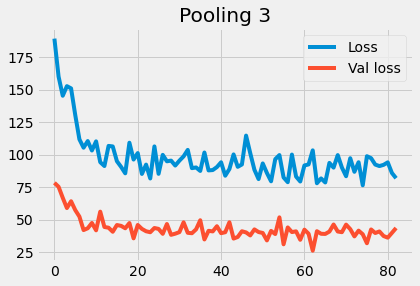

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.44it/s]


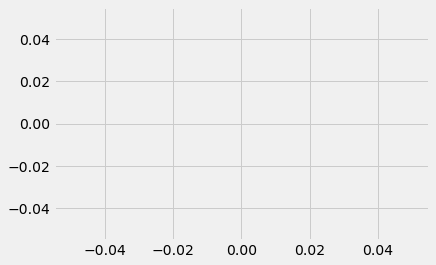

Epoch 1/1000
28/28 [==============================] - 1s 25ms/step - loss: 500.2873 - acc: 0.3843 - val_loss: 446.0798 - val_acc: 0.3243 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 388.9094 - acc: 0.4022 - val_loss: 285.4516 - val_acc: 0.3964 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 268.5055 - acc: 0.4169 - val_loss: 199.5338 - val_acc: 0.4054 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 205.5931 - acc: 0.4607 - val_loss: 111.9187 - val_acc: 0.4955 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 136.5843 - acc: 0.5258 - val_loss: 81.9602 - val_acc: 0.5586 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 106.3801 - acc: 0.5753 - val_loss: 54.8435 - val_acc: 0.5495 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 95.

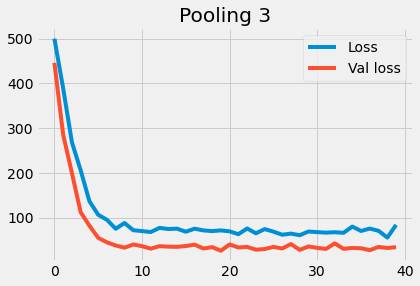

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.58it/s]


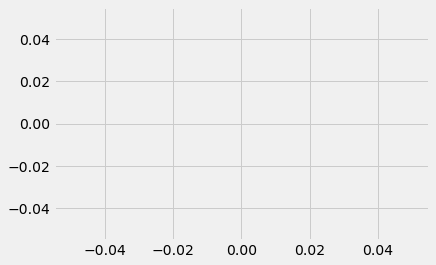

Epoch 1/1000
28/28 [==============================] - 1s 23ms/step - loss: 258.1201 - acc: 0.4742 - val_loss: 162.5627 - val_acc: 0.4414 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 197.3183 - acc: 0.5360 - val_loss: 104.6023 - val_acc: 0.5135 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 161.2679 - acc: 0.5798 - val_loss: 90.0169 - val_acc: 0.5586 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 152.2230 - acc: 0.6011 - val_loss: 76.6325 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 138.4671 - acc: 0.6045 - val_loss: 77.3764 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 132.6611 - acc: 0.6124 - val_loss: 76.1749 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 121.6

28/28 [==============================] - 0s 11ms/step - loss: 85.8316 - acc: 0.6483 - val_loss: 45.5379 - val_acc: 0.6486 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 10ms/step - loss: 73.9446 - acc: 0.6472 - val_loss: 42.4923 - val_acc: 0.6757 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 11ms/step - loss: 88.7267 - acc: 0.6382 - val_loss: 39.0033 - val_acc: 0.6667 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 11ms/step - loss: 76.1622 - acc: 0.6483 - val_loss: 39.6975 - val_acc: 0.7117 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 11ms/step - loss: 75.2347 - acc: 0.6539 - val_loss: 43.3074 - val_acc: 0.6486 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 10ms/step - loss: 83.0983 - acc: 0.6258 - val_loss: 38.6258 - val_acc: 0.6757 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 10ms/step - loss: 78.6447 - acc: 0.639

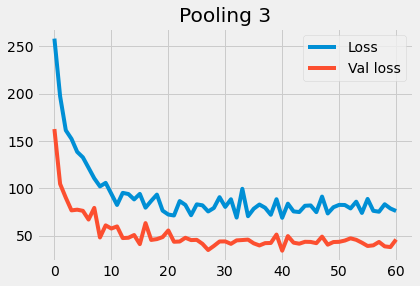

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.84it/s]


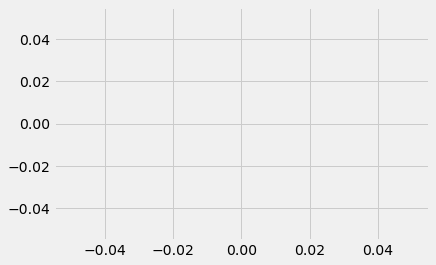

Epoch 1/1000
28/28 [==============================] - 1s 26ms/step - loss: 165.9426 - acc: 0.4303 - val_loss: 47.2879 - val_acc: 0.4324 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 102.7547 - acc: 0.5112 - val_loss: 38.3136 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 101.4455 - acc: 0.5360 - val_loss: 42.2173 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 85.1503 - acc: 0.5708 - val_loss: 33.3491 - val_acc: 0.7117 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 90.5613 - acc: 0.5888 - val_loss: 35.8662 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 83.5396 - acc: 0.5764 - val_loss: 38.5263 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 76.3133 - 

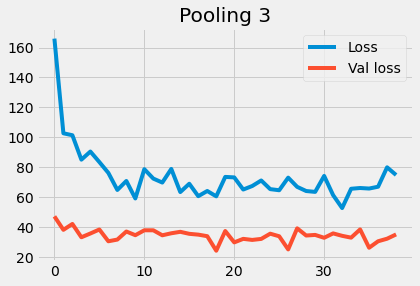

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.98it/s]


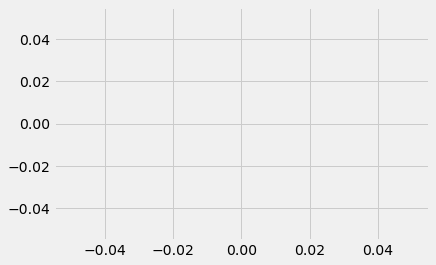

Epoch 1/1000
28/28 [==============================] - 1s 20ms/step - loss: 294.3187 - acc: 0.3933 - val_loss: 180.2473 - val_acc: 0.3694 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 254.4892 - acc: 0.4326 - val_loss: 156.0452 - val_acc: 0.3694 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 228.3403 - acc: 0.4865 - val_loss: 123.8613 - val_acc: 0.4054 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 9ms/step - loss: 207.5253 - acc: 0.5056 - val_loss: 117.5277 - val_acc: 0.4414 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 178.5211 - acc: 0.5146 - val_loss: 98.8369 - val_acc: 0.4234 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 173.7195 - acc: 0.5202 - val_loss: 81.9044 - val_acc: 0.4685 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 149.

28/28 [==============================] - 0s 10ms/step - loss: 111.5460 - acc: 0.5978 - val_loss: 51.1514 - val_acc: 0.5676 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 10ms/step - loss: 114.9952 - acc: 0.5787 - val_loss: 51.9063 - val_acc: 0.5856 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 10ms/step - loss: 115.3575 - acc: 0.5787 - val_loss: 48.0577 - val_acc: 0.5946 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 9ms/step - loss: 113.5661 - acc: 0.6022 - val_loss: 47.9031 - val_acc: 0.6126 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 10ms/step - loss: 125.6356 - acc: 0.5640 - val_loss: 49.2235 - val_acc: 0.5856 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 11ms/step - loss: 108.0121 - acc: 0.6000 - val_loss: 51.3647 - val_acc: 0.5856 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 11ms/step - loss: 112.0462 - acc:

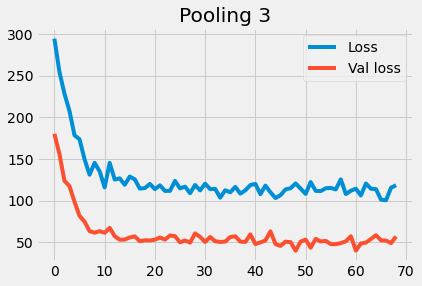

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.28it/s]


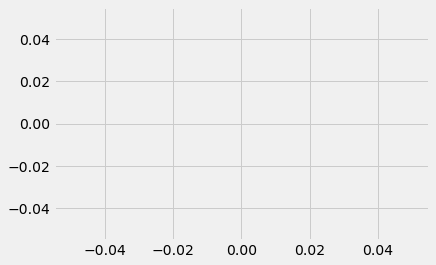

Epoch 1/1000
28/28 [==============================] - 1s 24ms/step - loss: 298.8419 - acc: 0.5955 - val_loss: 210.5309 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 220.5079 - acc: 0.5955 - val_loss: 165.5991 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 163.6961 - acc: 0.5899 - val_loss: 99.4339 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 118.4885 - acc: 0.5831 - val_loss: 62.3359 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 82.4721 - acc: 0.6112 - val_loss: 39.0089 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 78.1112 - acc: 0.5843 - val_loss: 37.0276 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 73.9687

28/28 [==============================] - 0s 11ms/step - loss: 49.9532 - acc: 0.6135 - val_loss: 27.4433 - val_acc: 0.6396 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 10ms/step - loss: 45.2046 - acc: 0.6079 - val_loss: 24.1504 - val_acc: 0.6847 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 10ms/step - loss: 50.0792 - acc: 0.5966 - val_loss: 25.3453 - val_acc: 0.6486 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 10ms/step - loss: 52.3442 - acc: 0.6011 - val_loss: 26.5809 - val_acc: 0.6396 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 10ms/step - loss: 50.6701 - acc: 0.6169 - val_loss: 26.8561 - val_acc: 0.6396 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 10ms/step - loss: 44.8472 - acc: 0.6191 - val_loss: 27.7133 - val_acc: 0.6486 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 11ms/step - loss: 52.4980 - acc: 0.573

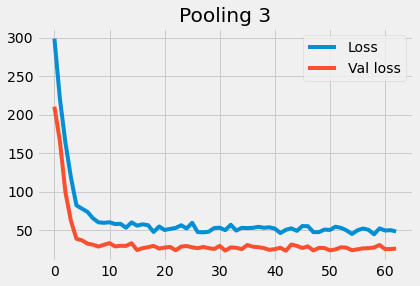

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.15it/s]


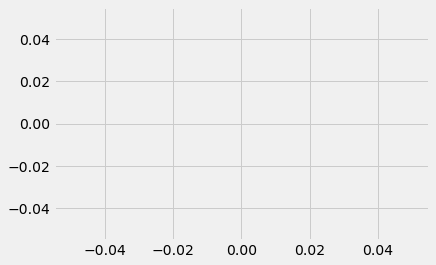

Epoch 1/1000
28/28 [==============================] - 1s 20ms/step - loss: 415.9916 - acc: 0.3506 - val_loss: 330.9102 - val_acc: 0.2883 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 300.8788 - acc: 0.3775 - val_loss: 181.6527 - val_acc: 0.3604 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 12ms/step - loss: 203.9737 - acc: 0.4539 - val_loss: 105.8210 - val_acc: 0.4414 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 12ms/step - loss: 131.6746 - acc: 0.5360 - val_loss: 59.8577 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 107.9767 - acc: 0.5865 - val_loss: 58.4041 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 12ms/step - loss: 87.2205 - acc: 0.6112 - val_loss: 52.1327 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 68.15

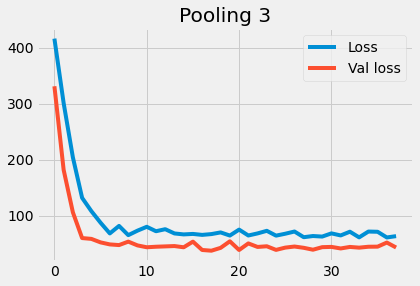

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.06it/s]


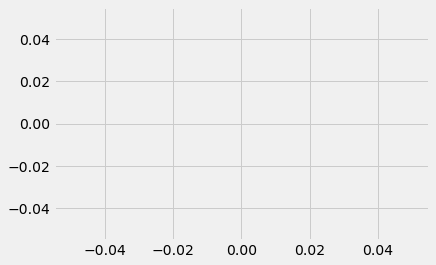

Epoch 1/1000
28/28 [==============================] - 1s 20ms/step - loss: 173.7970 - acc: 0.4629 - val_loss: 129.1100 - val_acc: 0.4324 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 121.6419 - acc: 0.5191 - val_loss: 93.5155 - val_acc: 0.4865 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 104.9829 - acc: 0.5315 - val_loss: 77.5208 - val_acc: 0.5315 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 93.5138 - acc: 0.5831 - val_loss: 67.1108 - val_acc: 0.5315 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 92.1105 - acc: 0.5820 - val_loss: 60.3773 - val_acc: 0.5676 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 90.0061 - acc: 0.6067 - val_loss: 72.9104 - val_acc: 0.5315 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 75.7608 -

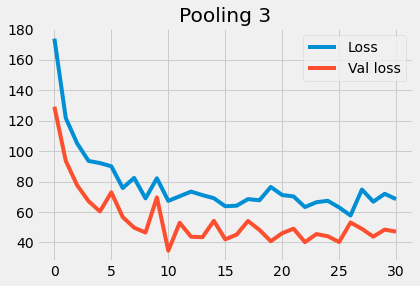

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.12it/s]


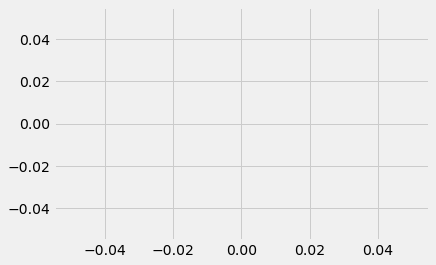

Epoch 1/1000
28/28 [==============================] - 1s 23ms/step - loss: 111.0665 - acc: 0.5371 - val_loss: 46.3435 - val_acc: 0.5856 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 112.3036 - acc: 0.5539 - val_loss: 38.6852 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 103.2309 - acc: 0.5708 - val_loss: 34.9367 - val_acc: 0.6847 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 98.7439 - acc: 0.5764 - val_loss: 34.9534 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 91.9527 - acc: 0.5708 - val_loss: 38.0162 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 93.6704 - acc: 0.5652 - val_loss: 31.6765 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 85.7355 - 

Epoch 55/1000
28/28 [==============================] - 0s 11ms/step - loss: 57.9144 - acc: 0.6270 - val_loss: 27.1616 - val_acc: 0.7117 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 10ms/step - loss: 56.0667 - acc: 0.6112 - val_loss: 30.4782 - val_acc: 0.6486 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 10ms/step - loss: 68.0994 - acc: 0.6101 - val_loss: 25.3213 - val_acc: 0.7477 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 10ms/step - loss: 66.4151 - acc: 0.6180 - val_loss: 30.8243 - val_acc: 0.6937 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 10ms/step - loss: 59.3496 - acc: 0.6056 - val_loss: 35.6075 - val_acc: 0.6396 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 11ms/step - loss: 58.8302 - acc: 0.6202 - val_loss: 27.3905 - val_acc: 0.7117 - lr: 1.0000e-06


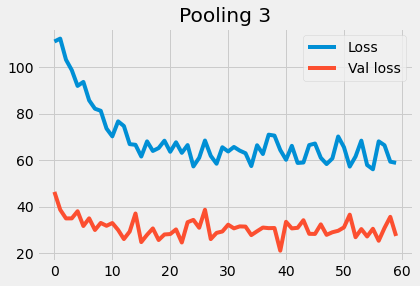

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.88it/s]


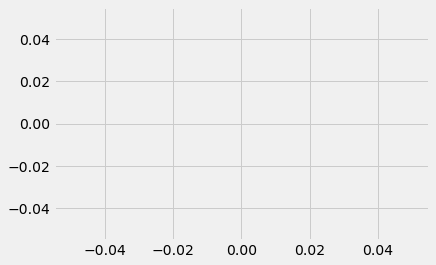

Epoch 1/1000
28/28 [==============================] - 1s 23ms/step - loss: 270.7272 - acc: 0.6101 - val_loss: 145.9907 - val_acc: 0.6847 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 202.8077 - acc: 0.6326 - val_loss: 128.3665 - val_acc: 0.6847 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 180.6771 - acc: 0.5899 - val_loss: 110.9800 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 132.9236 - acc: 0.6213 - val_loss: 72.9329 - val_acc: 0.6847 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 135.2199 - acc: 0.5798 - val_loss: 62.3713 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 121.0684 - acc: 0.5775 - val_loss: 54.6430 - val_acc: 0.5856 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 111.

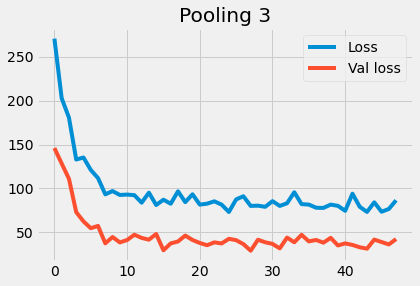

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.80it/s]


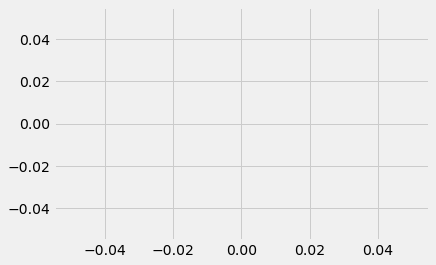

Epoch 1/1000
28/28 [==============================] - 1s 21ms/step - loss: 766.5421 - acc: 0.4090 - val_loss: 537.5168 - val_acc: 0.3423 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 584.5775 - acc: 0.4022 - val_loss: 365.9249 - val_acc: 0.3604 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 399.6740 - acc: 0.4303 - val_loss: 245.4930 - val_acc: 0.3784 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 295.0618 - acc: 0.4404 - val_loss: 108.8708 - val_acc: 0.3964 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 212.4726 - acc: 0.4921 - val_loss: 70.8463 - val_acc: 0.5225 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 152.7035 - acc: 0.5584 - val_loss: 58.0851 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 129

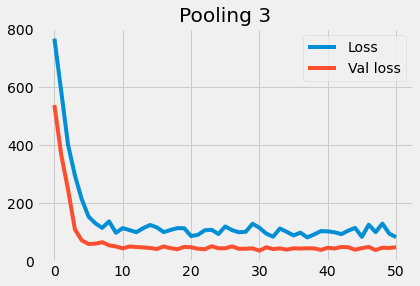

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.33it/s]


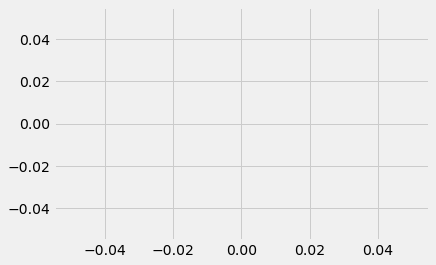

Epoch 1/1000
28/28 [==============================] - 1s 24ms/step - loss: 597.6519 - acc: 0.4045 - val_loss: 472.9318 - val_acc: 0.3333 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 478.3955 - acc: 0.4169 - val_loss: 316.9785 - val_acc: 0.4054 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 395.6009 - acc: 0.4213 - val_loss: 252.6150 - val_acc: 0.3514 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 9ms/step - loss: 286.2023 - acc: 0.4281 - val_loss: 148.0910 - val_acc: 0.3514 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 208.4323 - acc: 0.4270 - val_loss: 90.2888 - val_acc: 0.3964 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 144.4016 - acc: 0.4955 - val_loss: 57.8445 - val_acc: 0.5856 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 111.

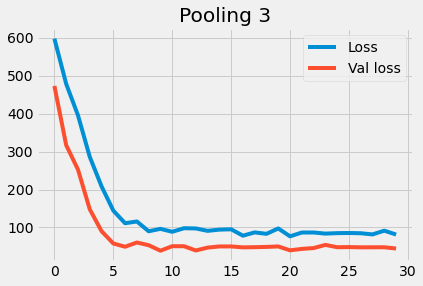

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.77it/s]


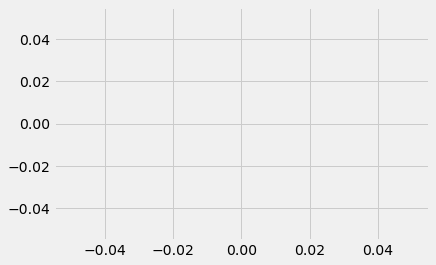

Epoch 1/1000
28/28 [==============================] - 1s 19ms/step - loss: 189.3948 - acc: 0.5697 - val_loss: 109.9420 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 148.6056 - acc: 0.5787 - val_loss: 73.7491 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 9ms/step - loss: 134.8961 - acc: 0.5427 - val_loss: 56.5286 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 114.3831 - acc: 0.5371 - val_loss: 41.0396 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 9ms/step - loss: 101.2848 - acc: 0.5438 - val_loss: 39.7053 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 93.1186 - acc: 0.5573 - val_loss: 43.0779 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 9ms/step - loss: 96.8169 - 

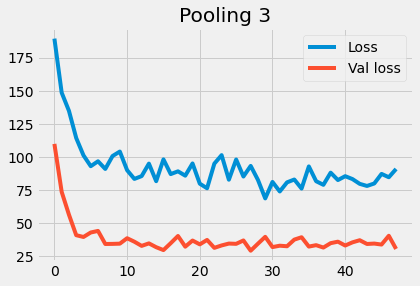

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.59it/s]


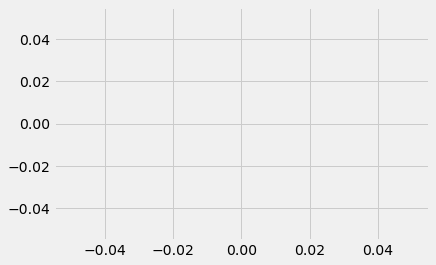

Epoch 1/1000
28/28 [==============================] - 1s 22ms/step - loss: 201.1670 - acc: 0.6404 - val_loss: 126.4548 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 155.8491 - acc: 0.6303 - val_loss: 87.5505 - val_acc: 0.6847 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 113.2513 - acc: 0.6494 - val_loss: 102.7159 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 124.0078 - acc: 0.6146 - val_loss: 71.1355 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 12ms/step - loss: 90.4709 - acc: 0.6483 - val_loss: 63.2387 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 100.5490 - acc: 0.6169 - val_loss: 42.4294 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 68.545

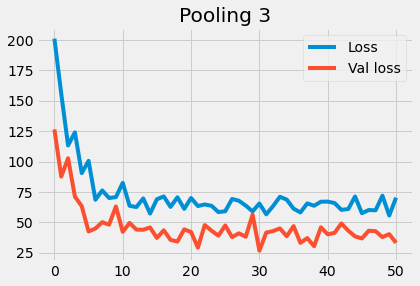

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.84it/s]


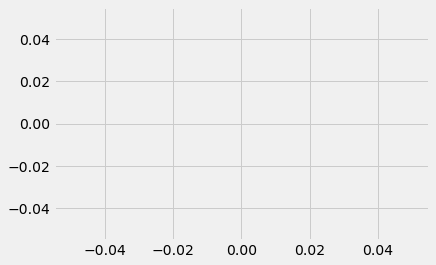

Epoch 1/1000
28/28 [==============================] - 2s 36ms/step - loss: 136.4207 - acc: 0.6146 - val_loss: 70.5844 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 145.5127 - acc: 0.5966 - val_loss: 59.0762 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 100.0100 - acc: 0.5966 - val_loss: 50.6429 - val_acc: 0.6847 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 90.6091 - acc: 0.5888 - val_loss: 36.2608 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 94.8320 - acc: 0.5865 - val_loss: 53.6194 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 68.4076 - acc: 0.6045 - val_loss: 42.9281 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 9ms/step - loss: 67.0184 - a

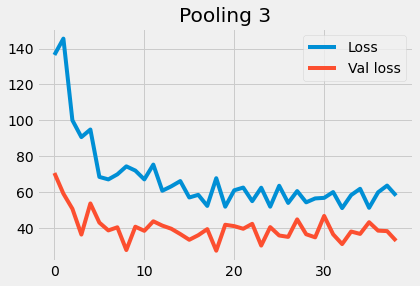

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.12it/s]


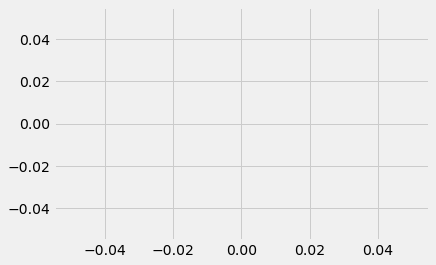

Epoch 1/1000
28/28 [==============================] - 1s 23ms/step - loss: 195.9977 - acc: 0.5517 - val_loss: 113.2090 - val_acc: 0.4955 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 155.5242 - acc: 0.5697 - val_loss: 82.6650 - val_acc: 0.5315 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 12ms/step - loss: 126.1186 - acc: 0.5843 - val_loss: 65.5533 - val_acc: 0.5676 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 106.2351 - acc: 0.6011 - val_loss: 62.5985 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 106.5338 - acc: 0.6169 - val_loss: 34.4478 - val_acc: 0.6937 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 117.8210 - acc: 0.6169 - val_loss: 56.4055 - val_acc: 0.5856 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 88.389

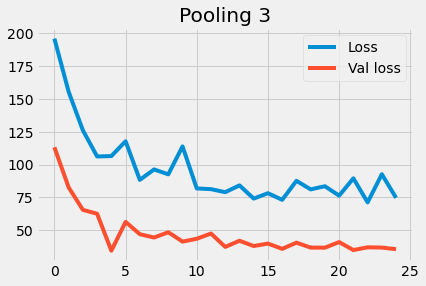

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.26it/s]


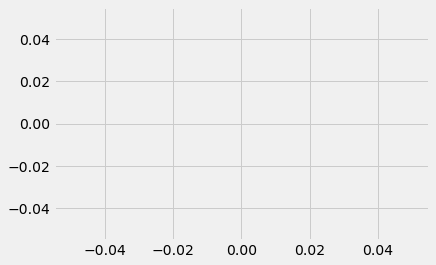

Epoch 1/1000
28/28 [==============================] - 2s 44ms/step - loss: 347.7095 - acc: 0.5888 - val_loss: 212.8354 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 292.6582 - acc: 0.5843 - val_loss: 191.4023 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 265.0820 - acc: 0.6124 - val_loss: 129.7600 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 236.2370 - acc: 0.5989 - val_loss: 143.9497 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 179.2584 - acc: 0.6034 - val_loss: 89.8194 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 125.0983 - acc: 0.6090 - val_loss: 85.1903 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 131

28/28 [==============================] - 0s 11ms/step - loss: 71.0247 - acc: 0.6449 - val_loss: 32.7082 - val_acc: 0.7027 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 10ms/step - loss: 80.3520 - acc: 0.6169 - val_loss: 27.6042 - val_acc: 0.7117 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 10ms/step - loss: 64.6950 - acc: 0.6337 - val_loss: 33.9080 - val_acc: 0.6667 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 12ms/step - loss: 71.6327 - acc: 0.6326 - val_loss: 29.5614 - val_acc: 0.6937 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 10ms/step - loss: 61.8350 - acc: 0.6393 - val_loss: 31.6320 - val_acc: 0.7027 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 11ms/step - loss: 66.8768 - acc: 0.6494 - val_loss: 31.8222 - val_acc: 0.7117 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 10ms/step - loss: 67.7207 - acc: 0.634

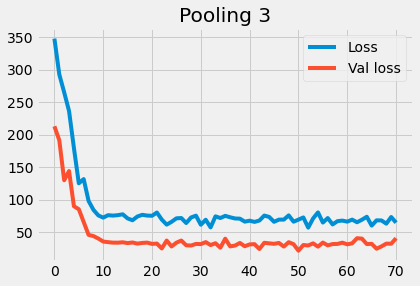

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.01it/s]


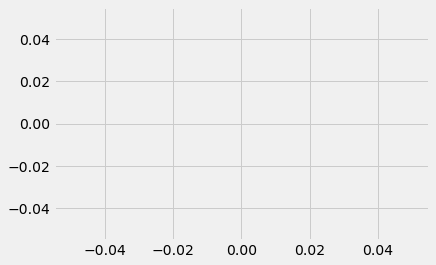

Epoch 1/1000
28/28 [==============================] - 1s 21ms/step - loss: 360.9518 - acc: 0.5652 - val_loss: 249.1840 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 316.9447 - acc: 0.5472 - val_loss: 212.1914 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 227.3751 - acc: 0.5348 - val_loss: 157.8002 - val_acc: 0.5495 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 232.6804 - acc: 0.5337 - val_loss: 100.3934 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 202.7518 - acc: 0.5157 - val_loss: 91.4321 - val_acc: 0.5676 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 159.8300 - acc: 0.5371 - val_loss: 72.7400 - val_acc: 0.5495 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 147

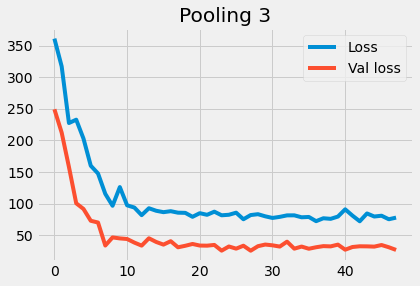

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.44it/s]


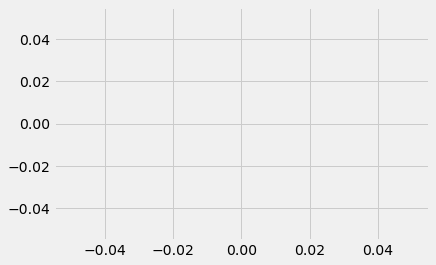

Epoch 1/1000
28/28 [==============================] - 2s 40ms/step - loss: 301.1177 - acc: 0.4663 - val_loss: 173.7474 - val_acc: 0.4414 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 223.3670 - acc: 0.5247 - val_loss: 98.6656 - val_acc: 0.5225 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 168.8254 - acc: 0.5618 - val_loss: 52.9280 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 145.9005 - acc: 0.6011 - val_loss: 52.6950 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 125.1632 - acc: 0.5562 - val_loss: 43.8467 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 134.8098 - acc: 0.5584 - val_loss: 49.0554 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 116.24

28/28 [==============================] - 0s 10ms/step - loss: 107.5251 - acc: 0.5989 - val_loss: 39.6420 - val_acc: 0.6847 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 9ms/step - loss: 96.9230 - acc: 0.6056 - val_loss: 36.7332 - val_acc: 0.7027 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 10ms/step - loss: 100.7484 - acc: 0.6022 - val_loss: 38.5305 - val_acc: 0.7027 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 11ms/step - loss: 107.1459 - acc: 0.6000 - val_loss: 42.8014 - val_acc: 0.6937 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 10ms/step - loss: 95.7288 - acc: 0.6247 - val_loss: 40.0228 - val_acc: 0.6937 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 10ms/step - loss: 87.9841 - acc: 0.6191 - val_loss: 36.6106 - val_acc: 0.7117 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 11ms/step - loss: 110.9144 - acc: 0.

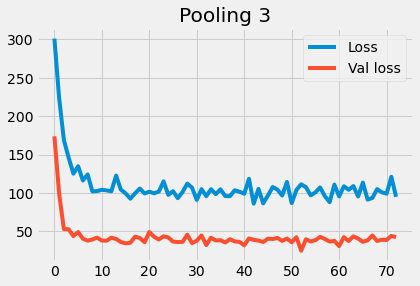

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.19it/s]


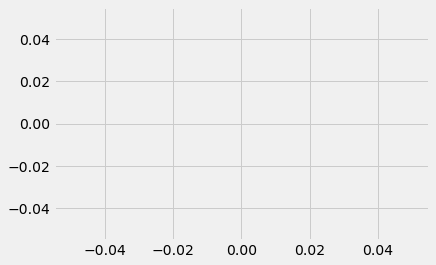

Epoch 1/1000
28/28 [==============================] - 1s 23ms/step - loss: 345.5147 - acc: 0.5944 - val_loss: 234.9069 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 260.8783 - acc: 0.5978 - val_loss: 172.6225 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 198.6160 - acc: 0.6034 - val_loss: 121.1206 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 142.9548 - acc: 0.6281 - val_loss: 71.1497 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 118.3820 - acc: 0.6225 - val_loss: 68.6528 - val_acc: 0.7027 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 111.9697 - acc: 0.6011 - val_loss: 51.9626 - val_acc: 0.6937 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 90.8

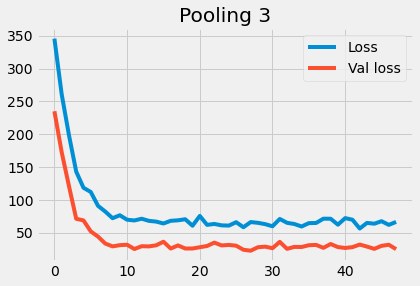

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.50it/s]


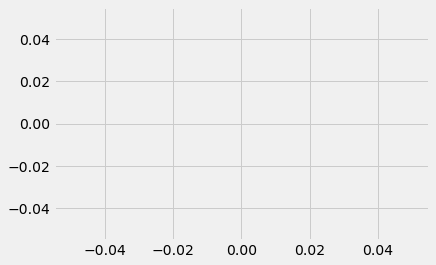

Epoch 1/1000
28/28 [==============================] - 2s 38ms/step - loss: 133.4989 - acc: 0.5955 - val_loss: 68.2012 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 9ms/step - loss: 116.4305 - acc: 0.5809 - val_loss: 55.8060 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 110.6504 - acc: 0.6079 - val_loss: 45.2684 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 115.3868 - acc: 0.6303 - val_loss: 47.1389 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 89.8250 - acc: 0.6202 - val_loss: 42.1419 - val_acc: 0.7027 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 86.1202 - acc: 0.6404 - val_loss: 41.3234 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 94.3946 - 

Epoch 55/1000
28/28 [==============================] - 0s 10ms/step - loss: 73.2431 - acc: 0.6438 - val_loss: 33.4608 - val_acc: 0.6486 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 11ms/step - loss: 70.4749 - acc: 0.6562 - val_loss: 31.9678 - val_acc: 0.6937 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 11ms/step - loss: 64.6857 - acc: 0.6483 - val_loss: 29.6459 - val_acc: 0.6577 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 11ms/step - loss: 69.0401 - acc: 0.6618 - val_loss: 33.6455 - val_acc: 0.6486 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 9ms/step - loss: 84.5414 - acc: 0.6337 - val_loss: 36.9149 - val_acc: 0.6396 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 11ms/step - loss: 58.8459 - acc: 0.6652 - val_loss: 30.2252 - val_acc: 0.6577 - lr: 1.0000e-06


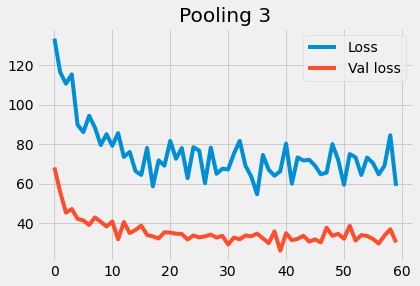

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.98it/s]


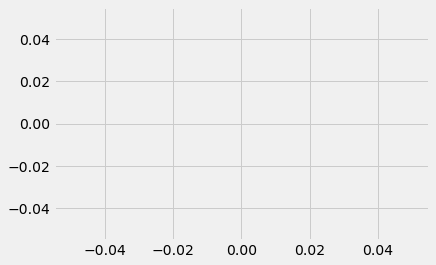

Epoch 1/1000
28/28 [==============================] - 1s 21ms/step - loss: 127.8527 - acc: 0.5157 - val_loss: 67.4960 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 102.8992 - acc: 0.5101 - val_loss: 49.6331 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 12ms/step - loss: 107.8546 - acc: 0.5303 - val_loss: 33.8758 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 99.6665 - acc: 0.5270 - val_loss: 35.2318 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 9ms/step - loss: 84.5566 - acc: 0.5393 - val_loss: 33.0528 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 89.7956 - acc: 0.5393 - val_loss: 30.7053 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 65.3685 - a

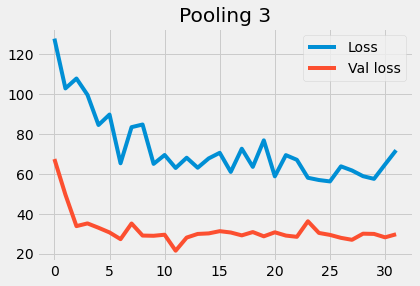

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.13it/s]


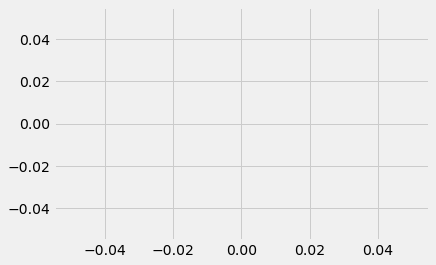

Epoch 1/1000
28/28 [==============================] - 2s 45ms/step - loss: 185.4624 - acc: 0.5607 - val_loss: 127.2477 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 12ms/step - loss: 140.3112 - acc: 0.5708 - val_loss: 96.5513 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 105.8903 - acc: 0.5955 - val_loss: 79.2180 - val_acc: 0.5225 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 98.1325 - acc: 0.5674 - val_loss: 43.1254 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 73.7847 - acc: 0.5978 - val_loss: 37.0837 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 12ms/step - loss: 69.8164 - acc: 0.6236 - val_loss: 34.8623 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 12ms/step - loss: 67.7232 -

28/28 [==============================] - 0s 10ms/step - loss: 56.9470 - acc: 0.5955 - val_loss: 31.2922 - val_acc: 0.6847 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 10ms/step - loss: 46.1792 - acc: 0.6674 - val_loss: 32.2512 - val_acc: 0.6577 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 11ms/step - loss: 51.4953 - acc: 0.6416 - val_loss: 30.3304 - val_acc: 0.7117 - lr: 1.0000e-06


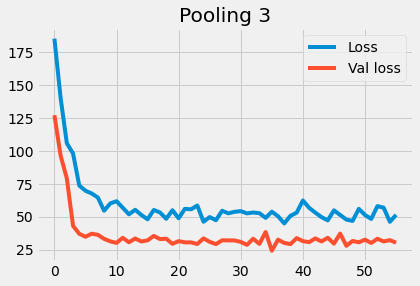

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.68it/s]


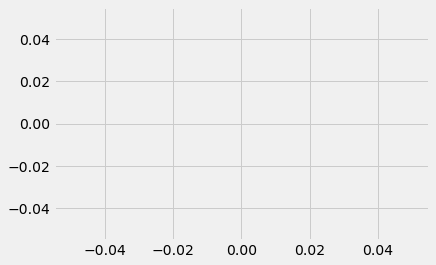

Epoch 1/1000
28/28 [==============================] - 2s 26ms/step - loss: 309.8860 - acc: 0.4270 - val_loss: 183.4214 - val_acc: 0.4054 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 205.4204 - acc: 0.4494 - val_loss: 105.0571 - val_acc: 0.4595 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 137.4818 - acc: 0.4764 - val_loss: 64.6427 - val_acc: 0.4505 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 12ms/step - loss: 119.7980 - acc: 0.4899 - val_loss: 34.8166 - val_acc: 0.6847 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 92.8294 - acc: 0.5551 - val_loss: 43.3952 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 85.4310 - acc: 0.5697 - val_loss: 41.6811 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 81.8953

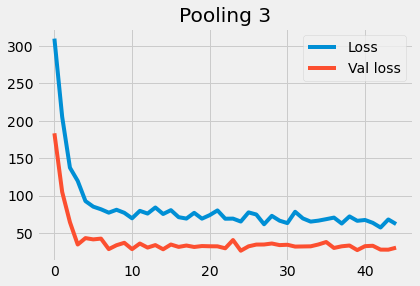

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.46it/s]


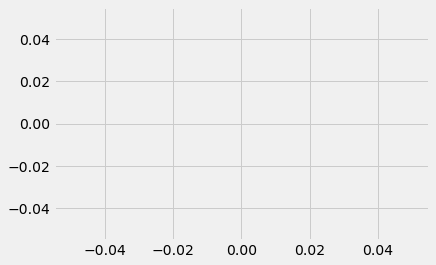

Epoch 1/1000
28/28 [==============================] - 2s 42ms/step - loss: 181.7422 - acc: 0.5528 - val_loss: 98.6305 - val_acc: 0.5676 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 185.5061 - acc: 0.5719 - val_loss: 86.7530 - val_acc: 0.5676 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 9ms/step - loss: 151.5494 - acc: 0.5640 - val_loss: 76.8126 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 122.0112 - acc: 0.5955 - val_loss: 71.3210 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 135.5239 - acc: 0.5843 - val_loss: 60.0470 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 9ms/step - loss: 107.5158 - acc: 0.5674 - val_loss: 46.6299 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 104.8977 

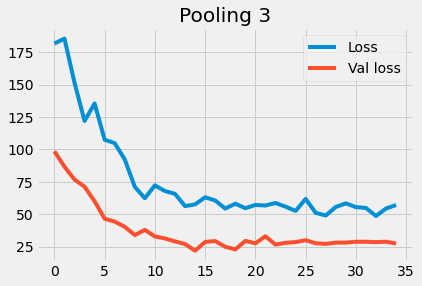

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.71it/s]


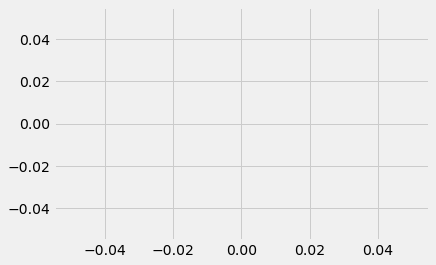

Epoch 1/1000
28/28 [==============================] - 1s 23ms/step - loss: 708.0427 - acc: 0.5742 - val_loss: 481.1884 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 577.8282 - acc: 0.6034 - val_loss: 430.0616 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 484.7790 - acc: 0.5966 - val_loss: 371.8613 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 410.7551 - acc: 0.6022 - val_loss: 233.6442 - val_acc: 0.6937 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 364.1619 - acc: 0.5708 - val_loss: 250.2515 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 9ms/step - loss: 309.3695 - acc: 0.5697 - val_loss: 179.9832 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 25

28/28 [==============================] - 0s 10ms/step - loss: 118.4080 - acc: 0.5910 - val_loss: 50.0857 - val_acc: 0.6216 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 9ms/step - loss: 115.4215 - acc: 0.6067 - val_loss: 32.7922 - val_acc: 0.6486 - lr: 1.0000e-06


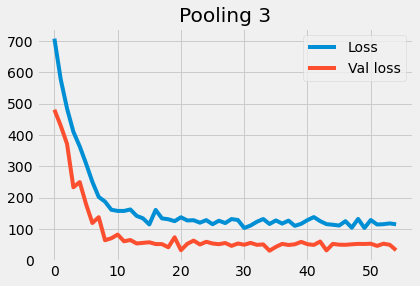

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.58it/s]


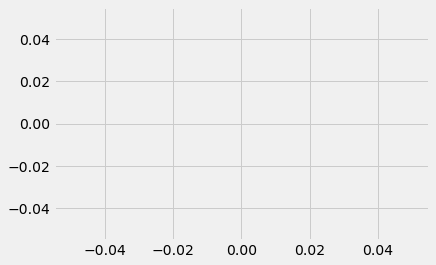

Epoch 1/1000
28/28 [==============================] - 2s 44ms/step - loss: 439.8618 - acc: 0.3989 - val_loss: 329.8736 - val_acc: 0.3784 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 351.0774 - acc: 0.4135 - val_loss: 248.7399 - val_acc: 0.3514 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 228.2160 - acc: 0.4191 - val_loss: 136.5146 - val_acc: 0.3423 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 145.7944 - acc: 0.4461 - val_loss: 54.5841 - val_acc: 0.4775 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 102.7298 - acc: 0.5270 - val_loss: 34.2033 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 9ms/step - loss: 81.8586 - acc: 0.5831 - val_loss: 33.6412 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 77.218

28/28 [==============================] - 0s 11ms/step - loss: 48.2935 - acc: 0.6169 - val_loss: 32.6012 - val_acc: 0.6216 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 11ms/step - loss: 65.3405 - acc: 0.6270 - val_loss: 30.5473 - val_acc: 0.6396 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 11ms/step - loss: 63.3902 - acc: 0.6169 - val_loss: 31.2534 - val_acc: 0.6216 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 11ms/step - loss: 58.2913 - acc: 0.6101 - val_loss: 31.8231 - val_acc: 0.6126 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 11ms/step - loss: 56.6203 - acc: 0.6315 - val_loss: 29.8346 - val_acc: 0.6757 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 11ms/step - loss: 55.7204 - acc: 0.6270 - val_loss: 30.8341 - val_acc: 0.6396 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 11ms/step - loss: 64.5670 - acc: 0.616

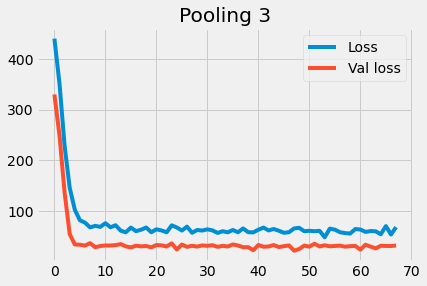

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.75it/s]


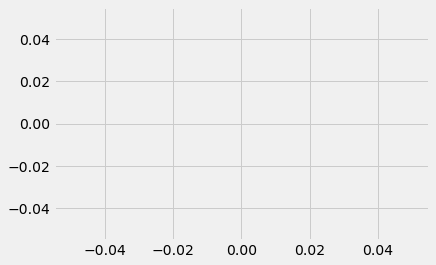

Epoch 1/1000
28/28 [==============================] - 1s 23ms/step - loss: 208.7843 - acc: 0.5135 - val_loss: 100.9780 - val_acc: 0.4955 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 8ms/step - loss: 177.0012 - acc: 0.5101 - val_loss: 60.7463 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 167.6868 - acc: 0.5056 - val_loss: 52.8065 - val_acc: 0.5586 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 9ms/step - loss: 142.8467 - acc: 0.5461 - val_loss: 42.9698 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 131.1974 - acc: 0.5472 - val_loss: 38.9734 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 12ms/step - loss: 134.4439 - acc: 0.5483 - val_loss: 43.9446 - val_acc: 0.5676 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 12ms/step - loss: 95.9994 

28/28 [==============================] - 0s 10ms/step - loss: 81.9791 - acc: 0.6292 - val_loss: 32.5911 - val_acc: 0.6577 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 11ms/step - loss: 95.7863 - acc: 0.6079 - val_loss: 33.6742 - val_acc: 0.6667 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 11ms/step - loss: 80.1714 - acc: 0.6360 - val_loss: 40.7203 - val_acc: 0.6306 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 12ms/step - loss: 86.7775 - acc: 0.6079 - val_loss: 34.0875 - val_acc: 0.6757 - lr: 1.0000e-06


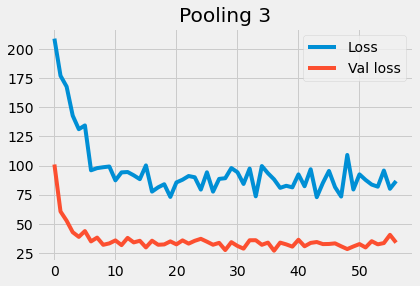

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.73it/s]


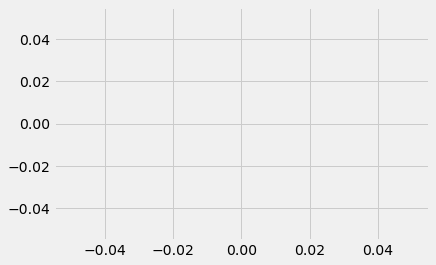

Epoch 1/1000
28/28 [==============================] - 2s 46ms/step - loss: 200.7877 - acc: 0.4292 - val_loss: 99.0479 - val_acc: 0.5135 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 144.7507 - acc: 0.4685 - val_loss: 73.5735 - val_acc: 0.5315 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 112.0542 - acc: 0.5337 - val_loss: 53.3256 - val_acc: 0.5856 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 98.9478 - acc: 0.5472 - val_loss: 52.8581 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 89.2600 - acc: 0.5247 - val_loss: 42.5865 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 77.0608 - acc: 0.5719 - val_loss: 36.5641 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 81.7547 - 

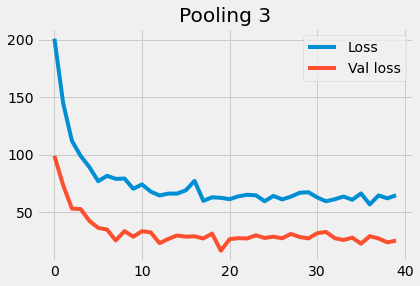

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.57it/s]


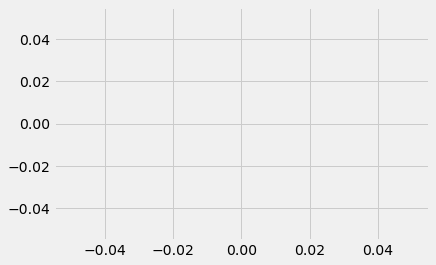

Epoch 1/1000
28/28 [==============================] - 1s 19ms/step - loss: 463.2155 - acc: 0.5494 - val_loss: 334.3938 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 376.0172 - acc: 0.5652 - val_loss: 321.3734 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 325.6805 - acc: 0.5742 - val_loss: 261.8711 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 9ms/step - loss: 271.6173 - acc: 0.5652 - val_loss: 203.9629 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 9ms/step - loss: 223.1529 - acc: 0.5562 - val_loss: 142.8592 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 175.2043 - acc: 0.5607 - val_loss: 97.1344 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 132.

28/28 [==============================] - 0s 10ms/step - loss: 95.6955 - acc: 0.6360 - val_loss: 34.4090 - val_acc: 0.7297 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 10ms/step - loss: 79.8927 - acc: 0.6146 - val_loss: 39.0696 - val_acc: 0.6847 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 9ms/step - loss: 104.1943 - acc: 0.6045 - val_loss: 35.4912 - val_acc: 0.7117 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 10ms/step - loss: 82.4809 - acc: 0.6169 - val_loss: 32.8928 - val_acc: 0.7387 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 10ms/step - loss: 82.4230 - acc: 0.6022 - val_loss: 32.5667 - val_acc: 0.7117 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 9ms/step - loss: 87.5624 - acc: 0.6303 - val_loss: 43.6964 - val_acc: 0.6757 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 9ms/step - loss: 78.2274 - acc: 0.6404 

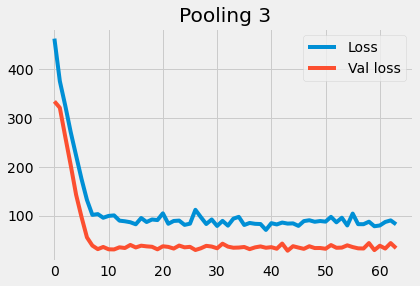

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.39it/s]


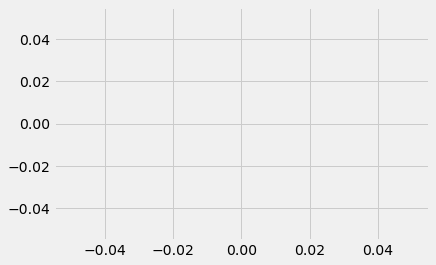

Epoch 1/1000
28/28 [==============================] - 2s 45ms/step - loss: 177.5516 - acc: 0.4944 - val_loss: 74.6992 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 12ms/step - loss: 156.1010 - acc: 0.5067 - val_loss: 69.0033 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 12ms/step - loss: 140.3660 - acc: 0.5157 - val_loss: 56.4981 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 118.3568 - acc: 0.5438 - val_loss: 46.9524 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 107.2881 - acc: 0.5371 - val_loss: 42.8098 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 98.3081 - acc: 0.5596 - val_loss: 41.1187 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 106.7396

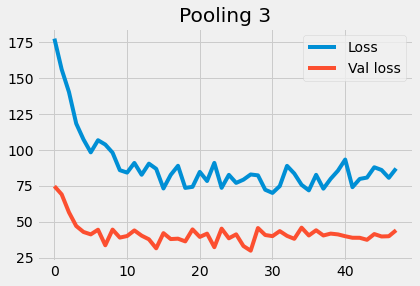

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.64it/s]


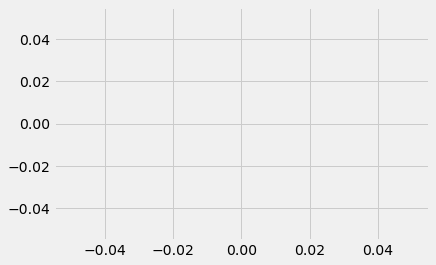

Epoch 1/1000
28/28 [==============================] - 2s 26ms/step - loss: 335.0985 - acc: 0.6022 - val_loss: 251.7800 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 267.0250 - acc: 0.5865 - val_loss: 178.5569 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 192.2552 - acc: 0.5517 - val_loss: 158.7905 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 15ms/step - loss: 151.1326 - acc: 0.5371 - val_loss: 99.4899 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 12ms/step - loss: 127.3907 - acc: 0.5607 - val_loss: 79.8310 - val_acc: 0.5856 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 13ms/step - loss: 114.3168 - acc: 0.5719 - val_loss: 59.2726 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 107.

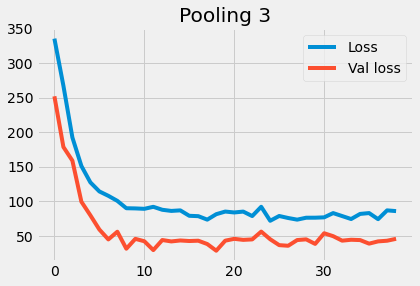

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.97it/s]


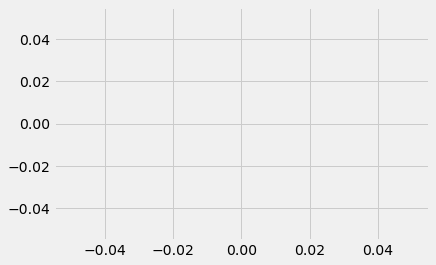

Epoch 1/1000
28/28 [==============================] - 2s 40ms/step - loss: 362.0807 - acc: 0.4213 - val_loss: 166.6129 - val_acc: 0.4234 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 257.1082 - acc: 0.4831 - val_loss: 89.0443 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 187.4973 - acc: 0.5584 - val_loss: 70.5105 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 9ms/step - loss: 154.5934 - acc: 0.5831 - val_loss: 74.6000 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 152.2346 - acc: 0.5775 - val_loss: 68.0664 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 141.0121 - acc: 0.5989 - val_loss: 71.9084 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 12ms/step - loss: 124.889

28/28 [==============================] - 0s 10ms/step - loss: 109.4543 - acc: 0.5978 - val_loss: 48.1230 - val_acc: 0.6667 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 11ms/step - loss: 115.9723 - acc: 0.6472 - val_loss: 47.6416 - val_acc: 0.6757 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 12ms/step - loss: 88.0950 - acc: 0.6236 - val_loss: 44.9154 - val_acc: 0.6937 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 10ms/step - loss: 107.0377 - acc: 0.6112 - val_loss: 52.3002 - val_acc: 0.6396 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 10ms/step - loss: 101.5874 - acc: 0.6056 - val_loss: 45.4076 - val_acc: 0.6667 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 10ms/step - loss: 96.0740 - acc: 0.6315 - val_loss: 47.3324 - val_acc: 0.6757 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 10ms/step - loss: 126.7536 - acc: 

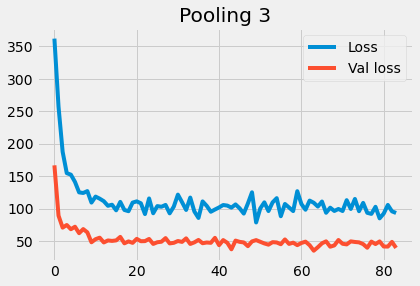

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.75it/s]


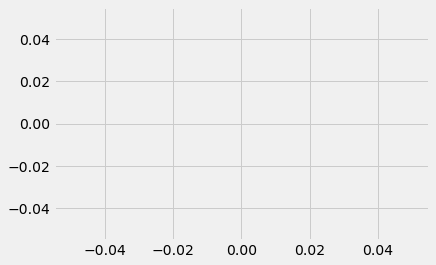

Epoch 1/1000
28/28 [==============================] - 2s 25ms/step - loss: 322.0595 - acc: 0.4034 - val_loss: 217.2209 - val_acc: 0.3514 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 210.1935 - acc: 0.4090 - val_loss: 135.0979 - val_acc: 0.3604 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 145.2263 - acc: 0.4573 - val_loss: 83.9505 - val_acc: 0.4775 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 112.2562 - acc: 0.5247 - val_loss: 56.1507 - val_acc: 0.5225 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 86.2398 - acc: 0.5562 - val_loss: 47.4844 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 9ms/step - loss: 85.2816 - acc: 0.5809 - val_loss: 38.3422 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 68.6796 

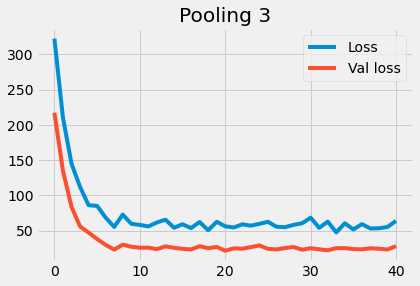

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.02it/s]


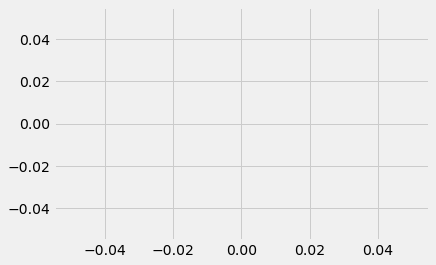

Epoch 1/1000
28/28 [==============================] - 2s 45ms/step - loss: 491.7589 - acc: 0.3944 - val_loss: 269.4567 - val_acc: 0.3784 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 411.8178 - acc: 0.4090 - val_loss: 186.5870 - val_acc: 0.4144 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 307.4037 - acc: 0.4551 - val_loss: 109.3551 - val_acc: 0.4775 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 9ms/step - loss: 269.3799 - acc: 0.4730 - val_loss: 100.9921 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 210.5798 - acc: 0.5315 - val_loss: 79.7811 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 187.4006 - acc: 0.5876 - val_loss: 73.8179 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 155.

28/28 [==============================] - 0s 10ms/step - loss: 86.8382 - acc: 0.6404 - val_loss: 43.8578 - val_acc: 0.6667 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 10ms/step - loss: 104.8932 - acc: 0.6292 - val_loss: 46.3724 - val_acc: 0.6667 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 10ms/step - loss: 72.6469 - acc: 0.6270 - val_loss: 43.1861 - val_acc: 0.6577 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 9ms/step - loss: 95.9698 - acc: 0.6281 - val_loss: 42.5980 - val_acc: 0.6757 - lr: 1.0000e-06


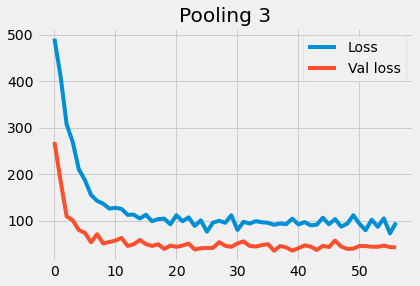

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.08it/s]


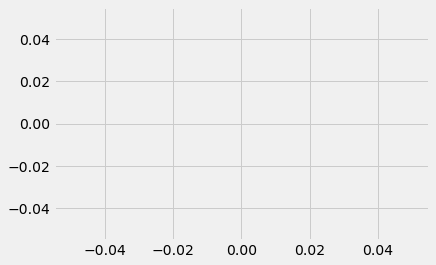

Epoch 1/1000
28/28 [==============================] - 1s 23ms/step - loss: 259.8526 - acc: 0.3933 - val_loss: 175.5694 - val_acc: 0.3604 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 189.8491 - acc: 0.4135 - val_loss: 101.1292 - val_acc: 0.5315 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 147.7029 - acc: 0.4966 - val_loss: 98.5543 - val_acc: 0.4505 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 9ms/step - loss: 134.3818 - acc: 0.4753 - val_loss: 69.0379 - val_acc: 0.5315 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 94.8960 - acc: 0.5270 - val_loss: 54.7965 - val_acc: 0.5225 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 83.3013 - acc: 0.5551 - val_loss: 47.1137 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 76.1008 

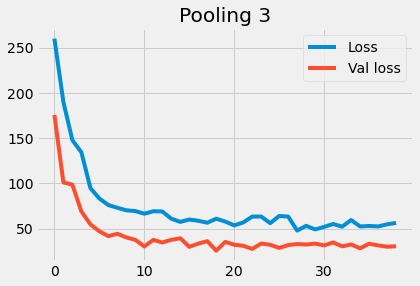

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.01it/s]


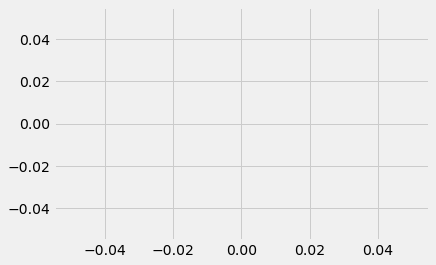

Epoch 1/1000
28/28 [==============================] - 2s 41ms/step - loss: 399.7400 - acc: 0.3742 - val_loss: 235.1590 - val_acc: 0.3243 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 262.6906 - acc: 0.4258 - val_loss: 133.3483 - val_acc: 0.4234 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 215.4383 - acc: 0.4674 - val_loss: 91.6219 - val_acc: 0.5676 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 190.3699 - acc: 0.4820 - val_loss: 76.7907 - val_acc: 0.5495 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 161.0486 - acc: 0.5079 - val_loss: 77.5052 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 151.5685 - acc: 0.5461 - val_loss: 59.6358 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 122.1

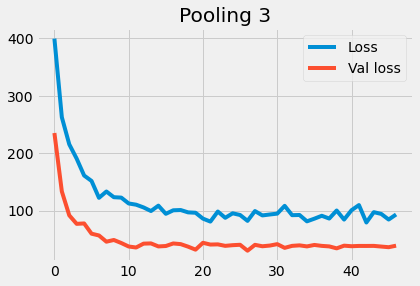

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.99it/s]


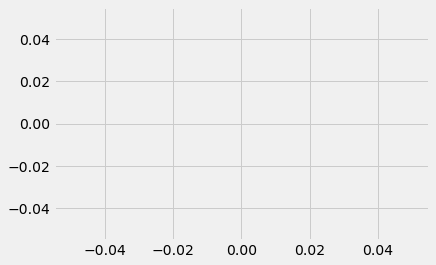

Epoch 1/1000
28/28 [==============================] - 1s 22ms/step - loss: 308.2040 - acc: 0.4652 - val_loss: 143.3106 - val_acc: 0.4685 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 252.6338 - acc: 0.5708 - val_loss: 122.1938 - val_acc: 0.5315 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 241.0315 - acc: 0.5719 - val_loss: 103.6605 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 235.9621 - acc: 0.5506 - val_loss: 101.7782 - val_acc: 0.5405 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 177.2026 - acc: 0.6067 - val_loss: 69.9919 - val_acc: 0.5405 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 179.3817 - acc: 0.5876 - val_loss: 85.3203 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 136

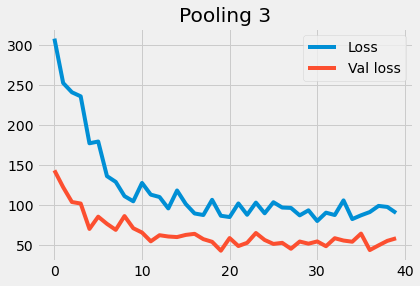

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.84it/s]


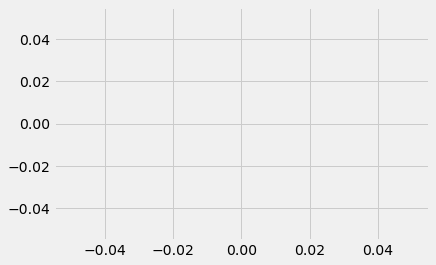

Epoch 1/1000
28/28 [==============================] - 2s 39ms/step - loss: 499.9552 - acc: 0.6090 - val_loss: 300.5859 - val_acc: 0.7027 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 477.8227 - acc: 0.5809 - val_loss: 296.7508 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 378.4272 - acc: 0.5933 - val_loss: 246.4181 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 281.3153 - acc: 0.5989 - val_loss: 195.3246 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 264.9247 - acc: 0.5629 - val_loss: 116.8353 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 201.3894 - acc: 0.5551 - val_loss: 121.0139 - val_acc: 0.5225 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 1

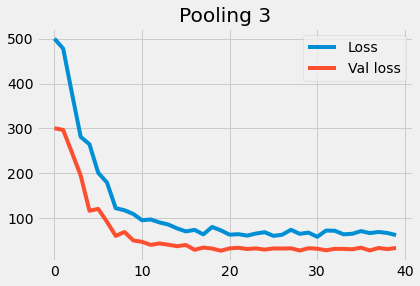

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.71it/s]


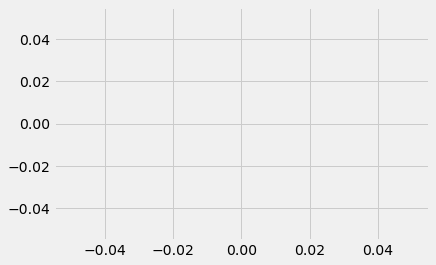

Epoch 1/1000
28/28 [==============================] - 1s 23ms/step - loss: 163.5304 - acc: 0.5787 - val_loss: 117.7323 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 150.6900 - acc: 0.5281 - val_loss: 73.1681 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 104.7728 - acc: 0.5247 - val_loss: 55.4507 - val_acc: 0.5225 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 103.2470 - acc: 0.4955 - val_loss: 41.7367 - val_acc: 0.4505 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 89.0910 - acc: 0.4966 - val_loss: 38.9096 - val_acc: 0.4955 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 71.5846 - acc: 0.4955 - val_loss: 32.9129 - val_acc: 0.5495 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 72.6468 

28/28 [==============================] - 0s 10ms/step - loss: 49.5581 - acc: 0.5910 - val_loss: 23.9280 - val_acc: 0.6847 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 10ms/step - loss: 59.3952 - acc: 0.5876 - val_loss: 23.9630 - val_acc: 0.6486 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 12ms/step - loss: 59.1446 - acc: 0.5899 - val_loss: 27.3725 - val_acc: 0.6036 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 10ms/step - loss: 52.0059 - acc: 0.6034 - val_loss: 19.8510 - val_acc: 0.6667 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 11ms/step - loss: 66.4424 - acc: 0.6000 - val_loss: 22.6587 - val_acc: 0.6577 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 11ms/step - loss: 55.8782 - acc: 0.6056 - val_loss: 24.2398 - val_acc: 0.6486 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 11ms/step - loss: 50.8822 - acc: 0.597

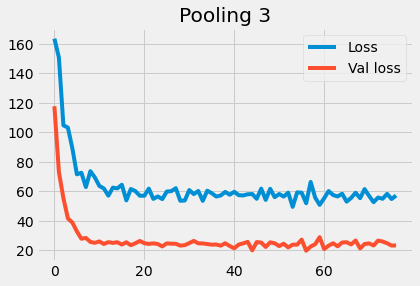

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.33it/s]


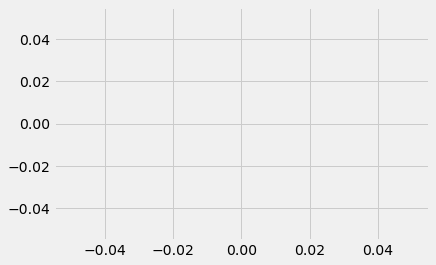

Epoch 1/1000
28/28 [==============================] - 2s 45ms/step - loss: 532.0699 - acc: 0.5112 - val_loss: 172.6017 - val_acc: 0.5315 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 312.0665 - acc: 0.5494 - val_loss: 119.7157 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 9ms/step - loss: 263.6979 - acc: 0.5876 - val_loss: 111.0090 - val_acc: 0.6847 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 243.4183 - acc: 0.5989 - val_loss: 63.2435 - val_acc: 0.7117 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 193.3135 - acc: 0.5899 - val_loss: 69.3233 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 12ms/step - loss: 220.5941 - acc: 0.6067 - val_loss: 59.5054 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 152.9

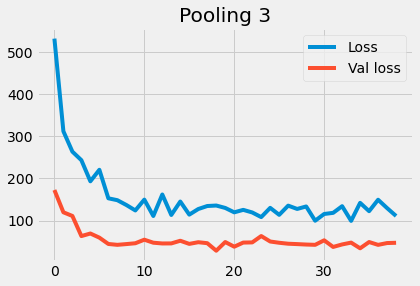

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.30it/s]


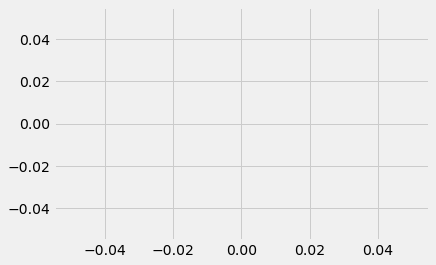

Epoch 1/1000
28/28 [==============================] - 1s 24ms/step - loss: 309.3347 - acc: 0.4034 - val_loss: 197.6223 - val_acc: 0.3423 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 12ms/step - loss: 206.7345 - acc: 0.4371 - val_loss: 115.5912 - val_acc: 0.3694 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 140.5446 - acc: 0.4562 - val_loss: 65.8139 - val_acc: 0.4595 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 123.6311 - acc: 0.4989 - val_loss: 34.3919 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 13ms/step - loss: 90.4143 - acc: 0.5539 - val_loss: 49.9475 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 84.1583 - acc: 0.5730 - val_loss: 38.7461 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 79.3431

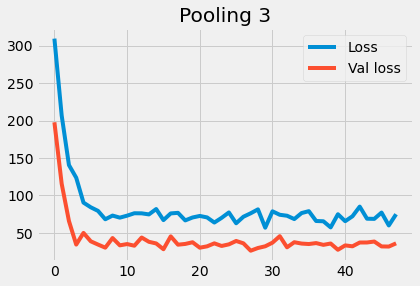

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.53it/s]


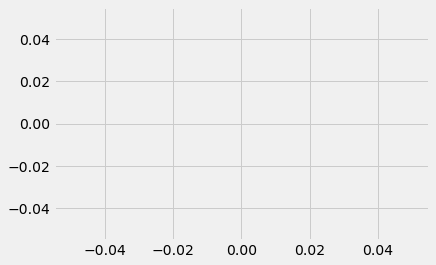

Epoch 1/1000
28/28 [==============================] - 2s 41ms/step - loss: 270.7171 - acc: 0.5685 - val_loss: 161.1383 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 12ms/step - loss: 165.8870 - acc: 0.6213 - val_loss: 145.4825 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 12ms/step - loss: 129.6119 - acc: 0.5753 - val_loss: 71.7035 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 101.3392 - acc: 0.6056 - val_loss: 55.5726 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 88.6327 - acc: 0.5730 - val_loss: 34.2238 - val_acc: 0.6847 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 81.7997 - acc: 0.6034 - val_loss: 33.3423 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 79.8802

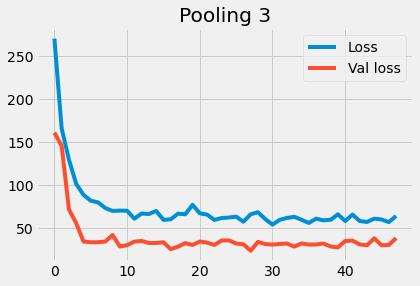

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.48it/s]


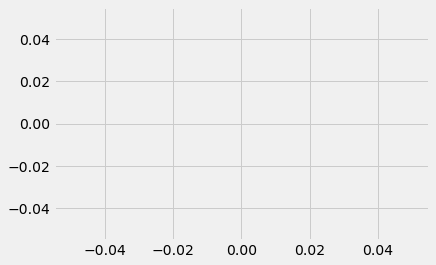

Epoch 1/1000
28/28 [==============================] - 1s 22ms/step - loss: 94.4400 - acc: 0.5652 - val_loss: 77.6964 - val_acc: 0.4324 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 9ms/step - loss: 77.1646 - acc: 0.6191 - val_loss: 59.6315 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 69.3422 - acc: 0.6404 - val_loss: 49.2423 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 65.7216 - acc: 0.6360 - val_loss: 44.2236 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 54.6888 - acc: 0.6584 - val_loss: 38.1909 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 12ms/step - loss: 57.6746 - acc: 0.6506 - val_loss: 34.5966 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 9ms/step - loss: 51.4895 - acc: 

Epoch 55/1000
28/28 [==============================] - 0s 11ms/step - loss: 37.2425 - acc: 0.6753 - val_loss: 29.3788 - val_acc: 0.6577 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 8ms/step - loss: 44.5434 - acc: 0.6461 - val_loss: 32.3458 - val_acc: 0.6216 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 10ms/step - loss: 36.5353 - acc: 0.6663 - val_loss: 29.1055 - val_acc: 0.6847 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 11ms/step - loss: 41.6876 - acc: 0.6674 - val_loss: 30.0266 - val_acc: 0.6667 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 9ms/step - loss: 40.3841 - acc: 0.6607 - val_loss: 28.4877 - val_acc: 0.6486 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 11ms/step - loss: 44.9973 - acc: 0.6461 - val_loss: 30.5125 - val_acc: 0.6216 - lr: 1.0000e-06
Epoch 61/1000
28/28 [==============================] - 0s 9ms/step - loss: 43.1197 -

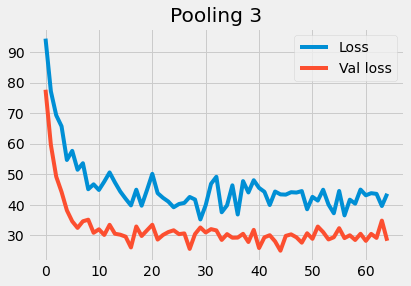

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.92it/s]


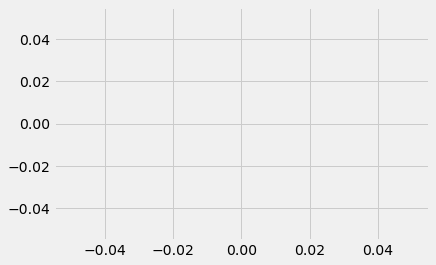

Epoch 1/1000
28/28 [==============================] - 2s 40ms/step - loss: 275.2048 - acc: 0.4180 - val_loss: 149.2576 - val_acc: 0.3784 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 188.5017 - acc: 0.4618 - val_loss: 77.5457 - val_acc: 0.4505 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 105.8017 - acc: 0.4899 - val_loss: 45.3056 - val_acc: 0.5495 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 97.7916 - acc: 0.5955 - val_loss: 49.2565 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 12ms/step - loss: 112.8011 - acc: 0.6157 - val_loss: 42.2706 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 83.4364 - acc: 0.6000 - val_loss: 35.5011 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 89.6814 

Epoch 55/1000
28/28 [==============================] - 0s 10ms/step - loss: 63.7507 - acc: 0.5944 - val_loss: 33.4165 - val_acc: 0.6667 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 11ms/step - loss: 84.6381 - acc: 0.6416 - val_loss: 29.4937 - val_acc: 0.6937 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 9ms/step - loss: 66.8120 - acc: 0.6326 - val_loss: 34.5315 - val_acc: 0.6306 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 11ms/step - loss: 92.6835 - acc: 0.6067 - val_loss: 31.2920 - val_acc: 0.6577 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 10ms/step - loss: 67.9553 - acc: 0.6236 - val_loss: 35.9495 - val_acc: 0.6396 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 12ms/step - loss: 69.8618 - acc: 0.6270 - val_loss: 24.4586 - val_acc: 0.6847 - lr: 1.0000e-06
Epoch 61/1000
28/28 [==============================] - 0s 9ms/step - loss: 71.6743 

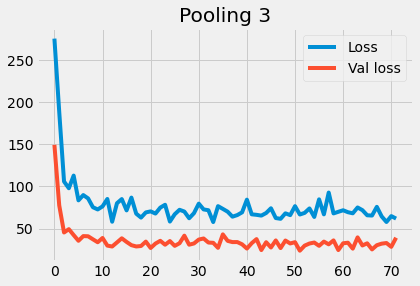

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.56it/s]


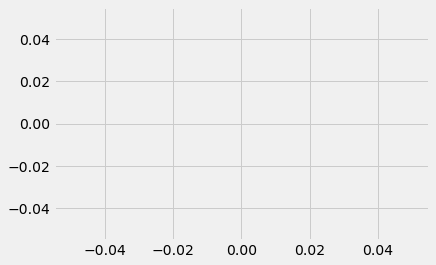

Epoch 1/1000
28/28 [==============================] - 2s 24ms/step - loss: 776.7956 - acc: 0.3933 - val_loss: 393.9613 - val_acc: 0.3784 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 599.5225 - acc: 0.4000 - val_loss: 288.5900 - val_acc: 0.3964 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 487.3628 - acc: 0.4146 - val_loss: 184.0252 - val_acc: 0.3874 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 356.7845 - acc: 0.4584 - val_loss: 113.1823 - val_acc: 0.4505 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 282.0991 - acc: 0.4798 - val_loss: 74.5565 - val_acc: 0.5225 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 233.1886 - acc: 0.5483 - val_loss: 59.4751 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 12ms/step - loss: 208

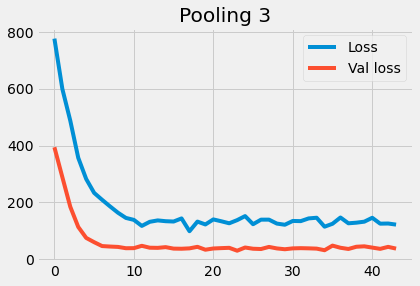

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.83it/s]


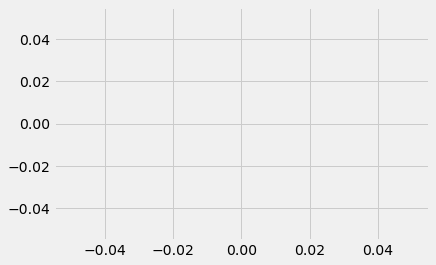

Epoch 1/1000
28/28 [==============================] - 2s 40ms/step - loss: 555.2029 - acc: 0.5843 - val_loss: 418.9277 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 418.3587 - acc: 0.6124 - val_loss: 339.0615 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 9ms/step - loss: 399.2940 - acc: 0.5854 - val_loss: 294.4018 - val_acc: 0.5856 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 13ms/step - loss: 331.0034 - acc: 0.5921 - val_loss: 218.0511 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 275.8872 - acc: 0.6090 - val_loss: 188.7116 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 211.5885 - acc: 0.5730 - val_loss: 140.6152 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 18

28/28 [==============================] - 0s 10ms/step - loss: 72.3074 - acc: 0.5573 - val_loss: 35.5613 - val_acc: 0.5766 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 11ms/step - loss: 69.5890 - acc: 0.5685 - val_loss: 42.6825 - val_acc: 0.5225 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 10ms/step - loss: 63.6674 - acc: 0.5820 - val_loss: 40.3287 - val_acc: 0.5315 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 13ms/step - loss: 69.9448 - acc: 0.5719 - val_loss: 38.3996 - val_acc: 0.5856 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 12ms/step - loss: 63.4887 - acc: 0.5674 - val_loss: 34.2769 - val_acc: 0.5856 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 10ms/step - loss: 64.7068 - acc: 0.5652 - val_loss: 34.7579 - val_acc: 0.6036 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 11ms/step - loss: 64.6502 - acc: 0.591

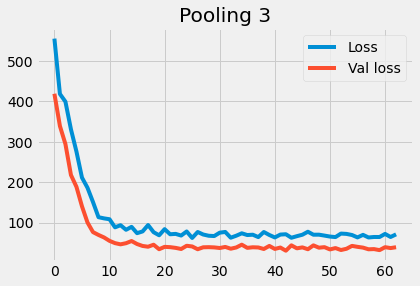

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.72it/s]


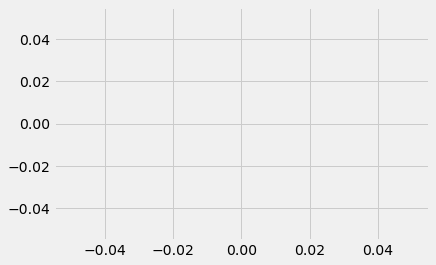

Epoch 1/1000
28/28 [==============================] - 1s 21ms/step - loss: 155.0152 - acc: 0.5562 - val_loss: 49.7905 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 113.9202 - acc: 0.6067 - val_loss: 43.1625 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 12ms/step - loss: 127.3057 - acc: 0.5674 - val_loss: 37.9206 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 123.7381 - acc: 0.5663 - val_loss: 28.9616 - val_acc: 0.7027 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 12ms/step - loss: 100.0219 - acc: 0.5820 - val_loss: 37.8728 - val_acc: 0.5856 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 107.6570 - acc: 0.5708 - val_loss: 31.5536 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 118.457

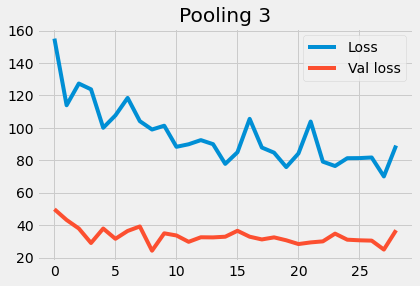

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.49it/s]


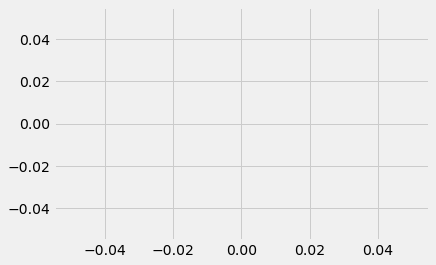

Epoch 1/1000
28/28 [==============================] - 2s 38ms/step - loss: 293.7393 - acc: 0.4461 - val_loss: 132.5459 - val_acc: 0.3604 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 150.6205 - acc: 0.5000 - val_loss: 48.8856 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 12ms/step - loss: 146.6838 - acc: 0.5640 - val_loss: 28.9531 - val_acc: 0.7658 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 108.2214 - acc: 0.5921 - val_loss: 39.4143 - val_acc: 0.7027 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 12ms/step - loss: 112.6052 - acc: 0.6079 - val_loss: 32.6270 - val_acc: 0.7477 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 13ms/step - loss: 106.6786 - acc: 0.6101 - val_loss: 36.7408 - val_acc: 0.6847 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 12ms/step - loss: 138.18

28/28 [==============================] - 0s 11ms/step - loss: 87.5634 - acc: 0.6180 - val_loss: 30.1463 - val_acc: 0.7297 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 11ms/step - loss: 82.1267 - acc: 0.6258 - val_loss: 27.7412 - val_acc: 0.7568 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 11ms/step - loss: 104.0655 - acc: 0.6157 - val_loss: 27.4386 - val_acc: 0.7387 - lr: 1.0000e-06


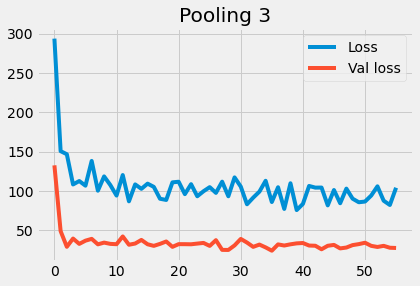

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.45it/s]


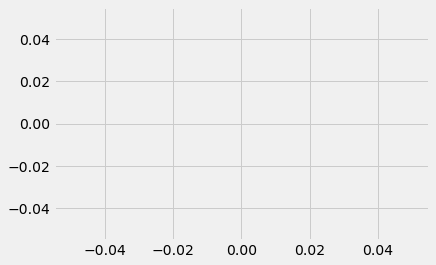

Epoch 1/1000
28/28 [==============================] - 1s 18ms/step - loss: 118.4963 - acc: 0.6034 - val_loss: 71.5576 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 9ms/step - loss: 87.2717 - acc: 0.6247 - val_loss: 71.5761 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 100.3424 - acc: 0.6258 - val_loss: 72.3062 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 88.1309 - acc: 0.6337 - val_loss: 52.6403 - val_acc: 0.7117 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 9ms/step - loss: 98.0004 - acc: 0.6236 - val_loss: 60.2417 - val_acc: 0.7027 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 86.3394 - acc: 0.6438 - val_loss: 55.1158 - val_acc: 0.7027 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 81.1047 - acc

Epoch 55/1000
28/28 [==============================] - 0s 10ms/step - loss: 63.1991 - acc: 0.6461 - val_loss: 29.7142 - val_acc: 0.7207 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 10ms/step - loss: 65.1331 - acc: 0.6146 - val_loss: 36.1901 - val_acc: 0.7117 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 9ms/step - loss: 60.0353 - acc: 0.6573 - val_loss: 38.5507 - val_acc: 0.6667 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 10ms/step - loss: 64.8121 - acc: 0.6719 - val_loss: 36.8966 - val_acc: 0.6847 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 9ms/step - loss: 56.2722 - acc: 0.6528 - val_loss: 41.6633 - val_acc: 0.6396 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 10ms/step - loss: 60.0687 - acc: 0.6596 - val_loss: 32.8687 - val_acc: 0.7207 - lr: 1.0000e-06
Epoch 61/1000
28/28 [==============================] - 0s 10ms/step - loss: 56.4657 

Epoch 109/1000
28/28 [==============================] - 0s 9ms/step - loss: 57.2014 - acc: 0.6573 - val_loss: 37.4359 - val_acc: 0.6577 - lr: 1.0000e-06
Epoch 110/1000
28/28 [==============================] - 0s 11ms/step - loss: 54.2456 - acc: 0.6775 - val_loss: 34.9644 - val_acc: 0.6757 - lr: 1.0000e-06
Epoch 111/1000
28/28 [==============================] - 0s 8ms/step - loss: 64.7301 - acc: 0.6337 - val_loss: 34.4968 - val_acc: 0.6667 - lr: 1.0000e-06
Epoch 112/1000
28/28 [==============================] - 0s 10ms/step - loss: 48.4223 - acc: 0.6831 - val_loss: 30.4307 - val_acc: 0.6847 - lr: 1.0000e-06


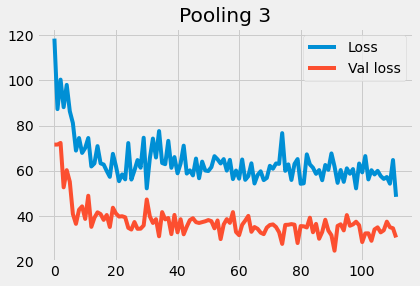

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.69it/s]


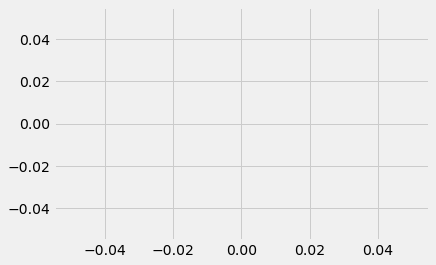

Epoch 1/1000
28/28 [==============================] - 2s 39ms/step - loss: 254.5749 - acc: 0.6303 - val_loss: 173.4747 - val_acc: 0.7027 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 204.1993 - acc: 0.6506 - val_loss: 142.5910 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 9ms/step - loss: 153.9399 - acc: 0.6213 - val_loss: 123.1456 - val_acc: 0.6847 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 130.4106 - acc: 0.6045 - val_loss: 87.8437 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 9ms/step - loss: 121.8822 - acc: 0.6090 - val_loss: 92.1553 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 9ms/step - loss: 106.4038 - acc: 0.5843 - val_loss: 75.0653 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 9ms/step - loss: 107.4160

Epoch 55/1000
28/28 [==============================] - 0s 9ms/step - loss: 85.6495 - acc: 0.5933 - val_loss: 48.8774 - val_acc: 0.6757 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 10ms/step - loss: 82.6408 - acc: 0.5831 - val_loss: 47.7086 - val_acc: 0.6667 - lr: 1.0000e-06


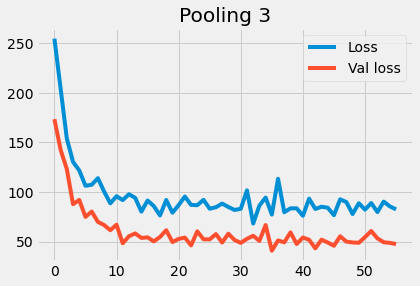

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.80it/s]


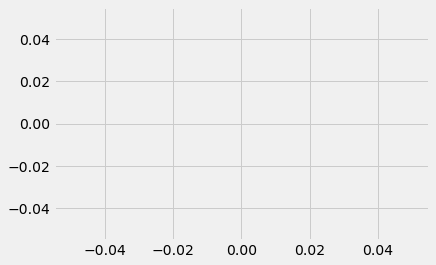

Epoch 1/1000
28/28 [==============================] - 1s 19ms/step - loss: 229.9880 - acc: 0.4787 - val_loss: 126.9993 - val_acc: 0.3784 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 162.9990 - acc: 0.5258 - val_loss: 75.5336 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 9ms/step - loss: 136.9388 - acc: 0.5764 - val_loss: 80.9447 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 126.1561 - acc: 0.5775 - val_loss: 68.7021 - val_acc: 0.6847 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 118.7060 - acc: 0.6112 - val_loss: 69.6298 - val_acc: 0.6847 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 115.1479 - acc: 0.6022 - val_loss: 62.4163 - val_acc: 0.7027 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 9ms/step - loss: 111.6376

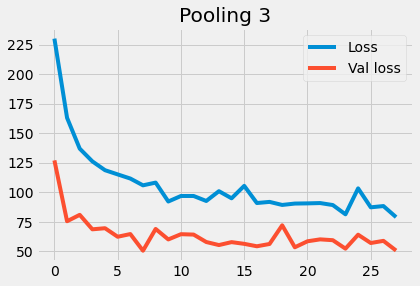

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.27it/s]


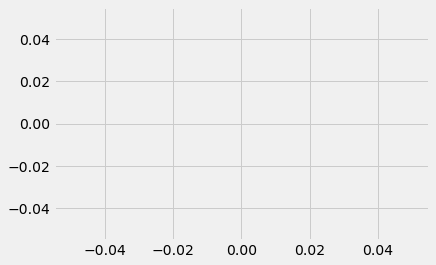

Epoch 1/1000
28/28 [==============================] - 2s 50ms/step - loss: 205.5681 - acc: 0.5989 - val_loss: 79.4818 - val_acc: 0.5856 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 13ms/step - loss: 150.6603 - acc: 0.6270 - val_loss: 76.0799 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 154.3873 - acc: 0.6315 - val_loss: 65.0699 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 14ms/step - loss: 136.4197 - acc: 0.6056 - val_loss: 57.3759 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 132.2610 - acc: 0.6056 - val_loss: 56.1195 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 13ms/step - loss: 120.0331 - acc: 0.6292 - val_loss: 55.5960 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 134.451

28/28 [==============================] - 0s 11ms/step - loss: 86.7372 - acc: 0.6213 - val_loss: 44.8122 - val_acc: 0.6396 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 12ms/step - loss: 93.7995 - acc: 0.6573 - val_loss: 51.4254 - val_acc: 0.6216 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 11ms/step - loss: 89.5870 - acc: 0.6135 - val_loss: 41.9054 - val_acc: 0.6486 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 10ms/step - loss: 83.9894 - acc: 0.6292 - val_loss: 42.5569 - val_acc: 0.6667 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 12ms/step - loss: 110.1493 - acc: 0.6090 - val_loss: 44.2782 - val_acc: 0.6306 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 9ms/step - loss: 106.1220 - acc: 0.6022 - val_loss: 44.7892 - val_acc: 0.6126 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 11ms/step - loss: 80.2846 - acc: 0.62

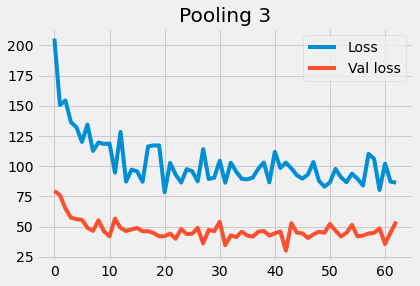

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.27it/s]


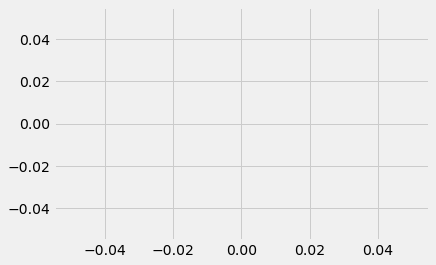

Epoch 1/1000
28/28 [==============================] - 1s 22ms/step - loss: 109.4869 - acc: 0.5697 - val_loss: 34.0757 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 12ms/step - loss: 104.7674 - acc: 0.5618 - val_loss: 24.7387 - val_acc: 0.6847 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 85.9076 - acc: 0.5775 - val_loss: 23.9150 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 73.8036 - acc: 0.6000 - val_loss: 21.3974 - val_acc: 0.7297 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 74.5208 - acc: 0.6022 - val_loss: 23.0042 - val_acc: 0.7027 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 69.1592 - acc: 0.6169 - val_loss: 26.2243 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 67.6475 - a

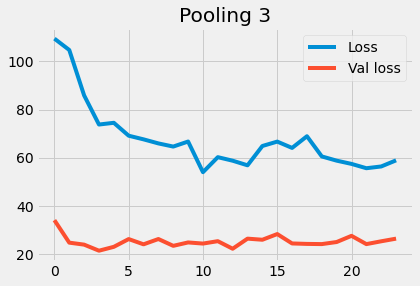

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.01it/s]


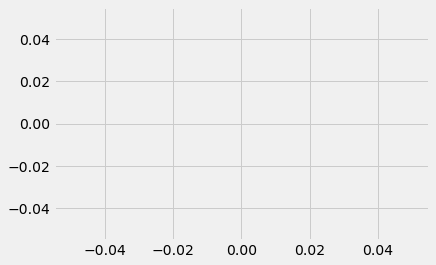

Epoch 1/1000
28/28 [==============================] - 2s 44ms/step - loss: 466.2773 - acc: 0.5708 - val_loss: 349.3929 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 358.5265 - acc: 0.5843 - val_loss: 281.4544 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 280.3884 - acc: 0.5787 - val_loss: 199.2960 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 9ms/step - loss: 216.4375 - acc: 0.5663 - val_loss: 143.4391 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 172.8563 - acc: 0.5551 - val_loss: 89.0903 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 154.8152 - acc: 0.5292 - val_loss: 61.8452 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 118.

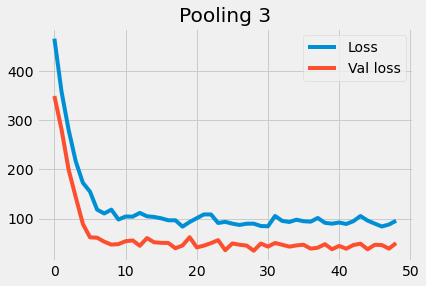

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.88it/s]


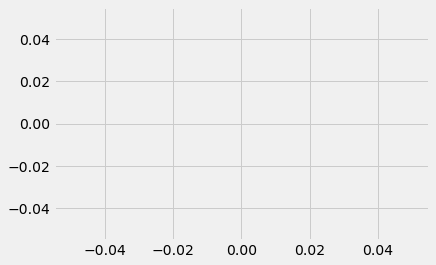

Epoch 1/1000
28/28 [==============================] - 1s 25ms/step - loss: 710.8032 - acc: 0.3989 - val_loss: 464.4031 - val_acc: 0.3604 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 539.2969 - acc: 0.3865 - val_loss: 317.1551 - val_acc: 0.3604 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 416.2108 - acc: 0.3820 - val_loss: 163.2779 - val_acc: 0.2883 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 13ms/step - loss: 291.8110 - acc: 0.4135 - val_loss: 86.4370 - val_acc: 0.4775 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 196.2014 - acc: 0.4506 - val_loss: 92.0817 - val_acc: 0.5676 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 160.4061 - acc: 0.4966 - val_loss: 77.9573 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 143.

28/28 [==============================] - 0s 11ms/step - loss: 65.6316 - acc: 0.6281 - val_loss: 42.4223 - val_acc: 0.5946 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 12ms/step - loss: 74.0567 - acc: 0.6236 - val_loss: 35.4314 - val_acc: 0.6306 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 11ms/step - loss: 69.1042 - acc: 0.6281 - val_loss: 53.2598 - val_acc: 0.5405 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 11ms/step - loss: 67.2184 - acc: 0.6180 - val_loss: 41.9835 - val_acc: 0.6126 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 11ms/step - loss: 69.9248 - acc: 0.6213 - val_loss: 42.9351 - val_acc: 0.5946 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 11ms/step - loss: 70.3237 - acc: 0.6045 - val_loss: 44.4280 - val_acc: 0.5586 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 11ms/step - loss: 64.9433 - acc: 0.611

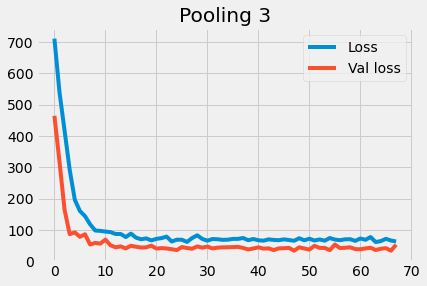

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.15it/s]


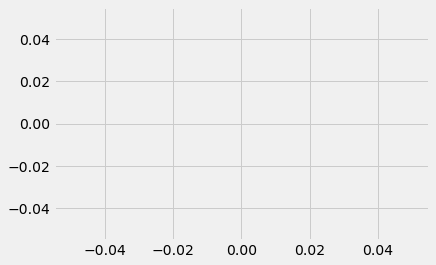

Epoch 1/1000
28/28 [==============================] - 2s 37ms/step - loss: 205.1675 - acc: 0.5393 - val_loss: 141.0375 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 9ms/step - loss: 165.6042 - acc: 0.5382 - val_loss: 114.4389 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 9ms/step - loss: 140.6019 - acc: 0.5674 - val_loss: 70.4718 - val_acc: 0.7117 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 114.2347 - acc: 0.5989 - val_loss: 83.6578 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 9ms/step - loss: 102.4987 - acc: 0.5719 - val_loss: 52.8751 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 9ms/step - loss: 92.3767 - acc: 0.5674 - val_loss: 38.5400 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 90.9653 - 

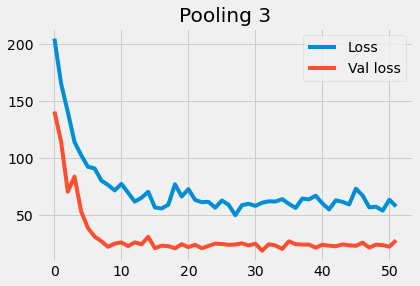

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.14it/s]


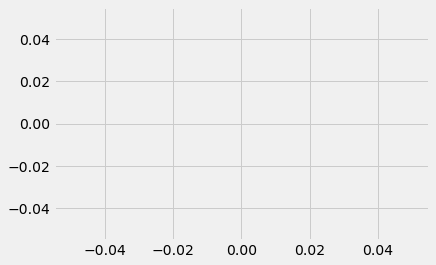

Epoch 1/1000
28/28 [==============================] - 1s 23ms/step - loss: 293.2887 - acc: 0.5865 - val_loss: 179.2465 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 9ms/step - loss: 224.3342 - acc: 0.5820 - val_loss: 140.1860 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 157.3199 - acc: 0.5865 - val_loss: 99.5931 - val_acc: 0.5405 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 111.8569 - acc: 0.5719 - val_loss: 48.5432 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 86.3413 - acc: 0.6191 - val_loss: 34.2147 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 80.1972 - acc: 0.6022 - val_loss: 32.6549 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 74.8526 

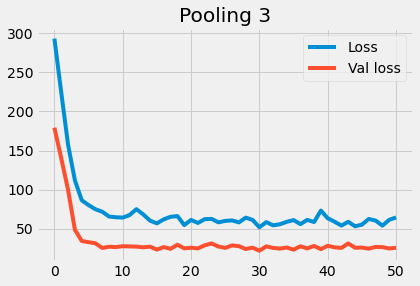

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.22it/s]


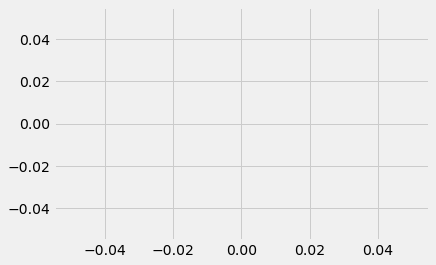

Epoch 1/1000
28/28 [==============================] - 2s 41ms/step - loss: 129.1064 - acc: 0.4438 - val_loss: 62.0501 - val_acc: 0.4865 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 90.8235 - acc: 0.5034 - val_loss: 48.4691 - val_acc: 0.5586 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 85.6866 - acc: 0.5337 - val_loss: 46.3369 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 76.6618 - acc: 0.5831 - val_loss: 41.4733 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 69.9905 - acc: 0.5551 - val_loss: 32.7895 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 71.7149 - acc: 0.5539 - val_loss: 28.3648 - val_acc: 0.7117 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 66.8501 - ac

28/28 [==============================] - 0s 11ms/step - loss: 55.4124 - acc: 0.6191 - val_loss: 30.3977 - val_acc: 0.7027 - lr: 1.0000e-06


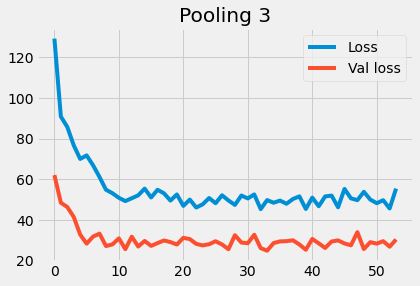

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.77it/s]


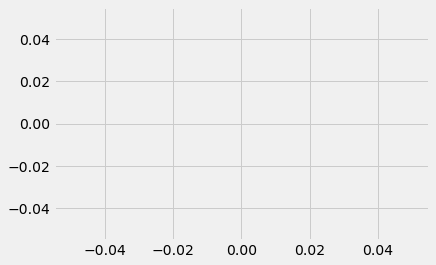

Epoch 1/1000
28/28 [==============================] - 1s 23ms/step - loss: 268.2027 - acc: 0.4022 - val_loss: 119.8108 - val_acc: 0.3874 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 168.7480 - acc: 0.4461 - val_loss: 66.0411 - val_acc: 0.3874 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 123.6505 - acc: 0.4685 - val_loss: 42.8668 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 101.1989 - acc: 0.5303 - val_loss: 36.6998 - val_acc: 0.5405 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 79.2063 - acc: 0.5551 - val_loss: 29.1827 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 69.1627 - acc: 0.5831 - val_loss: 28.1392 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 9ms/step - loss: 70.0541 -

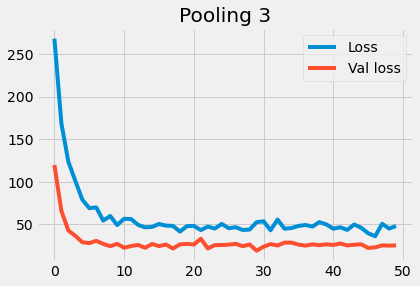

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.64it/s]


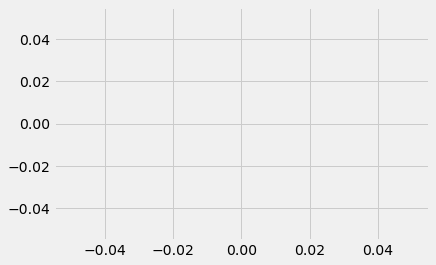

Epoch 1/1000
28/28 [==============================] - 2s 40ms/step - loss: 180.8342 - acc: 0.5539 - val_loss: 125.8947 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 149.1208 - acc: 0.5427 - val_loss: 100.5818 - val_acc: 0.5315 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 161.3111 - acc: 0.4989 - val_loss: 79.9432 - val_acc: 0.5405 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 124.5048 - acc: 0.5213 - val_loss: 68.6472 - val_acc: 0.5225 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 122.6551 - acc: 0.5169 - val_loss: 77.8848 - val_acc: 0.5135 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 106.3919 - acc: 0.5820 - val_loss: 61.7047 - val_acc: 0.5676 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 107.0

28/28 [==============================] - 0s 11ms/step - loss: 76.2251 - acc: 0.6000 - val_loss: 43.7900 - val_acc: 0.5586 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 11ms/step - loss: 76.7018 - acc: 0.6124 - val_loss: 42.6275 - val_acc: 0.5766 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 11ms/step - loss: 81.4378 - acc: 0.5921 - val_loss: 31.2646 - val_acc: 0.5946 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 11ms/step - loss: 70.0211 - acc: 0.6045 - val_loss: 42.3450 - val_acc: 0.5766 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 11ms/step - loss: 73.5195 - acc: 0.6180 - val_loss: 46.6594 - val_acc: 0.5676 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 11ms/step - loss: 78.6023 - acc: 0.6101 - val_loss: 43.8291 - val_acc: 0.5766 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 10ms/step - loss: 76.1156 - acc: 0.607

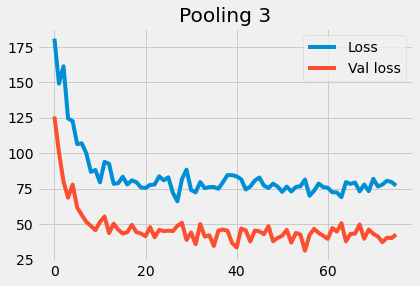

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.29it/s]


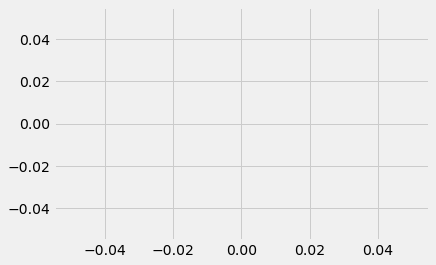

Epoch 1/1000
28/28 [==============================] - 1s 21ms/step - loss: 85.7531 - acc: 0.5427 - val_loss: 42.0859 - val_acc: 0.5856 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 97.4497 - acc: 0.5607 - val_loss: 45.3210 - val_acc: 0.5405 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 82.5264 - acc: 0.5393 - val_loss: 41.7380 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 85.3442 - acc: 0.5629 - val_loss: 39.6088 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 67.4070 - acc: 0.5719 - val_loss: 30.8869 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 70.8462 - acc: 0.5629 - val_loss: 32.9543 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 64.3442 - acc

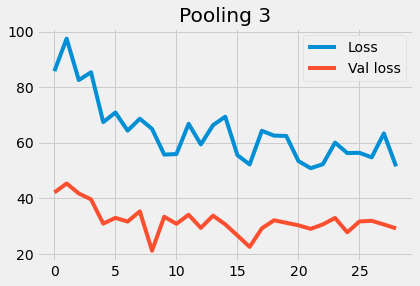

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.03it/s]


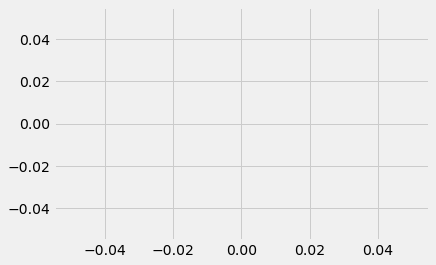

Epoch 1/1000
28/28 [==============================] - 2s 42ms/step - loss: 262.9760 - acc: 0.4820 - val_loss: 173.1395 - val_acc: 0.4775 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 183.5928 - acc: 0.5416 - val_loss: 107.3112 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 158.3792 - acc: 0.5809 - val_loss: 96.2602 - val_acc: 0.5676 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 9ms/step - loss: 129.1490 - acc: 0.6056 - val_loss: 72.6818 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 129.1901 - acc: 0.5685 - val_loss: 64.4994 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 114.1723 - acc: 0.5820 - val_loss: 51.2737 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 120.39

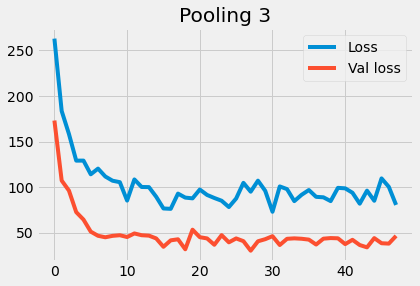

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.91it/s]


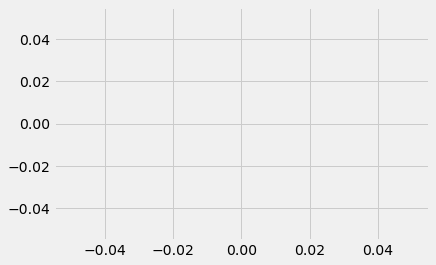

Epoch 1/1000
28/28 [==============================] - 1s 20ms/step - loss: 280.7845 - acc: 0.3506 - val_loss: 185.2392 - val_acc: 0.3514 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 207.9578 - acc: 0.4101 - val_loss: 137.7314 - val_acc: 0.3694 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 8ms/step - loss: 169.6576 - acc: 0.4247 - val_loss: 105.1612 - val_acc: 0.4054 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 9ms/step - loss: 138.5116 - acc: 0.4371 - val_loss: 62.9817 - val_acc: 0.5676 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 9ms/step - loss: 122.4254 - acc: 0.4775 - val_loss: 69.0490 - val_acc: 0.5495 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 105.5354 - acc: 0.5270 - val_loss: 56.1926 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 8ms/step - loss: 87.2582 

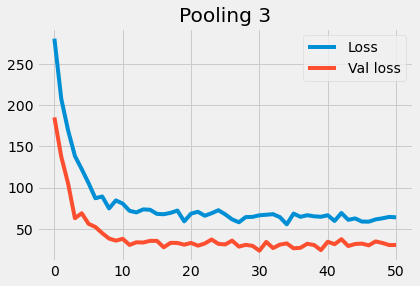

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.56it/s]


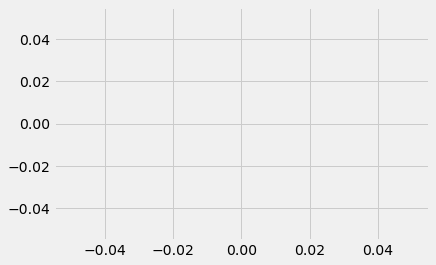

Epoch 1/1000
28/28 [==============================] - 2s 41ms/step - loss: 293.6779 - acc: 0.3539 - val_loss: 184.7217 - val_acc: 0.3243 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 230.4859 - acc: 0.3921 - val_loss: 142.4852 - val_acc: 0.3423 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 165.7406 - acc: 0.4449 - val_loss: 91.0014 - val_acc: 0.4234 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 119.2268 - acc: 0.4865 - val_loss: 69.1185 - val_acc: 0.5225 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 106.7182 - acc: 0.4888 - val_loss: 36.5189 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 95.3076 - acc: 0.5360 - val_loss: 41.6910 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 88.252

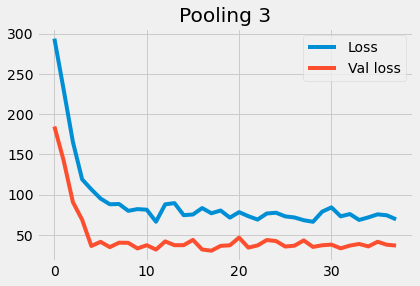

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.12it/s]


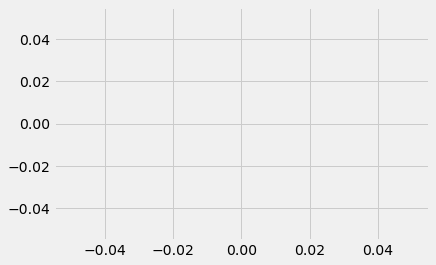

Epoch 1/1000
28/28 [==============================] - 1s 21ms/step - loss: 219.6742 - acc: 0.3910 - val_loss: 148.0491 - val_acc: 0.3514 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 148.9707 - acc: 0.4449 - val_loss: 85.5600 - val_acc: 0.3964 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 99.8348 - acc: 0.4921 - val_loss: 41.0633 - val_acc: 0.5586 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 105.8979 - acc: 0.5011 - val_loss: 39.3765 - val_acc: 0.5676 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 9ms/step - loss: 87.6883 - acc: 0.5506 - val_loss: 34.7840 - val_acc: 0.5586 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 81.2817 - acc: 0.5618 - val_loss: 28.3116 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 83.7575 - 

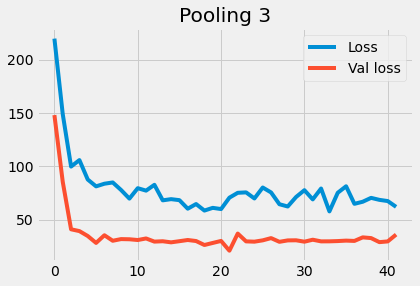

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.57it/s]


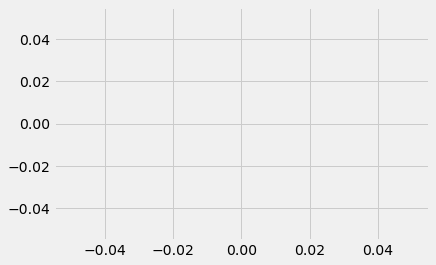

Epoch 1/1000
28/28 [==============================] - 2s 40ms/step - loss: 234.2698 - acc: 0.6045 - val_loss: 187.7780 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 183.8549 - acc: 0.6067 - val_loss: 136.9894 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 9ms/step - loss: 176.0891 - acc: 0.5393 - val_loss: 87.7224 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 9ms/step - loss: 146.3938 - acc: 0.5865 - val_loss: 61.5905 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 134.2963 - acc: 0.5539 - val_loss: 65.2690 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 130.4258 - acc: 0.6000 - val_loss: 66.4040 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 9ms/step - loss: 115.7312

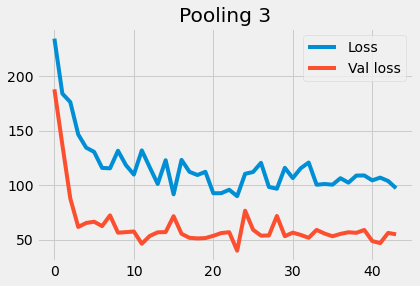

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.16it/s]


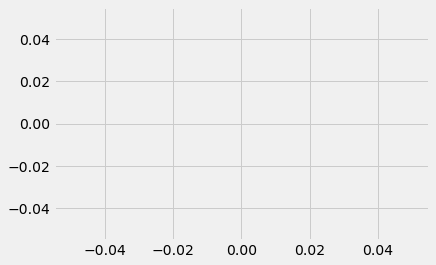

Epoch 1/1000
28/28 [==============================] - 1s 21ms/step - loss: 328.8189 - acc: 0.5933 - val_loss: 222.7194 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 263.4423 - acc: 0.5764 - val_loss: 167.4541 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 9ms/step - loss: 189.2302 - acc: 0.5854 - val_loss: 126.3418 - val_acc: 0.5405 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 142.6217 - acc: 0.5135 - val_loss: 101.9324 - val_acc: 0.4955 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 134.9826 - acc: 0.4966 - val_loss: 104.6774 - val_acc: 0.4505 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 9ms/step - loss: 100.8268 - acc: 0.4933 - val_loss: 84.4265 - val_acc: 0.4414 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 92.5

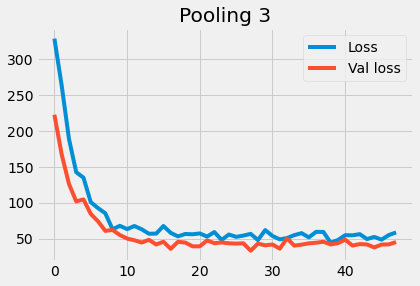

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.26it/s]


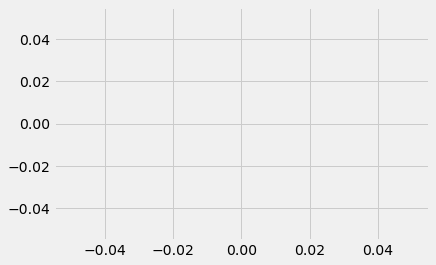

Epoch 1/1000
28/28 [==============================] - 2s 42ms/step - loss: 98.4361 - acc: 0.5517 - val_loss: 32.0516 - val_acc: 0.5495 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 79.4033 - acc: 0.5596 - val_loss: 31.4292 - val_acc: 0.5225 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 65.2077 - acc: 0.5831 - val_loss: 30.4687 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 64.5891 - acc: 0.5865 - val_loss: 29.0357 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 62.4046 - acc: 0.5697 - val_loss: 29.4089 - val_acc: 0.5495 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 56.4101 - acc: 0.6090 - val_loss: 25.6831 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 65.2543 - acc

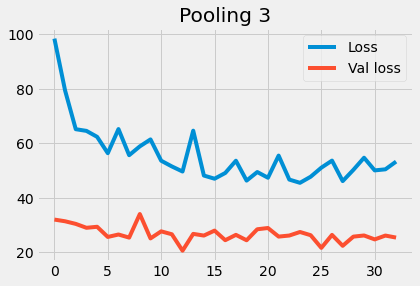

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.83it/s]


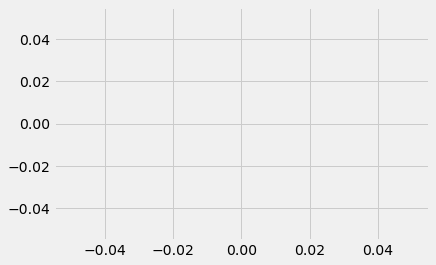

Epoch 1/1000
28/28 [==============================] - 1s 22ms/step - loss: 618.5197 - acc: 0.5955 - val_loss: 460.2639 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 528.4837 - acc: 0.6045 - val_loss: 415.7576 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 473.5910 - acc: 0.6011 - val_loss: 325.6449 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 379.5456 - acc: 0.6000 - val_loss: 211.9428 - val_acc: 0.6937 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 327.3088 - acc: 0.6022 - val_loss: 220.7580 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 255.7047 - acc: 0.6067 - val_loss: 159.9552 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 2

28/28 [==============================] - 0s 10ms/step - loss: 116.3591 - acc: 0.5652 - val_loss: 68.6923 - val_acc: 0.5225 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 9ms/step - loss: 121.3226 - acc: 0.5663 - val_loss: 60.8463 - val_acc: 0.5225 - lr: 1.0000e-06


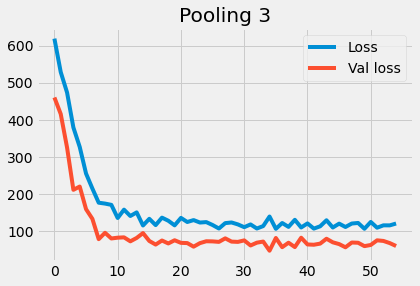

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.76it/s]


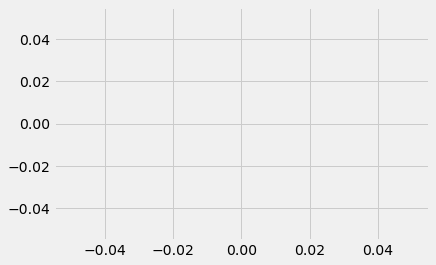

Epoch 1/1000
28/28 [==============================] - 2s 43ms/step - loss: 423.1467 - acc: 0.3685 - val_loss: 181.1462 - val_acc: 0.3153 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 232.7249 - acc: 0.4506 - val_loss: 77.3223 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 195.3238 - acc: 0.5112 - val_loss: 65.1111 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 148.7669 - acc: 0.5438 - val_loss: 48.8145 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 145.0326 - acc: 0.5876 - val_loss: 47.3799 - val_acc: 0.6937 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 147.5720 - acc: 0.5775 - val_loss: 50.2004 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 114.24

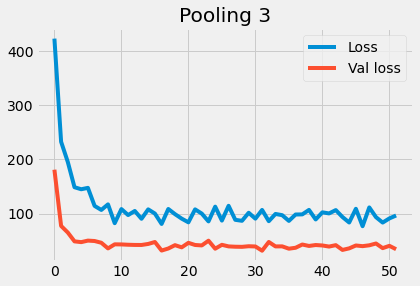

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.52it/s]


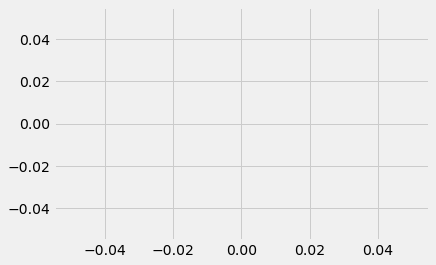

Epoch 1/1000
28/28 [==============================] - 1s 21ms/step - loss: 112.0237 - acc: 0.4910 - val_loss: 37.6621 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 97.7699 - acc: 0.5360 - val_loss: 38.1894 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 9ms/step - loss: 72.9877 - acc: 0.5831 - val_loss: 38.1136 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 80.9923 - acc: 0.6191 - val_loss: 34.2989 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 70.4161 - acc: 0.6112 - val_loss: 29.0867 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 66.5587 - acc: 0.6303 - val_loss: 34.9166 - val_acc: 0.6937 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 66.1683 - acc

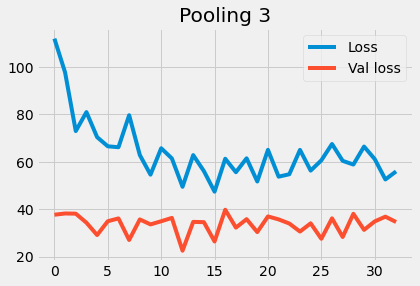

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.09it/s]


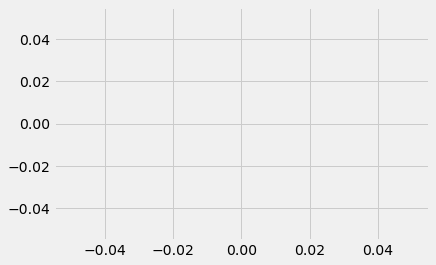

Epoch 1/1000
28/28 [==============================] - 2s 38ms/step - loss: 161.3429 - acc: 0.4607 - val_loss: 53.6055 - val_acc: 0.4595 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 9ms/step - loss: 130.1152 - acc: 0.5146 - val_loss: 41.6238 - val_acc: 0.5856 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 130.9531 - acc: 0.5270 - val_loss: 43.4780 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 113.8629 - acc: 0.5742 - val_loss: 38.6942 - val_acc: 0.5315 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 124.6818 - acc: 0.5528 - val_loss: 40.7020 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 9ms/step - loss: 101.4487 - acc: 0.6169 - val_loss: 38.9027 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 98.4891 -

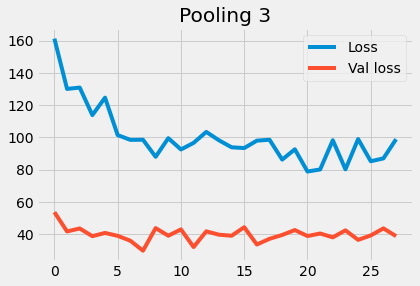

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.39it/s]


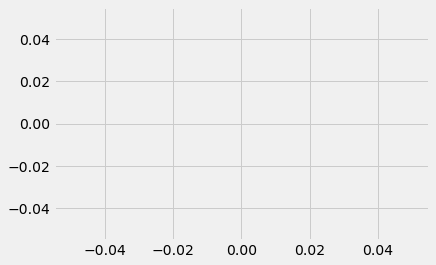

Epoch 1/1000
28/28 [==============================] - 1s 19ms/step - loss: 370.4559 - acc: 0.4528 - val_loss: 211.4811 - val_acc: 0.4955 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 287.4362 - acc: 0.5393 - val_loss: 159.1276 - val_acc: 0.5586 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 244.1332 - acc: 0.5607 - val_loss: 122.1516 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 201.6148 - acc: 0.5865 - val_loss: 93.9574 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 175.9743 - acc: 0.5899 - val_loss: 76.0669 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 159.4634 - acc: 0.5843 - val_loss: 52.8139 - val_acc: 0.6847 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 9ms/step - loss: 133.8

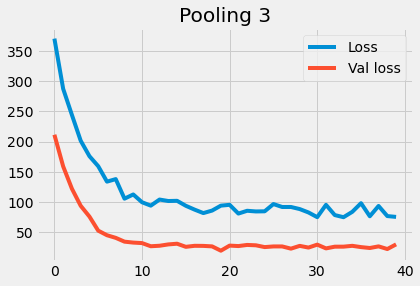

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.31it/s]


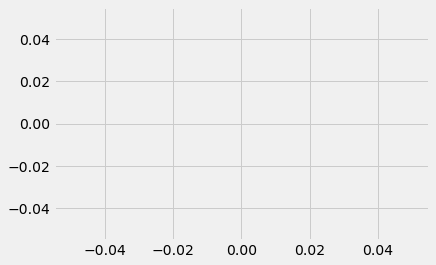

Epoch 1/1000
28/28 [==============================] - 2s 42ms/step - loss: 130.2804 - acc: 0.5843 - val_loss: 73.3378 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 145.2185 - acc: 0.5652 - val_loss: 69.2345 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 133.8564 - acc: 0.5472 - val_loss: 59.6841 - val_acc: 0.7027 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 130.9147 - acc: 0.5596 - val_loss: 63.3600 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 119.3682 - acc: 0.5730 - val_loss: 41.2082 - val_acc: 0.6937 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 104.4615 - acc: 0.5551 - val_loss: 35.8342 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 87.8212

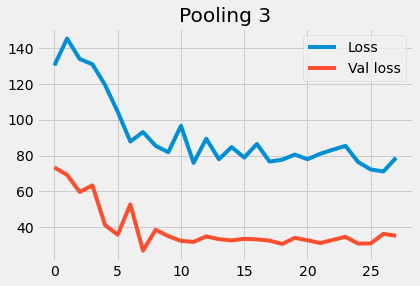

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.13it/s]


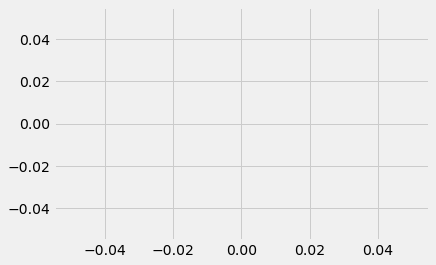

Epoch 1/1000
28/28 [==============================] - 1s 24ms/step - loss: 621.7111 - acc: 0.4112 - val_loss: 367.8876 - val_acc: 0.3694 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 12ms/step - loss: 489.8068 - acc: 0.4157 - val_loss: 211.6714 - val_acc: 0.3784 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 282.7687 - acc: 0.4146 - val_loss: 110.9752 - val_acc: 0.4865 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 12ms/step - loss: 188.7621 - acc: 0.5270 - val_loss: 55.2346 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 163.6014 - acc: 0.5517 - val_loss: 47.7870 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 113.5788 - acc: 0.5775 - val_loss: 39.2490 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 88.1

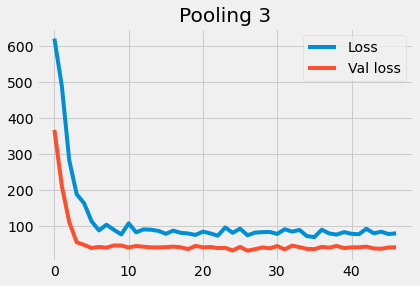

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.80it/s]


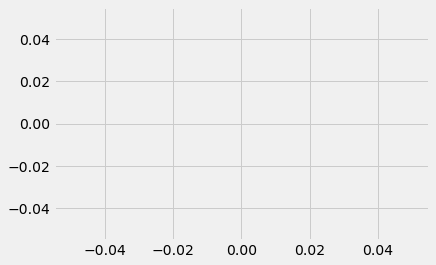

Epoch 1/1000
28/28 [==============================] - 2s 41ms/step - loss: 280.8000 - acc: 0.6124 - val_loss: 226.7054 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 242.4182 - acc: 0.6124 - val_loss: 144.0280 - val_acc: 0.6847 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 12ms/step - loss: 167.5336 - acc: 0.6562 - val_loss: 123.1000 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 138.0081 - acc: 0.6146 - val_loss: 91.2875 - val_acc: 0.6847 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 125.5010 - acc: 0.6011 - val_loss: 80.9376 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 96.0632 - acc: 0.5876 - val_loss: 56.6437 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 84.52

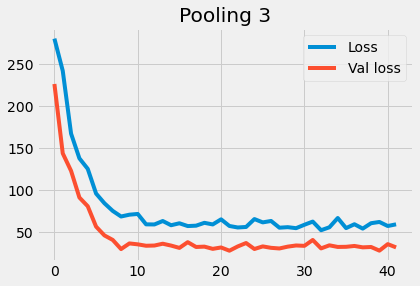

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.63it/s]


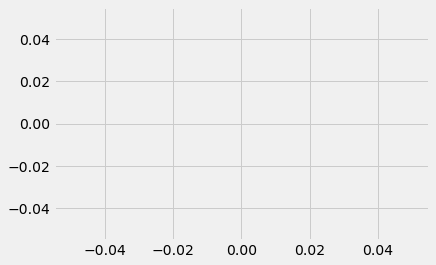

Epoch 1/1000
28/28 [==============================] - 1s 24ms/step - loss: 298.7650 - acc: 0.5989 - val_loss: 190.5792 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 216.3068 - acc: 0.6146 - val_loss: 131.1781 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 171.3718 - acc: 0.6360 - val_loss: 115.4221 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 144.8421 - acc: 0.6090 - val_loss: 91.3691 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 153.5685 - acc: 0.5989 - val_loss: 77.6756 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 119.1292 - acc: 0.6146 - val_loss: 78.7352 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 127.

28/28 [==============================] - 0s 11ms/step - loss: 88.4953 - acc: 0.6528 - val_loss: 56.6971 - val_acc: 0.6396 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 10ms/step - loss: 93.9928 - acc: 0.6404 - val_loss: 50.1517 - val_acc: 0.6667 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 10ms/step - loss: 84.8702 - acc: 0.6685 - val_loss: 52.2267 - val_acc: 0.6486 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 11ms/step - loss: 92.0169 - acc: 0.6213 - val_loss: 57.0199 - val_acc: 0.6486 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 11ms/step - loss: 90.4043 - acc: 0.6596 - val_loss: 58.2833 - val_acc: 0.6396 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 10ms/step - loss: 94.8971 - acc: 0.6528 - val_loss: 58.1484 - val_acc: 0.6667 - lr: 1.0000e-06


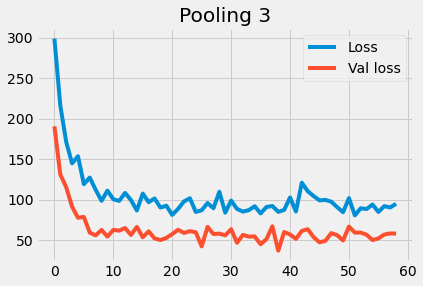

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.77it/s]


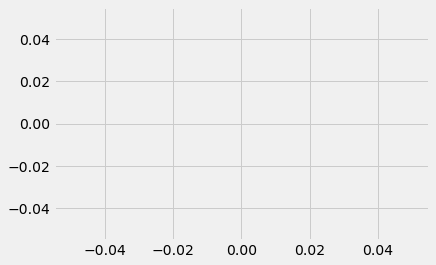

Epoch 1/1000
28/28 [==============================] - 2s 43ms/step - loss: 285.6229 - acc: 0.5270 - val_loss: 142.7183 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 207.8606 - acc: 0.5562 - val_loss: 111.5649 - val_acc: 0.5676 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 173.5228 - acc: 0.6000 - val_loss: 103.5261 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 12ms/step - loss: 150.1691 - acc: 0.6146 - val_loss: 73.1745 - val_acc: 0.7117 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 129.3823 - acc: 0.6180 - val_loss: 78.6824 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 132.3428 - acc: 0.6034 - val_loss: 69.0709 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 123.

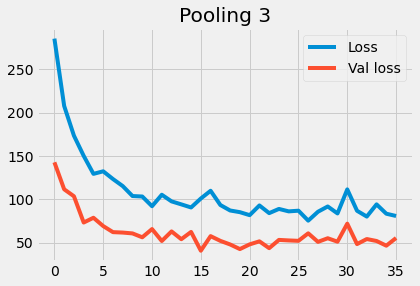

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.85it/s]


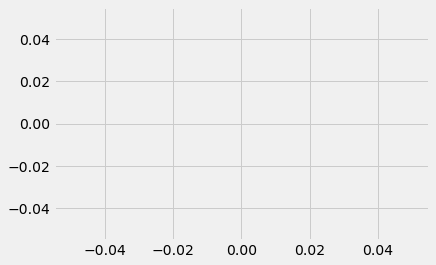

Epoch 1/1000
28/28 [==============================] - 1s 21ms/step - loss: 706.6321 - acc: 0.3596 - val_loss: 569.1328 - val_acc: 0.3243 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 583.6641 - acc: 0.3573 - val_loss: 409.3866 - val_acc: 0.3333 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 461.6619 - acc: 0.3539 - val_loss: 292.9769 - val_acc: 0.3694 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 330.9732 - acc: 0.3888 - val_loss: 208.4283 - val_acc: 0.3153 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 228.8172 - acc: 0.4596 - val_loss: 139.3709 - val_acc: 0.5495 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 176.6224 - acc: 0.4843 - val_loss: 116.2843 - val_acc: 0.5676 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 1

28/28 [==============================] - 0s 11ms/step - loss: 75.6269 - acc: 0.6494 - val_loss: 39.6314 - val_acc: 0.6126 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 10ms/step - loss: 76.8227 - acc: 0.6236 - val_loss: 50.4054 - val_acc: 0.5856 - lr: 1.0000e-06


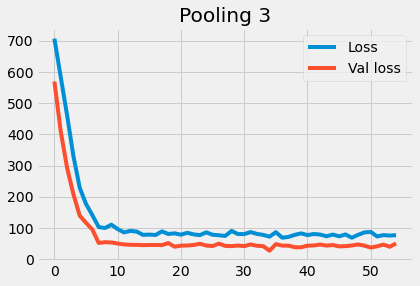

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.35it/s]


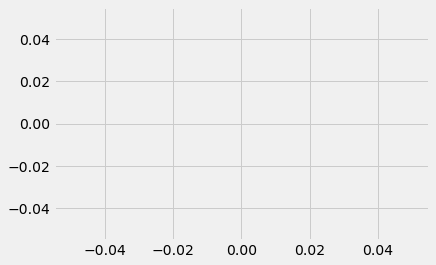

Epoch 1/1000
28/28 [==============================] - 2s 43ms/step - loss: 292.4652 - acc: 0.5292 - val_loss: 158.7954 - val_acc: 0.5135 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 226.7866 - acc: 0.5135 - val_loss: 110.9176 - val_acc: 0.5045 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 188.9106 - acc: 0.5225 - val_loss: 85.6656 - val_acc: 0.5856 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 175.0505 - acc: 0.5753 - val_loss: 73.4145 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 160.8024 - acc: 0.5798 - val_loss: 48.3098 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 9ms/step - loss: 146.6994 - acc: 0.5798 - val_loss: 59.3252 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 122.90

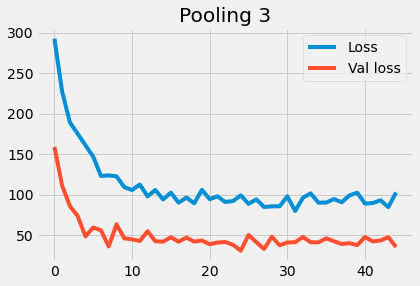

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.83it/s]


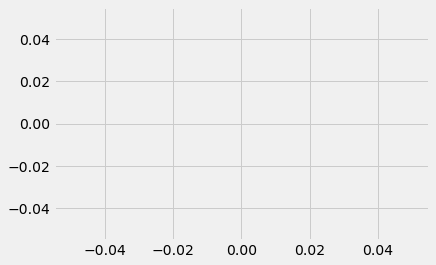

Epoch 1/1000
28/28 [==============================] - 1s 24ms/step - loss: 395.9437 - acc: 0.4000 - val_loss: 134.6289 - val_acc: 0.2973 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 285.9447 - acc: 0.4056 - val_loss: 94.6857 - val_acc: 0.4955 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 228.4542 - acc: 0.4337 - val_loss: 73.5764 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 12ms/step - loss: 214.7654 - acc: 0.4742 - val_loss: 88.4910 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 203.0713 - acc: 0.4865 - val_loss: 90.6584 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 176.4954 - acc: 0.4708 - val_loss: 73.8502 - val_acc: 0.7027 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 159.62

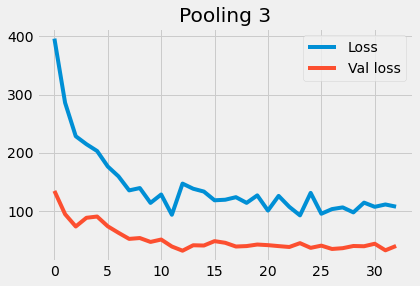

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.86it/s]


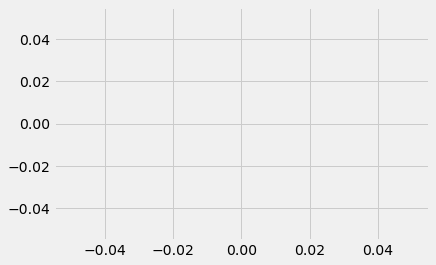

Epoch 1/1000
28/28 [==============================] - 2s 37ms/step - loss: 198.1151 - acc: 0.4135 - val_loss: 112.5093 - val_acc: 0.4414 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 123.3487 - acc: 0.5202 - val_loss: 77.0883 - val_acc: 0.5135 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 94.3340 - acc: 0.5865 - val_loss: 54.9510 - val_acc: 0.5135 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 77.7137 - acc: 0.6067 - val_loss: 49.0630 - val_acc: 0.5495 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 85.8858 - acc: 0.6000 - val_loss: 47.4206 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 69.4714 - acc: 0.6202 - val_loss: 46.9038 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 71.0708 - 

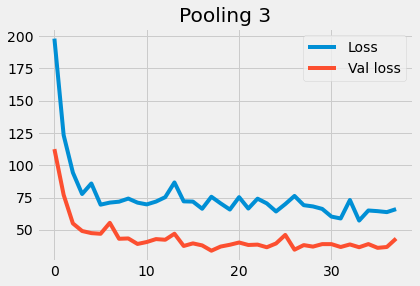

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.20it/s]


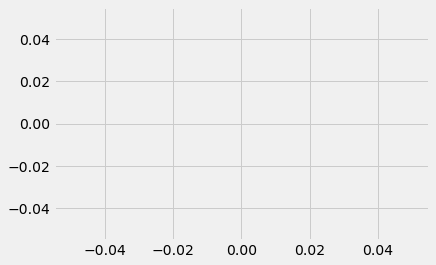

Epoch 1/1000
28/28 [==============================] - 1s 26ms/step - loss: 148.0992 - acc: 0.5404 - val_loss: 59.3146 - val_acc: 0.5856 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 131.8385 - acc: 0.5371 - val_loss: 57.7625 - val_acc: 0.5405 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 104.6913 - acc: 0.5562 - val_loss: 44.9812 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 95.8584 - acc: 0.5461 - val_loss: 43.6117 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 97.0653 - acc: 0.5562 - val_loss: 39.9334 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 82.7145 - acc: 0.5674 - val_loss: 40.4514 - val_acc: 0.5586 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 87.9247 - 

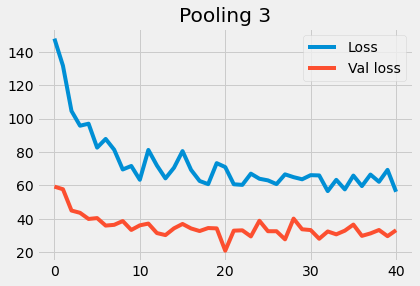

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.45it/s]


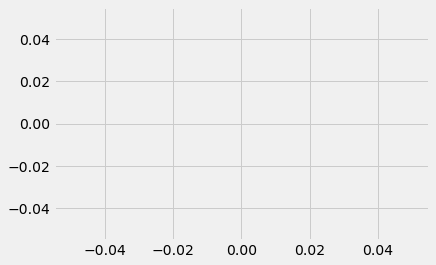

Epoch 1/1000
28/28 [==============================] - 2s 39ms/step - loss: 412.0191 - acc: 0.4011 - val_loss: 260.5653 - val_acc: 0.4234 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 292.1191 - acc: 0.4494 - val_loss: 195.1770 - val_acc: 0.4414 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 254.0198 - acc: 0.4753 - val_loss: 136.9951 - val_acc: 0.5405 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 200.2794 - acc: 0.5056 - val_loss: 110.9110 - val_acc: 0.5676 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 179.7044 - acc: 0.5371 - val_loss: 78.2510 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 161.2093 - acc: 0.5742 - val_loss: 63.1594 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 138

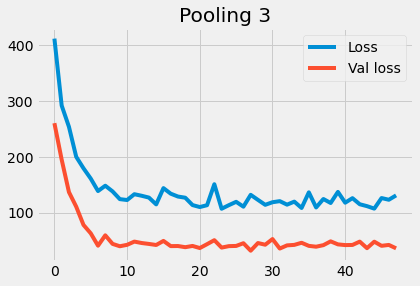

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.33it/s]


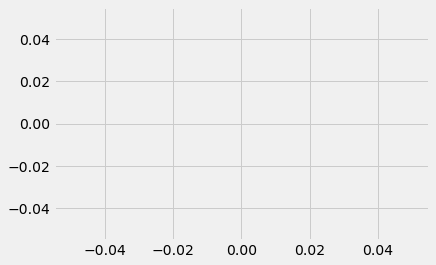

Epoch 1/1000
28/28 [==============================] - 1s 23ms/step - loss: 201.4457 - acc: 0.5112 - val_loss: 138.1525 - val_acc: 0.4955 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 156.9660 - acc: 0.5472 - val_loss: 94.2219 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 114.1312 - acc: 0.6011 - val_loss: 78.7805 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 93.3960 - acc: 0.6213 - val_loss: 61.8777 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 75.7156 - acc: 0.6506 - val_loss: 46.0998 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 67.2317 - acc: 0.6483 - val_loss: 41.3924 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 60.2111 -

28/28 [==============================] - 0s 11ms/step - loss: 45.8283 - acc: 0.6596 - val_loss: 29.2931 - val_acc: 0.6577 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 10ms/step - loss: 44.9125 - acc: 0.6730 - val_loss: 32.0663 - val_acc: 0.6667 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 11ms/step - loss: 46.2346 - acc: 0.6910 - val_loss: 32.2296 - val_acc: 0.6577 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 10ms/step - loss: 45.5526 - acc: 0.6506 - val_loss: 29.1616 - val_acc: 0.6667 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 10ms/step - loss: 49.6185 - acc: 0.6528 - val_loss: 29.5497 - val_acc: 0.6577 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 11ms/step - loss: 43.5028 - acc: 0.6719 - val_loss: 33.6827 - val_acc: 0.6757 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 11ms/step - loss: 44.8842 - acc: 0.662

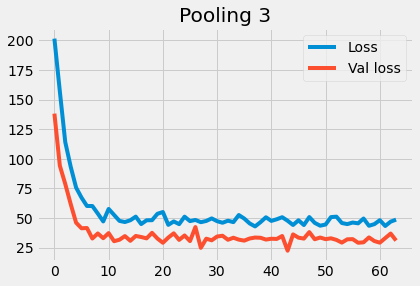

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.12it/s]


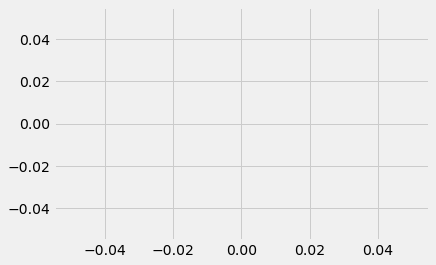

Epoch 1/1000
28/28 [==============================] - 2s 41ms/step - loss: 329.2314 - acc: 0.3921 - val_loss: 125.5337 - val_acc: 0.4685 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 232.6442 - acc: 0.4303 - val_loss: 86.9719 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 176.1192 - acc: 0.5067 - val_loss: 91.2193 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 146.8254 - acc: 0.5281 - val_loss: 59.6397 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 132.9916 - acc: 0.5461 - val_loss: 53.8520 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 103.9862 - acc: 0.5978 - val_loss: 45.9242 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 112.57

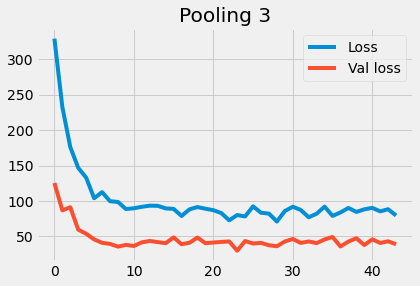

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.71it/s]


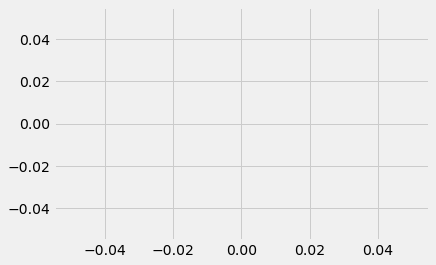

Epoch 1/1000
28/28 [==============================] - 1s 22ms/step - loss: 139.5496 - acc: 0.4775 - val_loss: 92.3649 - val_acc: 0.4505 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 115.9941 - acc: 0.5011 - val_loss: 60.4062 - val_acc: 0.5045 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 87.7636 - acc: 0.5685 - val_loss: 53.1140 - val_acc: 0.5495 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 87.9035 - acc: 0.5876 - val_loss: 41.0572 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 87.3615 - acc: 0.5944 - val_loss: 38.4572 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 77.6309 - acc: 0.6124 - val_loss: 37.2425 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 81.0611 - a

28/28 [==============================] - 0s 10ms/step - loss: 65.5492 - acc: 0.6360 - val_loss: 35.2687 - val_acc: 0.6577 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 10ms/step - loss: 79.9241 - acc: 0.6247 - val_loss: 35.2276 - val_acc: 0.6126 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 11ms/step - loss: 64.7376 - acc: 0.6472 - val_loss: 30.4440 - val_acc: 0.6577 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 10ms/step - loss: 61.2649 - acc: 0.6213 - val_loss: 34.4679 - val_acc: 0.6306 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 11ms/step - loss: 66.4924 - acc: 0.6236 - val_loss: 33.3540 - val_acc: 0.6577 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 11ms/step - loss: 60.5674 - acc: 0.6461 - val_loss: 38.6915 - val_acc: 0.6216 - lr: 1.0000e-06


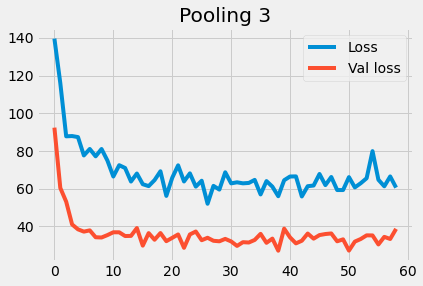

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.28it/s]


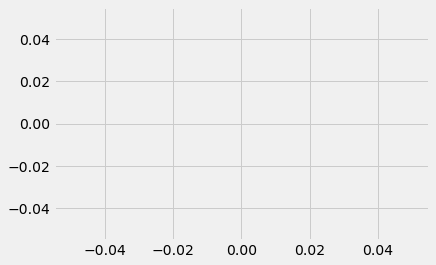

Epoch 1/1000
28/28 [==============================] - 2s 42ms/step - loss: 154.8476 - acc: 0.6045 - val_loss: 70.2381 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 153.2096 - acc: 0.5742 - val_loss: 79.2953 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 125.0548 - acc: 0.5955 - val_loss: 65.5767 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 115.8146 - acc: 0.5921 - val_loss: 50.7134 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 9ms/step - loss: 101.3439 - acc: 0.5742 - val_loss: 44.1885 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 110.6768 - acc: 0.5820 - val_loss: 47.7991 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 97.7903 

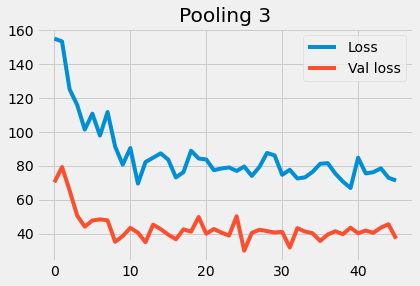

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.87it/s]


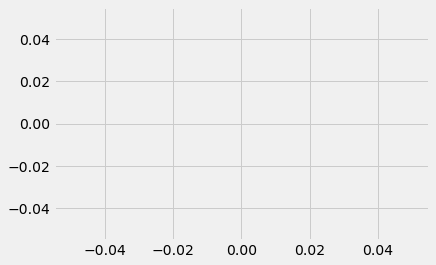

Epoch 1/1000
28/28 [==============================] - 1s 21ms/step - loss: 116.4428 - acc: 0.5573 - val_loss: 50.7495 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 96.6632 - acc: 0.5966 - val_loss: 53.7613 - val_acc: 0.5495 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 91.0612 - acc: 0.5955 - val_loss: 37.3339 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 92.9039 - acc: 0.5719 - val_loss: 35.7353 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 91.9603 - acc: 0.5888 - val_loss: 35.4999 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 71.8753 - acc: 0.6281 - val_loss: 31.5737 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 75.1789 - ac

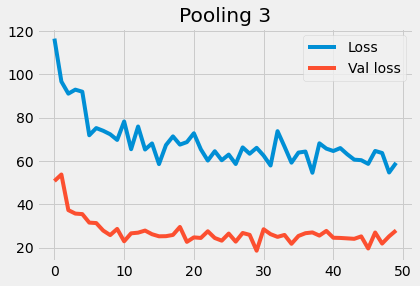

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.11it/s]


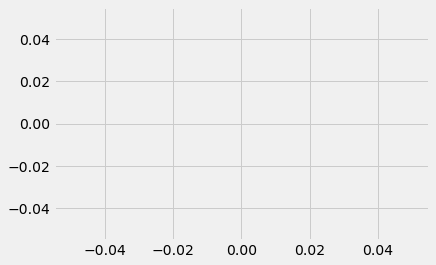

Epoch 1/1000
28/28 [==============================] - 2s 43ms/step - loss: 225.8219 - acc: 0.5270 - val_loss: 107.1022 - val_acc: 0.5315 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 147.9621 - acc: 0.5764 - val_loss: 77.3669 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 151.9949 - acc: 0.5640 - val_loss: 53.5842 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 104.3550 - acc: 0.5876 - val_loss: 43.3735 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 108.9129 - acc: 0.5899 - val_loss: 38.5916 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 97.5963 - acc: 0.6045 - val_loss: 32.8597 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 95.3974

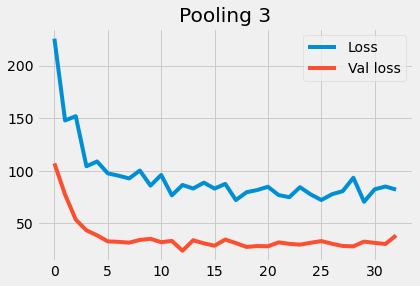

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.52it/s]


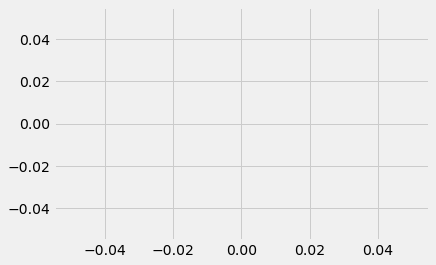

Epoch 1/1000
28/28 [==============================] - 1s 23ms/step - loss: 143.1958 - acc: 0.5056 - val_loss: 55.8445 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 127.1233 - acc: 0.5438 - val_loss: 48.8000 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 108.6769 - acc: 0.5371 - val_loss: 51.8441 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 100.5486 - acc: 0.5629 - val_loss: 41.2053 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 105.8934 - acc: 0.5944 - val_loss: 43.8190 - val_acc: 0.5766 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 92.5071 - acc: 0.5933 - val_loss: 42.0919 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 83.9168 

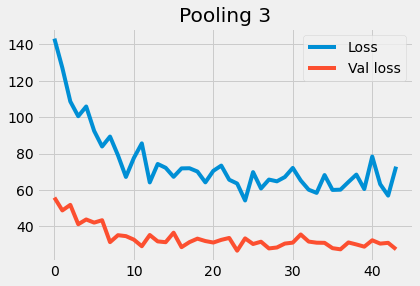

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.54it/s]


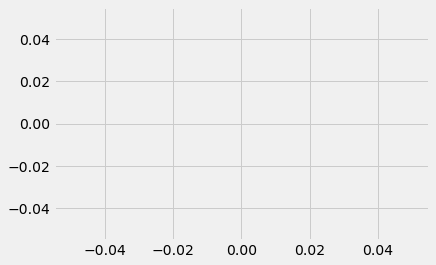

Epoch 1/1000
28/28 [==============================] - 2s 39ms/step - loss: 274.1958 - acc: 0.6438 - val_loss: 143.9356 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 211.2139 - acc: 0.6449 - val_loss: 137.6621 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 190.3304 - acc: 0.6315 - val_loss: 87.3465 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 157.0314 - acc: 0.6393 - val_loss: 81.9755 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 121.0930 - acc: 0.6000 - val_loss: 53.1859 - val_acc: 0.6757 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 106.8540 - acc: 0.5809 - val_loss: 50.1205 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 97.34

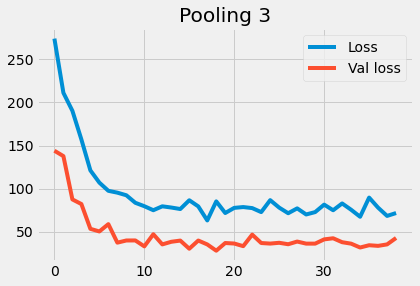

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.57it/s]


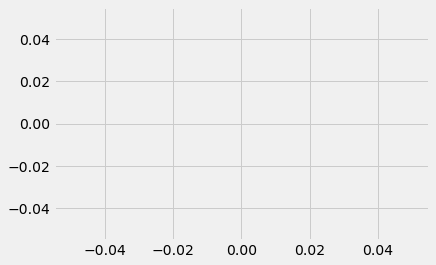

Epoch 1/1000
28/28 [==============================] - 1s 24ms/step - loss: 216.0002 - acc: 0.4213 - val_loss: 101.4425 - val_acc: 0.3874 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 126.9967 - acc: 0.4461 - val_loss: 45.8526 - val_acc: 0.4595 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 80.3899 - acc: 0.5247 - val_loss: 36.0674 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 63.9445 - acc: 0.5685 - val_loss: 34.1683 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 76.8373 - acc: 0.5753 - val_loss: 31.1216 - val_acc: 0.7117 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 68.5073 - acc: 0.5607 - val_loss: 30.9995 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 63.6627 - 

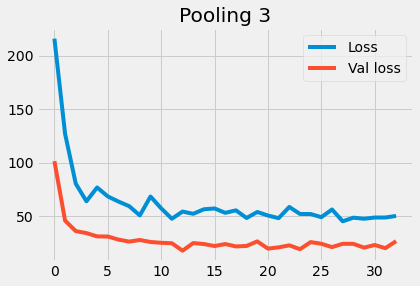

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.92it/s]


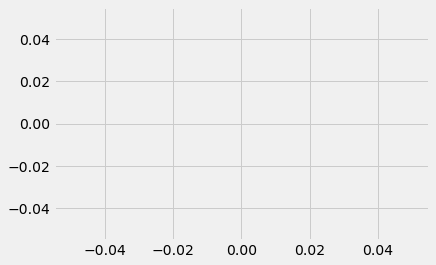

Epoch 1/1000
28/28 [==============================] - 2s 41ms/step - loss: 292.3055 - acc: 0.5888 - val_loss: 206.4228 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 246.5526 - acc: 0.5551 - val_loss: 155.4532 - val_acc: 0.6126 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 173.5260 - acc: 0.5539 - val_loss: 133.5902 - val_acc: 0.5225 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 155.4374 - acc: 0.5404 - val_loss: 88.4256 - val_acc: 0.5586 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 138.6268 - acc: 0.5090 - val_loss: 66.7399 - val_acc: 0.5586 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 102.7363 - acc: 0.5539 - val_loss: 55.4172 - val_acc: 0.4955 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 92.5

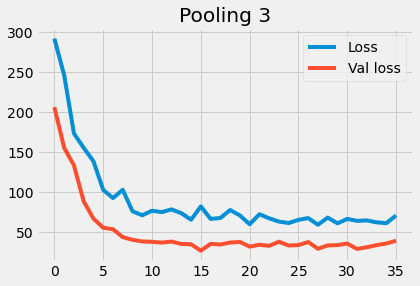

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.28it/s]


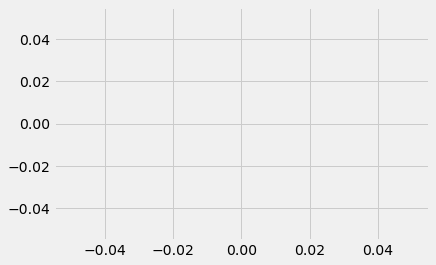

Epoch 1/1000
28/28 [==============================] - 1s 20ms/step - loss: 186.0213 - acc: 0.5764 - val_loss: 136.4483 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 127.7356 - acc: 0.5989 - val_loss: 84.1492 - val_acc: 0.6216 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 107.2597 - acc: 0.6034 - val_loss: 52.4342 - val_acc: 0.6036 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 93.5656 - acc: 0.6079 - val_loss: 40.5973 - val_acc: 0.5856 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 85.6637 - acc: 0.6135 - val_loss: 33.9495 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 80.3320 - acc: 0.6315 - val_loss: 34.1802 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 84.8231 -

Epoch 55/1000
28/28 [==============================] - 0s 10ms/step - loss: 60.2318 - acc: 0.6573 - val_loss: 31.4633 - val_acc: 0.6667 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 11ms/step - loss: 69.9677 - acc: 0.6382 - val_loss: 28.7774 - val_acc: 0.7027 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 10ms/step - loss: 56.2029 - acc: 0.6416 - val_loss: 27.9336 - val_acc: 0.6937 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 10ms/step - loss: 64.0043 - acc: 0.6360 - val_loss: 29.0683 - val_acc: 0.6757 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 10ms/step - loss: 69.4296 - acc: 0.6112 - val_loss: 29.2790 - val_acc: 0.6937 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 11ms/step - loss: 73.8327 - acc: 0.6011 - val_loss: 31.2876 - val_acc: 0.6757 - lr: 1.0000e-06
Epoch 61/1000
28/28 [==============================] - 0s 10ms/step - loss: 64.652

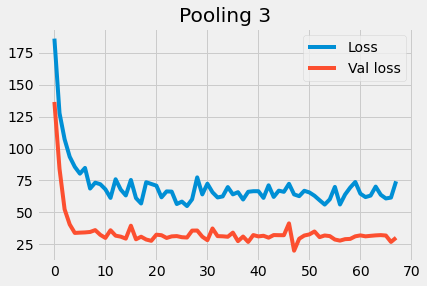

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.02it/s]


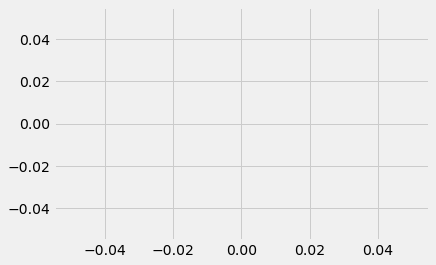

Epoch 1/1000
28/28 [==============================] - 2s 39ms/step - loss: 290.3217 - acc: 0.4191 - val_loss: 204.2159 - val_acc: 0.3694 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 199.4966 - acc: 0.4315 - val_loss: 110.2713 - val_acc: 0.4234 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 116.4482 - acc: 0.5337 - val_loss: 64.7178 - val_acc: 0.5135 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 11ms/step - loss: 111.7440 - acc: 0.5674 - val_loss: 63.4390 - val_acc: 0.5856 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 77.3170 - acc: 0.6247 - val_loss: 43.6637 - val_acc: 0.6577 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 89.7070 - acc: 0.6180 - val_loss: 41.4622 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 65.5035

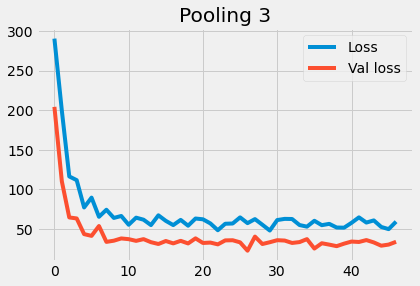

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.31it/s]


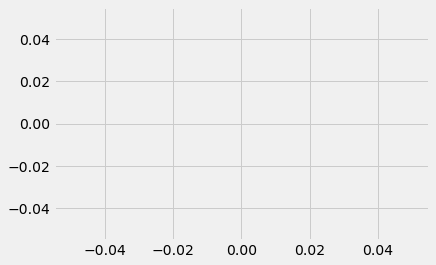

Epoch 1/1000
28/28 [==============================] - 1s 22ms/step - loss: 778.3171 - acc: 0.4258 - val_loss: 578.5853 - val_acc: 0.4054 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 10ms/step - loss: 633.8978 - acc: 0.4034 - val_loss: 472.0321 - val_acc: 0.3964 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 552.0139 - acc: 0.4169 - val_loss: 379.2178 - val_acc: 0.3784 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 9ms/step - loss: 397.4634 - acc: 0.4180 - val_loss: 255.6834 - val_acc: 0.3604 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 11ms/step - loss: 305.5047 - acc: 0.4427 - val_loss: 150.6284 - val_acc: 0.4414 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 9ms/step - loss: 199.2985 - acc: 0.4843 - val_loss: 104.0323 - val_acc: 0.5045 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 11ms/step - loss: 157

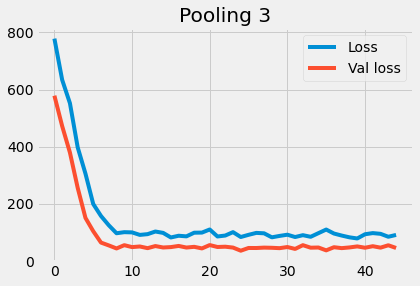

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.26it/s]


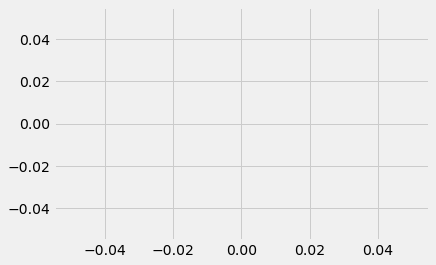

Epoch 1/1000
28/28 [==============================] - 2s 38ms/step - loss: 508.9892 - acc: 0.4416 - val_loss: 361.6118 - val_acc: 0.3604 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 455.3969 - acc: 0.4213 - val_loss: 279.2801 - val_acc: 0.4414 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 10ms/step - loss: 323.9865 - acc: 0.4449 - val_loss: 179.8054 - val_acc: 0.4955 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 266.3334 - acc: 0.4843 - val_loss: 135.3698 - val_acc: 0.4865 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 205.1489 - acc: 0.5404 - val_loss: 119.7914 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 10ms/step - loss: 171.6682 - acc: 0.5798 - val_loss: 103.0797 - val_acc: 0.5946 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 1

28/28 [==============================] - 0s 9ms/step - loss: 114.8637 - acc: 0.6191 - val_loss: 65.2095 - val_acc: 0.6396 - lr: 1.0000e-06
Epoch 55/1000
28/28 [==============================] - 0s 10ms/step - loss: 111.1935 - acc: 0.6584 - val_loss: 65.0413 - val_acc: 0.5856 - lr: 1.0000e-06
Epoch 56/1000
28/28 [==============================] - 0s 11ms/step - loss: 126.6972 - acc: 0.6191 - val_loss: 70.4031 - val_acc: 0.6486 - lr: 1.0000e-06
Epoch 57/1000
28/28 [==============================] - 0s 10ms/step - loss: 101.0557 - acc: 0.6607 - val_loss: 54.6285 - val_acc: 0.6757 - lr: 1.0000e-06
Epoch 58/1000
28/28 [==============================] - 0s 10ms/step - loss: 119.9459 - acc: 0.6191 - val_loss: 61.0704 - val_acc: 0.6396 - lr: 1.0000e-06
Epoch 59/1000
28/28 [==============================] - 0s 10ms/step - loss: 108.1257 - acc: 0.6326 - val_loss: 46.2321 - val_acc: 0.7027 - lr: 1.0000e-06
Epoch 60/1000
28/28 [==============================] - 0s 11ms/step - loss: 126.9076 - acc:

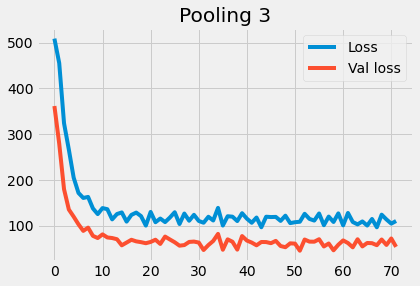

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.78it/s]


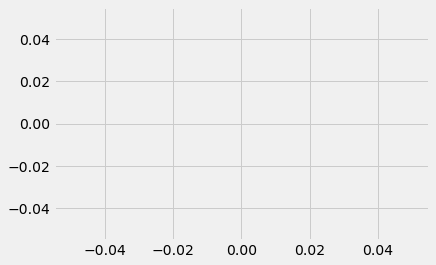

Epoch 1/1000
28/28 [==============================] - 1s 21ms/step - loss: 361.6080 - acc: 0.4562 - val_loss: 165.0880 - val_acc: 0.5676 - lr: 5.0000e-05
Epoch 2/1000
28/28 [==============================] - 0s 11ms/step - loss: 269.7380 - acc: 0.5258 - val_loss: 119.9808 - val_acc: 0.6306 - lr: 5.0000e-05
Epoch 3/1000
28/28 [==============================] - 0s 11ms/step - loss: 196.0080 - acc: 0.5640 - val_loss: 74.3699 - val_acc: 0.6396 - lr: 5.0000e-05
Epoch 4/1000
28/28 [==============================] - 0s 10ms/step - loss: 164.8875 - acc: 0.5989 - val_loss: 81.8725 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 5/1000
28/28 [==============================] - 0s 10ms/step - loss: 133.5018 - acc: 0.5854 - val_loss: 61.1630 - val_acc: 0.6667 - lr: 5.0000e-05
Epoch 6/1000
28/28 [==============================] - 0s 11ms/step - loss: 129.6116 - acc: 0.6034 - val_loss: 50.0533 - val_acc: 0.6486 - lr: 5.0000e-05
Epoch 7/1000
28/28 [==============================] - 0s 10ms/step - loss: 94.41

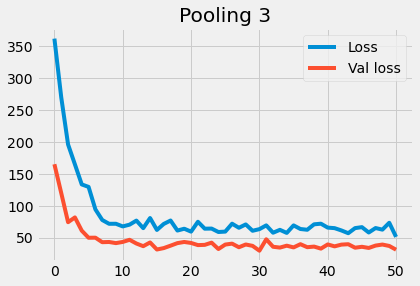

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.21it/s]


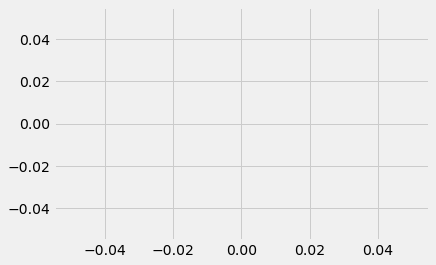

In [27]:
for i in range(100):
    
    history_p = []
    
#     if i < 100:
#         POOLING = 0
#         local_pooling = POOLINGS[POOLING]
#         init_val = None
#     elif 100 <= i < 200:
#         POOLING = 1
#         local_pooling = POOLINGS[POOLING]
#         init_val = None
#     elif 200 <= i < 300:
#         POOLING = 2
#         local_pooling = POOLINGS[POOLING]
#         init_val = 1
#     else:
#         POOLING = 2
#         local_pooling = GlobalLehmerPool(
#             epsilon=EPSILON,
#             init_value=10.
#         )
#         init_val = 10

    POOLING = 3
    local_pooling = POOLINGS[POOLING]
    init_val = None

    # Define the model
    model = GCN(
        channels=32,
        n_layers=3,
        global_pooling=local_pooling,
        dropout_rate=0.1,
        dense_activation='selu',
        graph_layer_activation='selu',
        kernel_initializer='lecun_normal'
    )

    optimizer = keras.optimizers.RMSprop(LR)

    # Compile the model
    model.compile(
        optimizer=optimizer, 
        loss=keras.losses.CategoricalCrossentropy(reduction='sum'),
        weighted_metrics=['acc'],
    )

    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE, 
            restore_best_weights=True),

        tf.keras.callbacks.ReduceLROnPlateau(
            patience=LR_PATIENCE,
            factor=LR_FACTOR,
            min_delta=1000,
            min_lr=1e-6
        )
    ]

    # Get Lehmer idx
    lehmer_layer_idx = 0

    for i, l in enumerate(model.layers):
        if 'GlobalLehmerPool' in str(l):
            lehmer_layer_idx = i

    if POOLING == 2:
        history_p = []
        cl = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: history_p.append(model.layers[lehmer_layer_idx].p.numpy()))
        callbacks.append(cl)


    # Fit the model
    history = model.fit(
        loader_train.load(), 
        steps_per_epoch=loader_train.steps_per_epoch, 
        validation_data=loader_val.load(),
        validation_steps=loader_val.steps_per_epoch,
        epochs=N_EPOCHS,
        callbacks=callbacks
    )

    # Plot
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Val loss')
    plt.title(f'Pooling {POOLING}')
    plt.legend()
    plt.show()


    results = []

    for i in tqdm(range(100)):
        eval_results = model.evaluate(loader_test.load(), steps=loader_test.steps_per_epoch, verbose=0)
        results.append(eval_results[1])

    fname = rf'./logs/{dt.strftime(dt.now(), "%Y_%m_%d__%H-%M-%S")}__pooling_{POOLING}__init_{init_val}.csv'
    np.savetxt(fname, results)


    if POOLING == 2:
        fname = rf'./logs/{dt.strftime(dt.now(), "%Y_%m_%d__%H-%M-%S")}__pooling_{POOLING}__trajectory__init_{init_val}.csv'
        np.savetxt(fname, history_p)


    plt.plot(history_p)
    plt.show()
    
    del model
    tf.keras.backend.clear_session()
    
    sleep(1)

In [623]:
def lehmer(x, p, axis=-2):
    return np.sum(x**p, axis=axis) / np.sum(x**(p-1), axis=axis)

In [666]:
N_OBS = 100

# Create fake training data
X = stats.halfnorm().rvs((32, N_OBS, 1))
y = lehmer(X, p=10., axis=-2).sum(axis=1)


In [667]:
X.shape, y.shape

((32, 100, 1), (32,))

In [695]:
inputs = keras.Input(shape=(100,1))
# x = Linear(units=16, inputNone, 1_dim=4)(inputs)
x = GlobalLehmerPool()(inputs)
outputs = tf.keras.layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)


In [696]:
model.summary()

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 100, 1)]          0         
                                                                 
 global_lehmer_pool_34 (Glob  (None, 1)                1         
 alLehmerPool)                                                   
                                                                 
 dense_54 (Dense)            (None, 1)                 2         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [697]:
history_p = []
cl = tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: history_p.append(model.layers[1].p.numpy()))

In [698]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error')

In [701]:
model.fit(X, y, epochs=1000, callbacks=[cl])

Epoch 1/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0071
Epoch 2/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0071
Epoch 3/1000
1/1 [==============================] - 0s 22ms/step - loss: 0.0071
Epoch 4/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.0070
Epoch 5/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.0070
Epoch 6/1000
1/1 [==============================] - 0s 17ms/step - loss: 0.0070
Epoch 7/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0070
Epoch 8/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0070
Epoch 9/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0070
Epoch 10/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0069
Epoch 11/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0069
Epoch 12/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.0069
Epoch 13/1000
1/1 [=====================

1/1 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 205/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 206/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 207/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 208/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0045
Epoch 209/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 210/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.0045
Epoch 211/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 212/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 213/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 214/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 215/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 216/1000
1/1 [======================

1/1 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 407/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 408/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 409/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 410/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 411/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 412/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 413/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 414/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 415/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.0032
Epoch 416/1000
1/1 [==============================] - 0s 15ms/step - loss: 0.0032
Epoch 417/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0032
Epoch 418/1000
1/1 [=====================

1/1 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 609/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 610/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 611/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 612/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 613/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 614/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 615/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 616/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 617/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 618/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 619/1000
1/1 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 620/1000
1/1 [=======================

1/1 [==============================] - 0s 11ms/step - loss: 0.0018
Epoch 811/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 812/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 813/1000
1/1 [==============================] - 0s 9ms/step - loss: 0.0018
Epoch 814/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 815/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 816/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 817/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 818/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 819/1000
1/1 [==============================] - 0s 6ms/step - loss: 0.0018
Epoch 820/1000
1/1 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 821/1000
1/1 [==============================] - 0s 7ms/step - loss: 0.0018
Epoch 822/1000
1/1 [======================

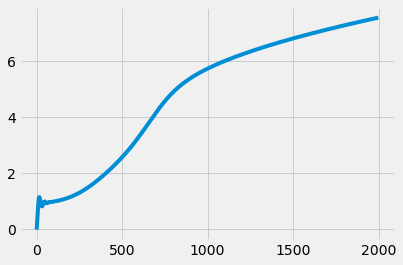

In [702]:
plt.plot(history_p)

In [674]:
model.get_layer('global_lehmer_pool_32').p

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([9.981453], dtype=float32)>

In [677]:
model.

array([9.981453], dtype=float32)

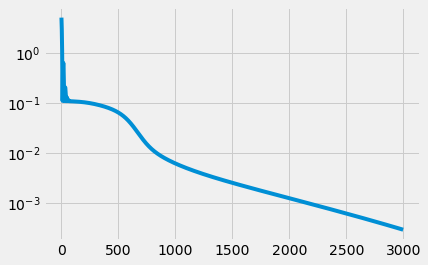

In [675]:
plt.plot(model.history.history['loss'][:3000])
plt.yscale('log')

ValueError: x and y must be the same size

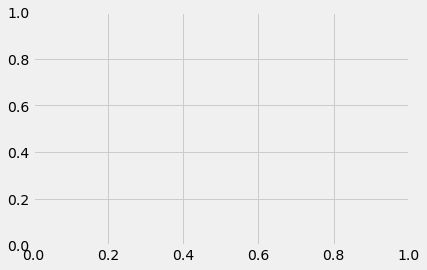

In [645]:
plt.scatter(X, y)
plt.scatter(X, model.predict(X))

In [462]:
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
# Instantiate a loss function.
loss_fn = keras.losses.MeanSquaredError()

In [503]:
losses = []

epochs = 1000

for epoch in range(epochs):

    with tf.GradientTape() as tape:
        # Get logits
        preds = model(X, training=True)  

        # Compute the loss value for this minibatch.
        loss_val = loss_fn(y, preds)
        
        losses.append(loss_val)

    # Get grads
    grads = tape.gradient(loss_val, model.trainable_weights)

    # Optimize
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # Log
    if (epoch % 100) == 0:
        print(f'Epoch: {epoch}\nLoss: {loss_val}')


15 tf.Tensor([2.8834782], shape=(1,), dtype=float32) tf.Tensor(10628.723, shape=(), dtype=float32)
Epoch: 0
Loss: 10628.72265625
15 tf.Tensor([3.8014402], shape=(1,), dtype=float32) tf.Tensor(9904.549, shape=(), dtype=float32)
15 tf.Tensor([4.8047047], shape=(1,), dtype=float32) tf.Tensor(9189.667, shape=(), dtype=float32)
15 tf.Tensor([5.863975], shape=(1,), dtype=float32) tf.Tensor(8521.76, shape=(), dtype=float32)
15 tf.Tensor([6.956505], shape=(1,), dtype=float32) tf.Tensor(7926.288, shape=(), dtype=float32)
15 tf.Tensor([8.063354], shape=(1,), dtype=float32) tf.Tensor(7419.3975, shape=(), dtype=float32)
15 tf.Tensor([9.167971], shape=(1,), dtype=float32) tf.Tensor(7009.5337, shape=(), dtype=float32)
15 tf.Tensor([10.255438], shape=(1,), dtype=float32) tf.Tensor(6698.49, shape=(), dtype=float32)
15 tf.Tensor([11.312092], shape=(1,), dtype=float32) tf.Tensor(6482.261, shape=(), dtype=float32)
15 tf.Tensor([12.325426], shape=(1,), dtype=float32) tf.Tensor(6351.8823, shape=(), dtype=f

15 tf.Tensor([34.54802], shape=(1,), dtype=float32) tf.Tensor(5220.405, shape=(), dtype=float32)
15 tf.Tensor([34.744846], shape=(1,), dtype=float32) tf.Tensor(5211.9736, shape=(), dtype=float32)
Epoch: 100
Loss: 5211.9736328125
15 tf.Tensor([34.940315], shape=(1,), dtype=float32) tf.Tensor(5203.607, shape=(), dtype=float32)
15 tf.Tensor([35.134377], shape=(1,), dtype=float32) tf.Tensor(5195.3022, shape=(), dtype=float32)
15 tf.Tensor([35.326996], shape=(1,), dtype=float32) tf.Tensor(5187.0576, shape=(), dtype=float32)
15 tf.Tensor([35.51816], shape=(1,), dtype=float32) tf.Tensor(5178.8716, shape=(), dtype=float32)
15 tf.Tensor([35.707874], shape=(1,), dtype=float32) tf.Tensor(5170.743, shape=(), dtype=float32)
15 tf.Tensor([35.89615], shape=(1,), dtype=float32) tf.Tensor(5162.6704, shape=(), dtype=float32)
15 tf.Tensor([36.08301], shape=(1,), dtype=float32) tf.Tensor(5154.652, shape=(), dtype=float32)
15 tf.Tensor([36.2685], shape=(1,), dtype=float32) tf.Tensor(5146.6875, shape=(), dt

15 tf.Tensor([49.39014], shape=(1,), dtype=float32) tf.Tensor(4634.5776, shape=(), dtype=float32)
15 tf.Tensor([49.527214], shape=(1,), dtype=float32) tf.Tensor(4629.81, shape=(), dtype=float32)
15 tf.Tensor([49.663864], shape=(1,), dtype=float32) tf.Tensor(4625.0693, shape=(), dtype=float32)
15 tf.Tensor([49.800095], shape=(1,), dtype=float32) tf.Tensor(4620.355, shape=(), dtype=float32)
15 tf.Tensor([49.93591], shape=(1,), dtype=float32) tf.Tensor(4615.666, shape=(), dtype=float32)
15 tf.Tensor([50.071304], shape=(1,), dtype=float32) tf.Tensor(4611.0024, shape=(), dtype=float32)
15 tf.Tensor([50.20629], shape=(1,), dtype=float32) tf.Tensor(4606.3647, shape=(), dtype=float32)
15 tf.Tensor([50.34086], shape=(1,), dtype=float32) tf.Tensor(4601.752, shape=(), dtype=float32)
15 tf.Tensor([50.475025], shape=(1,), dtype=float32) tf.Tensor(4597.1646, shape=(), dtype=float32)
15 tf.Tensor([50.608788], shape=(1,), dtype=float32) tf.Tensor(4592.602, shape=(), dtype=float32)
Epoch: 200
Loss: 459

15 tf.Tensor([60.17761], shape=(1,), dtype=float32) tf.Tensor(4295.3647, shape=(), dtype=float32)
15 tf.Tensor([60.284798], shape=(1,), dtype=float32) tf.Tensor(4292.3604, shape=(), dtype=float32)
15 tf.Tensor([60.391724], shape=(1,), dtype=float32) tf.Tensor(4289.37, shape=(), dtype=float32)
15 tf.Tensor([60.498375], shape=(1,), dtype=float32) tf.Tensor(4286.395, shape=(), dtype=float32)
15 tf.Tensor([60.60476], shape=(1,), dtype=float32) tf.Tensor(4283.435, shape=(), dtype=float32)
15 tf.Tensor([60.710873], shape=(1,), dtype=float32) tf.Tensor(4280.4897, shape=(), dtype=float32)
15 tf.Tensor([60.816723], shape=(1,), dtype=float32) tf.Tensor(4277.558, shape=(), dtype=float32)
15 tf.Tensor([60.922306], shape=(1,), dtype=float32) tf.Tensor(4274.6406, shape=(), dtype=float32)
15 tf.Tensor([61.027626], shape=(1,), dtype=float32) tf.Tensor(4271.7383, shape=(), dtype=float32)
15 tf.Tensor([61.132683], shape=(1,), dtype=float32) tf.Tensor(4268.849, shape=(), dtype=float32)
15 tf.Tensor([61.2

15 tf.Tensor([68.93756], shape=(1,), dtype=float32) tf.Tensor(4073.5923, shape=(), dtype=float32)
15 tf.Tensor([69.02379], shape=(1,), dtype=float32) tf.Tensor(4071.649, shape=(), dtype=float32)
15 tf.Tensor([69.10981], shape=(1,), dtype=float32) tf.Tensor(4069.7139, shape=(), dtype=float32)
15 tf.Tensor([69.19564], shape=(1,), dtype=float32) tf.Tensor(4067.7883, shape=(), dtype=float32)
15 tf.Tensor([69.28128], shape=(1,), dtype=float32) tf.Tensor(4065.8708, shape=(), dtype=float32)
15 tf.Tensor([69.366714], shape=(1,), dtype=float32) tf.Tensor(4063.9631, shape=(), dtype=float32)
15 tf.Tensor([69.451965], shape=(1,), dtype=float32) tf.Tensor(4062.064, shape=(), dtype=float32)
15 tf.Tensor([69.53702], shape=(1,), dtype=float32) tf.Tensor(4060.174, shape=(), dtype=float32)
15 tf.Tensor([69.62188], shape=(1,), dtype=float32) tf.Tensor(4058.2927, shape=(), dtype=float32)
15 tf.Tensor([69.70655], shape=(1,), dtype=float32) tf.Tensor(4056.4197, shape=(), dtype=float32)
15 tf.Tensor([69.7910

15 tf.Tensor([76.18439], shape=(1,), dtype=float32) tf.Tensor(3926.4622, shape=(), dtype=float32)
15 tf.Tensor([76.254524], shape=(1,), dtype=float32) tf.Tensor(3925.1987, shape=(), dtype=float32)
15 tf.Tensor([76.3245], shape=(1,), dtype=float32) tf.Tensor(3923.9412, shape=(), dtype=float32)
15 tf.Tensor([76.39434], shape=(1,), dtype=float32) tf.Tensor(3922.6897, shape=(), dtype=float32)
15 tf.Tensor([76.46401], shape=(1,), dtype=float32) tf.Tensor(3921.444, shape=(), dtype=float32)
15 tf.Tensor([76.53354], shape=(1,), dtype=float32) tf.Tensor(3920.2039, shape=(), dtype=float32)
15 tf.Tensor([76.60291], shape=(1,), dtype=float32) tf.Tensor(3918.9692, shape=(), dtype=float32)
15 tf.Tensor([76.67214], shape=(1,), dtype=float32) tf.Tensor(3917.7402, shape=(), dtype=float32)
15 tf.Tensor([76.74122], shape=(1,), dtype=float32) tf.Tensor(3916.5176, shape=(), dtype=float32)
15 tf.Tensor([76.81014], shape=(1,), dtype=float32) tf.Tensor(3915.2998, shape=(), dtype=float32)
15 tf.Tensor([76.8789

15 tf.Tensor([82.498314], shape=(1,), dtype=float32) tf.Tensor(3825.0781, shape=(), dtype=float32)
15 tf.Tensor([82.55484], shape=(1,), dtype=float32) tf.Tensor(3824.2832, shape=(), dtype=float32)
15 tf.Tensor([82.61124], shape=(1,), dtype=float32) tf.Tensor(3823.4917, shape=(), dtype=float32)
15 tf.Tensor([82.66751], shape=(1,), dtype=float32) tf.Tensor(3822.7043, shape=(), dtype=float32)
15 tf.Tensor([82.72366], shape=(1,), dtype=float32) tf.Tensor(3821.9204, shape=(), dtype=float32)
15 tf.Tensor([82.7797], shape=(1,), dtype=float32) tf.Tensor(3821.1406, shape=(), dtype=float32)
15 tf.Tensor([82.83562], shape=(1,), dtype=float32) tf.Tensor(3820.3638, shape=(), dtype=float32)
15 tf.Tensor([82.89142], shape=(1,), dtype=float32) tf.Tensor(3819.5908, shape=(), dtype=float32)
15 tf.Tensor([82.9471], shape=(1,), dtype=float32) tf.Tensor(3818.8218, shape=(), dtype=float32)
15 tf.Tensor([83.00265], shape=(1,), dtype=float32) tf.Tensor(3818.056, shape=(), dtype=float32)
15 tf.Tensor([83.05809

15 tf.Tensor([87.40413], shape=(1,), dtype=float32) tf.Tensor(3763.5312, shape=(), dtype=float32)
15 tf.Tensor([87.45004], shape=(1,), dtype=float32) tf.Tensor(3763.0264, shape=(), dtype=float32)
15 tf.Tensor([87.49585], shape=(1,), dtype=float32) tf.Tensor(3762.5242, shape=(), dtype=float32)
15 tf.Tensor([87.54156], shape=(1,), dtype=float32) tf.Tensor(3762.024, shape=(), dtype=float32)
15 tf.Tensor([87.587166], shape=(1,), dtype=float32) tf.Tensor(3761.5264, shape=(), dtype=float32)
15 tf.Tensor([87.632675], shape=(1,), dtype=float32) tf.Tensor(3761.0312, shape=(), dtype=float32)
15 tf.Tensor([87.678085], shape=(1,), dtype=float32) tf.Tensor(3760.5383, shape=(), dtype=float32)
15 tf.Tensor([87.723404], shape=(1,), dtype=float32) tf.Tensor(3760.048, shape=(), dtype=float32)
15 tf.Tensor([87.768616], shape=(1,), dtype=float32) tf.Tensor(3759.5596, shape=(), dtype=float32)
15 tf.Tensor([87.81373], shape=(1,), dtype=float32) tf.Tensor(3759.074, shape=(), dtype=float32)
15 tf.Tensor([87.8

15 tf.Tensor([91.6745], shape=(1,), dtype=float32) tf.Tensor(3722.2192, shape=(), dtype=float32)
15 tf.Tensor([91.71093], shape=(1,), dtype=float32) tf.Tensor(3721.916, shape=(), dtype=float32)
15 tf.Tensor([91.74728], shape=(1,), dtype=float32) tf.Tensor(3721.6138, shape=(), dtype=float32)
15 tf.Tensor([91.78354], shape=(1,), dtype=float32) tf.Tensor(3721.3137, shape=(), dtype=float32)
15 tf.Tensor([91.819725], shape=(1,), dtype=float32) tf.Tensor(3721.0144, shape=(), dtype=float32)
15 tf.Tensor([91.85582], shape=(1,), dtype=float32) tf.Tensor(3720.7175, shape=(), dtype=float32)
15 tf.Tensor([91.89184], shape=(1,), dtype=float32) tf.Tensor(3720.4214, shape=(), dtype=float32)
15 tf.Tensor([91.92777], shape=(1,), dtype=float32) tf.Tensor(3720.1272, shape=(), dtype=float32)
15 tf.Tensor([91.96363], shape=(1,), dtype=float32) tf.Tensor(3719.8345, shape=(), dtype=float32)
15 tf.Tensor([91.999405], shape=(1,), dtype=float32) tf.Tensor(3719.5432, shape=(), dtype=float32)
15 tf.Tensor([92.035

15 tf.Tensor([94.99], shape=(1,), dtype=float32) tf.Tensor(3698.0137, shape=(), dtype=float32)
15 tf.Tensor([95.01874], shape=(1,), dtype=float32) tf.Tensor(3697.834, shape=(), dtype=float32)
15 tf.Tensor([95.047424], shape=(1,), dtype=float32) tf.Tensor(3697.6555, shape=(), dtype=float32)
15 tf.Tensor([95.076035], shape=(1,), dtype=float32) tf.Tensor(3697.4773, shape=(), dtype=float32)
15 tf.Tensor([95.10457], shape=(1,), dtype=float32) tf.Tensor(3697.3003, shape=(), dtype=float32)
15 tf.Tensor([95.13305], shape=(1,), dtype=float32) tf.Tensor(3697.1243, shape=(), dtype=float32)
15 tf.Tensor([95.16145], shape=(1,), dtype=float32) tf.Tensor(3696.949, shape=(), dtype=float32)
15 tf.Tensor([95.1898], shape=(1,), dtype=float32) tf.Tensor(3696.7754, shape=(), dtype=float32)
15 tf.Tensor([95.21806], shape=(1,), dtype=float32) tf.Tensor(3696.602, shape=(), dtype=float32)
15 tf.Tensor([95.24627], shape=(1,), dtype=float32) tf.Tensor(3696.4292, shape=(), dtype=float32)
15 tf.Tensor([95.27441], 

15 tf.Tensor([97.478424], shape=(1,), dtype=float32) tf.Tensor(3684.3652, shape=(), dtype=float32)
15 tf.Tensor([97.50111], shape=(1,), dtype=float32) tf.Tensor(3684.259, shape=(), dtype=float32)
15 tf.Tensor([97.52373], shape=(1,), dtype=float32) tf.Tensor(3684.1533, shape=(), dtype=float32)
15 tf.Tensor([97.546295], shape=(1,), dtype=float32) tf.Tensor(3684.0476, shape=(), dtype=float32)
15 tf.Tensor([97.56881], shape=(1,), dtype=float32) tf.Tensor(3683.9426, shape=(), dtype=float32)
15 tf.Tensor([97.59126], shape=(1,), dtype=float32) tf.Tensor(3683.8386, shape=(), dtype=float32)
15 tf.Tensor([97.61366], shape=(1,), dtype=float32) tf.Tensor(3683.7349, shape=(), dtype=float32)
15 tf.Tensor([97.63601], shape=(1,), dtype=float32) tf.Tensor(3683.6316, shape=(), dtype=float32)
15 tf.Tensor([97.658295], shape=(1,), dtype=float32) tf.Tensor(3683.5293, shape=(), dtype=float32)
15 tf.Tensor([97.68053], shape=(1,), dtype=float32) tf.Tensor(3683.427, shape=(), dtype=float32)
15 tf.Tensor([97.70

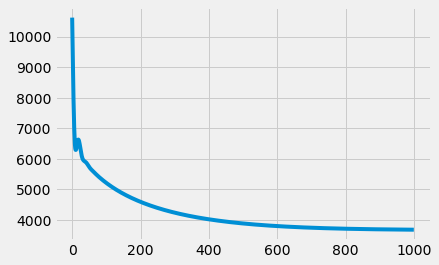

In [504]:
plt.plot(losses)

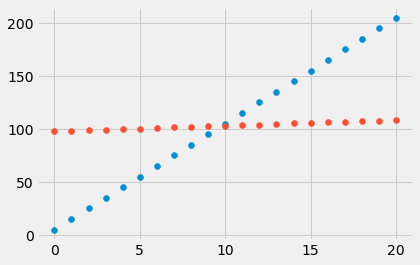

In [505]:
plt.scatter(X, y)
plt.scatter(X, model.predict(X).squeeze())

In [373]:
tf.reduce_sum(tf.constant([[1., 2., 4., 5.]])/10)

<tf.Tensor: shape=(), dtype=float32, numpy=1.2>

Successfully loaded PROTEINS.


In [221]:
# inputs = tf.random.normal(shape=(2, 5, 4), dtype='float32')
# global_min = tf.reduce_min(inputs) - 1e-4

# # epsilon = 0#1e-6
# p = tf.constant(-1.1, dtype='float32')

# print('ORIGINAL INPUT')
# print(inputs)


# if global_min > 0:
#     global_min = tf.constant(0.)

# inputs -= global_min

# print('\nADJ. INPUTS')
# print(inputs) 

# print('\nLehmer')
# print(tf.reduce_sum(
#             inputs**p, axis=-2
#         ) / tf.reduce_sum(
#             inputs**(p-1), axis=-2
#         ) + global_min)

# print('\nRegular')
# print(tf.reduce_mean(inputs + global_min, axis=-2))


## Batch structure:

* `i[0]` -> `tuple`
    * `[0]` -> feature matrix `(batch_size, n_nodes, n_dim)`
    * `[1]` -> adjacency matrix `(batch_size, n_nodes, n_nodes)`
    
    
* `i[1]` -> array of OHE labels `(batch_size, n_labels)`

In [9]:
ga = GlobalAvgPool()

In [10]:
gl = GlobalLehmerPool()

In [11]:
for d in loader_train:
    x = d[0][0]
    
    print(gl(x).shape == ga(x).shape)
    
    break

(32, 4)
True


C:\Users\aleks\anaconda3\envs\tf-graphs-probability\lib\site-packages\spektral\data\utils.py:213: UserWarning: you are shuffling a 'TUDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


In [225]:
# gl.p

In [226]:
# gl.p = 1.

In [227]:
# (gl(i[0][0]) - ga(i[0][0]))

In [228]:
len(i)

2

In [229]:
i[0][1].shape

(32, 101, 101)

In [230]:
i[0][0].shape

(32, 101, 4)

In [246]:
class GCN(keras.models.Model):
    
    def __init__(self, channels, n_layers, global_pooling, dropout_rate=.2, dense_activation='selu'):
        
        super().__init__()
        
        self.conv1 = spktrl.layers.GCNConv(channels)
        self.convs = []
        
        for _ in range(1, n_layers):
            self.convs.append(
                spktrl.layers.GCNConv(channels)
            )
        self.pool = global_pooling
        self.dense1 = keras.layers.Dense(channels, activation=dense_activation)
        self.dropout = keras.layers.Dropout(dropout_rate)
        self.dense2 = keras.layers.Dense(dataset.n_labels, activation='softmax')

    def call(self, inputs):
        x, a = inputs
        x = self.conv1([x, a])
        for conv in self.convs:
            x = conv([x, a])
        x = self.pool(x)
        x = self.dense1(x)
        x = self.dropout(x)
        return self.dense2(x)

## Experiments

In [257]:
LR = 5e-5
N_EPOCHS = 100

PATIENCE = 10
LR_PATIENCE = 4
LR_FACTOR = .5

POOLING = GlobalSumPool()#GlobalAvgPool()

In [258]:
model = GCN(
    channels=16,
    n_layers=3,
    global_pooling=POOLING,
    dropout_rate=.1,
    dense_activation='gelu'
)

In [259]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=PATIENCE, 
        restore_best_weights=True),

    tf.keras.callbacks.ReduceLROnPlateau(
        patience=LR_PATIENCE,
        factor=LR_FACTOR,
        min_delta=1000,
        min_lr=1e-6
    )
]

In [261]:
optimizer = keras.optimizers.RMSprop(LR)

# Compile the model
model.compile(
    optimizer=optimizer, 
    loss=keras.losses.CategoricalCrossentropy(reduction='sum'),
    weighted_metrics=['acc'],
)

In [262]:
# Fit the model
history = model.fit(
    loader_train.load(), 
    steps_per_epoch=loader_train.steps_per_epoch, 
    validation_data=loader_val.load(),
    validation_steps=loader_val.steps_per_epoch,
    epochs=N_EPOCHS,
#     callbacks=callbacks
)

Epoch 1/100
25/25 [==============================] - 1s 26ms/step - loss: 111440.4141 - acc: 0.3756 - val_loss: 86535.5859 - val_acc: 0.3608
Epoch 2/100
25/25 [==============================] - 0s 12ms/step - loss: 86872.5469 - acc: 0.3897 - val_loss: 76999.0781 - val_acc: 0.3402
Epoch 3/100
25/25 [==============================] - 0s 11ms/step - loss: 67150.3984 - acc: 0.3795 - val_loss: 37147.3281 - val_acc: 0.3402
Epoch 4/100
25/25 [==============================] - 0s 10ms/step - loss: 50533.7227 - acc: 0.3885 - val_loss: 26785.9258 - val_acc: 0.3608
Epoch 5/100
25/25 [==============================] - 0s 11ms/step - loss: 30164.8789 - acc: 0.4218 - val_loss: 10316.0820 - val_acc: 0.3402
Epoch 6/100
25/25 [==============================] - 0s 12ms/step - loss: 19826.3281 - acc: 0.5000 - val_loss: 1863.3976 - val_acc: 0.6082
Epoch 7/100
25/25 [==============================] - 0s 12ms/step - loss: 16820.8555 - acc: 0.5949 - val_loss: 1674.7136 - val_acc: 0.7423
Epoch 8/100
25/25 [==

Epoch 60/100
25/25 [==============================] - 0s 12ms/step - loss: 1105.7975 - acc: 0.6372 - val_loss: 581.3846 - val_acc: 0.6598
Epoch 61/100
25/25 [==============================] - 0s 12ms/step - loss: 947.1558 - acc: 0.6372 - val_loss: 546.0164 - val_acc: 0.6804
Epoch 62/100
25/25 [==============================] - 0s 11ms/step - loss: 938.5927 - acc: 0.6359 - val_loss: 477.7809 - val_acc: 0.7526
Epoch 63/100
25/25 [==============================] - 0s 12ms/step - loss: 911.9459 - acc: 0.6077 - val_loss: 404.3272 - val_acc: 0.6495
Epoch 64/100
25/25 [==============================] - 0s 13ms/step - loss: 736.5028 - acc: 0.6218 - val_loss: 459.3094 - val_acc: 0.6495
Epoch 65/100
25/25 [==============================] - 0s 11ms/step - loss: 810.9965 - acc: 0.6346 - val_loss: 439.9806 - val_acc: 0.6701
Epoch 66/100
25/25 [==============================] - 0s 13ms/step - loss: 850.3568 - acc: 0.6000 - val_loss: 371.4290 - val_acc: 0.6289
Epoch 67/100
25/25 [====================

In [263]:
model.summary()

Model: "gcn_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gcn_conv_34 (GCNConv)       multiple                  80        
                                                                 
 gcn_conv_35 (GCNConv)       multiple                  272       
                                                                 
 gcn_conv_36 (GCNConv)       multiple                  272       
                                                                 
 global_sum_pool_1 (GlobalSu  multiple                 0         
 mPool)                                                          
                                                                 
 dense_26 (Dense)            multiple                  272       
                                                                 
 dropout_13 (Dropout)        multiple                  0         
                                                            

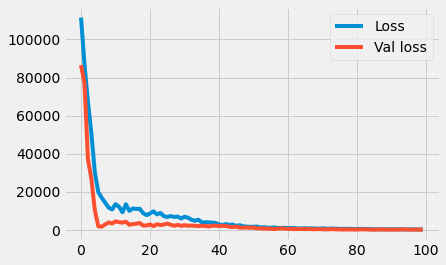

In [264]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

In [268]:
eval_results = model.evaluate(loader_test.load(), steps=loader_test.steps_per_epoch)

4/4 [==============================] - 0s 38ms/step - loss: 106.9881 - acc: 0.5816


In [70]:
# Experiment name
EXPERIMENT_NAME = 'Lehmer Global Pooling'

# Create exp
# mlflow.create_experiment(EXPERIMENT_NAME)

# Optuna rounds
N_OPTUNA_TRIALS = 1

# Set seed
SEED = 420

In [71]:
POOLERS = [
    GlobalAvgPool,
    GlobalSumPool,
    GlobalLehmerMeanPool,
    GlobalMaxPool
]

In [72]:
def objective(trial):
    
    """Runs an optimization step with MLflow tracking included"""
    
    with mlflow.start_run():
    
        ################# PARAMS AND LOGGING ######################

        # Define params
        GLOBAL_POOLING = GlobalLehmerMeanPool #trial.suggest_categorical('GLOBAL_POOLING', POOLERS)
        N_GRAPH_LAYERS = trial.suggest_int('N_GRAPH_LAYERS', 1, 4)

        N_EPOCHS = 500  # Number of training epochs
        LR = 5e-3

        PATIENCE = 20
        LR_PATIENCE = 4
        LR_FACTOR = .5

        # Log addtitonal params
        mlflow.log_param('GLOBAL_POOLING', GLOBAL_POOLING)
        mlflow.log_param('N_GRAPH_LAYERS', N_GRAPH_LAYERS)
        mlflow.log_param('SEED', SEED)


        ################# SESSION CONFIG ######################

        # Cleaer session
        tf.keras.backend.clear_session()


        ################# MODEL CONFIG ######################
        
        # Set seed
        tf.random.set_seed(SEED)
        
        # Initialize the model
        model = GCN(
            channels=16,
            global_pooling=GLOBAL_POOLING,
            n_layers=N_GRAPH_LAYERS,
            dropout_rate=.1
        )

        # Define callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                patience=PATIENCE, 
                restore_best_weights=True),

            tf.keras.callbacks.ReduceLROnPlateau(
                patience=LR_PATIENCE,
                factor=LR_FACTOR,
                min_delta=1000,
                min_lr=1e-6
            )
        ]

        # Define the optimizer
        optimizer = keras.optimizers.RMSprop(LR)

        # Compile the model
        model.compile(
            optimizer=optimizer, 
            loss=keras.losses.CategoricalCrossentropy(reduction='sum'),
            weighted_metrics=['acc'],
        )
        
        # Fit the model
        history = model.fit(
            loader_train.load(), 
            steps_per_epoch=loader_train.steps_per_epoch, 
            validation_data=loader_val.load(),
            validation_steps=loader_val.steps_per_epoch,
            epochs=N_EPOCHS,
            callbacks=callbacks
        )

        # Evaluate on DEV
        weighted_accuracy = model.evaluate(loader_val.load(), steps=loader_val.steps_per_epoch)
    
    return weighted_accuracy
    

In [73]:
# Optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_OPTUNA_TRIALS)

[I 2022-11-23 22:00:12,633] A new study created in memory with name: no-name-4cef6d91-a519-4c5d-ac49-08f880e9f0bc


Epoch 1/500


[W 2022-11-23 22:00:16,007] Trial 0 failed because of the following error: OperatorNotAllowedInGraphError('in user code:\n\n    File "C:\\Users\\aleks\\anaconda3\\envs\\tf-graphs-probability\\lib\\site-packages\\keras\\engine\\training.py", line 1021, in train_function  *\n        return step_function(self, iterator)\n    File "C:\\Users\\aleks\\anaconda3\\envs\\tf-graphs-probability\\lib\\site-packages\\keras\\engine\\training.py", line 1010, in step_function  **\n        outputs = model.distribute_strategy.run(run_step, args=(data,))\n    File "C:\\Users\\aleks\\anaconda3\\envs\\tf-graphs-probability\\lib\\site-packages\\keras\\engine\\training.py", line 1000, in run_step  **\n        outputs = model.train_step(data)\n    File "C:\\Users\\aleks\\anaconda3\\envs\\tf-graphs-probability\\lib\\site-packages\\keras\\engine\\training.py", line 859, in train_step\n        y_pred = self(x, training=True)\n    File "C:\\Users\\aleks\\anaconda3\\envs\\tf-graphs-probability\\lib\\site-packages\

OperatorNotAllowedInGraphError: in user code:

    File "C:\Users\aleks\anaconda3\envs\tf-graphs-probability\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\aleks\anaconda3\envs\tf-graphs-probability\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\aleks\anaconda3\envs\tf-graphs-probability\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\aleks\anaconda3\envs\tf-graphs-probability\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\aleks\anaconda3\envs\tf-graphs-probability\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None

    OperatorNotAllowedInGraphError: Exception encountered when calling layer "gcn" (type GCN).
    
    in user code:
    
        File "C:\Users\aleks\AppData\Local\Temp/ipykernel_35664/1713372720.py", line 24, in call  *
            x = self.pool(x)
        File "C:\Users\aleks\anaconda3\envs\tf-graphs-probability\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        OperatorNotAllowedInGraphError: Exception encountered when calling layer "global_lehmer_mean_pool" (type GlobalLehmerMeanPool).
        
        in user code:
        
            File "C:\Users\aleks\anaconda3\envs\tf-graphs-probability\lib\site-packages\spektral\layers\pooling\global_pool.py", line 40, in call  *
                X, axis=-2, keepdims=(self.data_mode == "single")
            File "C:\Users\aleks\AppData\Local\Temp/ipykernel_35664/2795771387.py", line 39, in lehmer  *
                [xx**((self.p*self.p_multiplier)-1) for xx in inputs], **kwargs
        
            OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.
        
        
        Call arguments received:
          • inputs=tf.Tensor(shape=(None, None, 16), dtype=float32)
    
    
    Call arguments received:
      • inputs=('tf.Tensor(shape=(None, None, None), dtype=float32)', 'tf.Tensor(shape=(None, None, None), dtype=float32)')
